In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy import interpolate
from scipy.integrate import simps, romb, trapz

In [2]:
kB=8.6173324E-05 # eV/K
convRyd2eV=13.6057 # eV/Ryd

# Define final scattered electron energy and temperatures

In [3]:
ener=[1.00E-02,2.20E-01,4.89E-01,8.17E-01,1.22E+00,1.71E+00,2.30E+00,3.03E+00,3.92E+00,5.00E+00]
T=[3.0E+03,4.0E+03,5.0E+03,6.0E+03,7.0E+03,8.0E+03,9.0E+03,1.0E+04,1.1E+04,1.2E+04,1.3E+04,1.4E+04,1.5E+04,1.6E+04]

In [4]:
folder="om2ups/"
file_om="adf04_om"
file_ups="adf04_ups"

In [5]:
def findexp_replace(folder,filename):
    os.system("cp "+folder+filename+" tmp")
    os.system("sed -i 's/ /  /g' tmp")
    os.system("sed -i 's/+/E+/g' tmp")
    os.system("sed -i 's/-/E-/g' tmp")
    os.system("sed -i 's/(/,/g' tmp")
    os.system("sed -i 's/)/,/g' tmp")
    for i in range(99):
        if i<10: os.system("sed -i 's/+0"+str(i)+"E/+0"+str(i)+" /g' tmp")
        if i<10: os.system("sed -i 's/-0"+str(i)+"E/-0"+str(i)+" /g' tmp")
        if i>=10: os.system("sed -i 's/+"+str(i)+"E/+"+str(i)+" /g' tmp")
        if i>=10: os.system("sed -i 's/-"+str(i)+"E/-"+str(i)+" /g' tmp")

In [6]:
def interp_omg(n,x,y,xnew,kind):
    if kind=="cubic": spline=interpolate.interp1d(x, y, kind=kind)
    if kind=="akima": spline=interpolate.Akima1DInterpolator(x,y)
    ynew=spline(xnew)
    return ynew

In [7]:
nener=len(ener)
ntemp=len(T)
ntran=2031
nlevels=90

In [8]:
global ntemp,T,kB,convRyd2eV

In [9]:
findexp_replace(folder,file_om)

# Load level data

In [10]:
levels=pd.read_csv("tmp",header=None,skiprows=[0],nrows=nlevels,usecols=[0,1,2,3,4])
colsname=['CFG','S','L','J','E']
levels.columns=colsname
for j in range(nlevels):
    s=levels.loc[j]['CFG']
    sn=" ".join(s.split()[1:])
    levels.at[j,'CFG']=sn
levels.index=levels.index+1
levels['E']=levels['E']/109737.26

In [11]:
levels.head()

CFG  S  L    J         E
1      3S2  1  0  0.0  0.000000
2  3S1 3P1  3  1  4.0  0.173051
3  3S1 3P1  1  1  1.0  0.336431
4  3S1 4S1  3  0  1.0  0.346630
5  3S1 4S1  1  0  0.0  0.383369

# Load omega data

In [12]:
omgcols=[i for i in range(nener+4)]
omg=pd.read_csv("tmp",sep="\s+",header=None,skiprows=93,nrows=ntran,usecols=omgcols)
colsname= ['k','i','aki']
for i in range(nener):
    colsname.append(str(ener[i]))
colsname.append("inf")
omg.columns=colsname

In [13]:
omg.head()

k  i           aki   0.01   0.22   0.489   0.817     1.22     1.71  \
0  2  1  1.000000e-30   1.52   6.45   4.670   2.450   1.1600   0.5780   
1  3  1  4.280000e+08   3.14   8.18  14.900  22.000  28.8000  34.6000   
2  3  2  1.000000e-30  11.90  11.80   4.350   1.770   0.7680   0.3700   
3  4  1  1.000000e-30   1.06   1.18   0.385   0.199   0.0892   0.0409   
4  4  2  9.750000e+07  11.80  27.10  29.600  43.700  41.5000  59.5000   

       2.3     3.03      3.92       5.0   inf  
0   0.3140   0.1870   0.11500   0.07240   0.0  
1  40.4000  45.6000  50.60000  55.50000 -19.6  
2   0.1970   0.1140   0.06830   0.04190   0.0  
3   0.0216   0.0128   0.00795   0.00501   0.0  
4  55.2000  63.5000  72.00000  80.40000 -26.8

# Sort type of transition

In [14]:
fbig=0.01
fzero=1.0E-04

In [15]:
ntype=[]
for j in range(ntran):
    k=int(omg.loc[j]['k'])
    i=int(omg.loc[j]['i'])
    Aki=omg.loc[j]['aki']
    jk=levels.loc[k]['J']
    ji=levels.loc[i]['J']
    gk=2*jk+1
    gi=2*ji+1
    ek=levels.loc[k]['E']
    ei=levels.loc[i]['E']
    eik=abs(ek-ei)
    if eik==0: eik=0.00001
    S=3.73491E-10*gk*Aki/eik**3
    fij=eik*S/(3.*gi)
    if levels.loc[k]['S']==levels.loc[i]['S']:
        if (abs(levels.loc[k]['L']-levels.loc[i]['L'])<=1) & (fij>=fbig):
            ntype.append(1)
        else:
            if (fij>fzero) & (fij<fbig):
                ntype.append(4)
            else:
                ntype.append(2)
    else:
        #if (fij>fzero) & (fij<fbig):
        #    ntype.append(4)
        #else:
        #    ntype.append(3)
        ntype.append(3)
omg['type']=ntype

In [16]:
omg.head()

k  i           aki   0.01   0.22   0.489   0.817     1.22     1.71  \
0  2  1  1.000000e-30   1.52   6.45   4.670   2.450   1.1600   0.5780   
1  3  1  4.280000e+08   3.14   8.18  14.900  22.000  28.8000  34.6000   
2  3  2  1.000000e-30  11.90  11.80   4.350   1.770   0.7680   0.3700   
3  4  1  1.000000e-30   1.06   1.18   0.385   0.199   0.0892   0.0409   
4  4  2  9.750000e+07  11.80  27.10  29.600  43.700  41.5000  59.5000   

       2.3     3.03      3.92       5.0   inf  type  
0   0.3140   0.1870   0.11500   0.07240   0.0     3  
1  40.4000  45.6000  50.60000  55.50000 -19.6     1  
2   0.1970   0.1140   0.06830   0.04190   0.0     3  
3   0.0216   0.0128   0.00795   0.00501   0.0     3  
4  55.2000  63.5000  72.00000  80.40000 -26.8     1

# Load upsilon data computed with ADAS postprocessor

In [17]:
findexp_replace(folder,file_ups)

In [18]:
upscols=[i for i in range(ntemp+4)]
ups_prev=pd.read_csv("tmp",sep="\s+",header=None,skiprows=93,nrows=ntran,usecols=upscols)
colsname= ['k','i','aki']
for i in range(ntemp):
    colsname.append(str(T[i]))
colsname.append("inf")
ups_prev.columns=colsname

# Insert database info

In [22]:
mod_levels=pd.read_csv("ModelAtomicIonLevel.txt",sep="\s+",header='infer',usecols=[3,6,7,8,9,11,12])
mod_levels.rename(columns={'2S':'S'},inplace=True)
mod_levels['S']=mod_levels['S']+1
nmodlev=len(mod_levels.index)

In [23]:
mod_levels.head()

LevelNumber ElectronConfig Term  S  L  LevelWeight  ExcitationWaven
0            1        2p6.3s2   1S  1  0            1            0.000
1            2          3s.3p  3P*  3  1            9        21850.405
2            3          3s.3p  1P*  1  1            3        35051.264
3            4          3s.4s   3S  3  0            3        41197.403
4            5          3s.4s   1S  1  0            1        43503.333

In [28]:
def nconfig(name):
    ncfg=0
    if (name=='2p6.3s2') or (name=='3S2'): ncfg=1
    if (name=='3s.3p') or (name=='3S1 3P1'): ncfg=2
    if (name=='3s.3d') or (name=='3S1 3D1'): ncfg=3
    if (name=='3s.4s') or (name=='3S1 4S1'): ncfg=4
    if (name=='3s.4p') or (name=='3S1 4P1'): ncfg=5
    if (name=='3s.4d') or (name=='3S1 4D1'): ncfg=6
    if (name=='3s.5s') or (name=='3S1 5S1'): ncfg=7
    if (name=='3s.5p') or (name=='3S1 5P1'): ncfg=8
    if (name=='3s.5d') or (name=='3S1 5D1'): ncfg=9
    if (name=='3s.5f') or (name=='3S1 5F1'): ncfg=10
    if (name=='3s.5g') or (name=='3S1 5G1'): ncfg=11
    if (name=='3p2') or (name=='3P2'): ncfg=12
    if (name=='3s.6s') or (name=='3S1 6S1'): ncfg=13
    if (name=='3s.6p') or (name=='3S1 6P1'): ncfg=14
    if (name=='3s.6d') or (name=='3S1 6D1'): ncfg=15
    if (name=='3s.6f') or (name=='3S1 6F1'): ncfg=16
    if (name=='3s.6g') or (name=='3S1 6G1'): ncfg=17
    if (name=='3s.6h') or (name=='3S1 6H1'): ncfg=18
    if (name=='3s.7s') or (name=='3S1 7S1'): ncfg=19
    if (name=='3s.7p') or (name=='3S1 7P1'): ncfg=20
    if (name=='3s.7d') or (name=='3S1 7D1'): ncfg=21
    if (name=='3s.7f') or (name=='3S1 7F1'): ncfg=22
    if (name=='3s.7g') or (name=='3S1 7G1'): ncfg=23
    if (name=='3s.7h') or (name=='3S1 7H1'): ncfg=24
    if (name=='3s.7i') or (name=='3S1 7I1'): ncfg=25
    if (name=='3s.8s') or (name=='3S1 8S1'): ncfg=26
    if (name=='3s.8p') or (name=='3S1 8P1'): ncfg=27
    if (name=='3s.9s') or (name=='3S1 9S1'): ncfg=28    
    return ncfg

In [51]:
k=0
dblevels=[]
for i in range(nlevels):
    ii=i+1
    name1=levels.loc[ii]['CFG']
    ncfg1=nconfig(name1)
    s1=levels.loc[ii]['S']
    l1=levels.loc[ii]['L']
    g1=2*levels.loc[ii]['J']+1
    for j in range(nmodlev):
        name2=mod_levels.loc[j]['ElectronConfig']
        ncfg2=nconfig(name2)
        s2=mod_levels.loc[j]['S']
        l2=mod_levels.loc[j]['L']
        g2=mod_levels.loc[j]['LevelWeight']
        if (ncfg1==ncfg2) & (s1==s2) & (l1==l2) & (g1==g2): 
            k=k+1
            dblevels.append(j+1)
            print(k,ii,j+1,name1,s1,l1,g1)
            break

1 1 1 3S2 1 0 1.0
2 2 2 3S1 3P1 3 1 9.0
3 3 3 3S1 3P1 1 1 3.0
4 4 4 3S1 4S1 3 0 3.0
5 5 5 3S1 4S1 1 0 1.0
6 6 6 3S1 3D1 1 2 5.0
7 7 7 3S1 4P1 3 1 9.0
8 8 8 3S1 3D1 3 2 15.0
9 9 9 3S1 4P1 1 1 3.0
10 10 10 3S1 5S1 3 0 3.0
11 11 11 3S1 5S1 1 0 1.0
12 12 12 3S1 4D1 1 2 5.0
13 13 13 3S1 4D1 3 2 15.0
14 14 14 3S1 5P1 3 1 9.0
15 15 16 3S1 4F1 3 3 21.0
16 16 15 3S1 4F1 1 3 7.0
17 17 17 3S1 5P1 1 1 3.0
18 18 18 3S1 6S1 3 0 3.0
19 19 19 3S1 6S1 1 0 1.0
20 20 20 3S1 5D1 1 2 5.0
21 21 21 3S1 5D1 3 2 15.0
22 22 22 3S1 6P1 3 1 9.0
23 23 24 3S1 5F1 3 3 21.0
24 24 26 3S1 5G1 3 4 27.0
25 25 27 3S1 5G1 1 4 9.0
26 26 23 3S1 5F1 1 3 7.0
27 27 25 3S1 6P1 1 1 3.0
28 28 29 3S1 7S1 3 0 3.0
29 29 30 3S1 7S1 1 0 1.0
30 30 31 3S1 6D1 1 2 5.0
31 31 32 3S1 6D1 3 2 15.0
32 32 33 3S1 7P1 3 1 9.0
33 33 35 3S1 6F1 3 3 21.0
34 34 37 3S1 6G1 3 4 27.0
35 35 39 3S1 6H1 3 5 33.0
36 36 40 3S1 6H1 1 5 11.0
37 37 38 3S1 6G1 1 4 9.0
38 38 34 3S1 6F1 1 3 7.0
39 39 36 3S1 7P1 1 1 3.0
40 40 41 3S1 8S1 3 0 3.0
41 41 43 3S1 8S1 1 0

In [52]:
def map_BTspace(xener,eik,yomg,ntype):
    C=np.e
    xx=xener/eik
    if ntype==1:
        x=1-np.log(C)/np.log(xx+C)
        y=yomg/np.log(xx+np.e)
    if ntype==2:
        x=xx/(xx+C)
        y=yomg
    if ntype==3:
        x=xx/(xx+C)
        y=(xx+1)**2*yomg
    if ntype==4:
        x=1-np.log(C)/np.log(xx+C)
        y=yomg/np.log(xx+C)
    # include first point in BT-space
    lx=list(x)
    lx.insert(0,0)
    x=np.array(lx)
    ly=list(y)
    ly.insert(0,0)
    y=np.array(ly)
    # include last point in BT-space
    lx=list(x)
    xlast=0.999
    if ntype==1: xlast=0.99
    if lx[-1]>xlast: xlast=abs(lx[-1]-1.)/2.+lx[-1]
    lx.append(xlast)
    x=np.array(lx)
    if ntype==1 or ntype==4: ylast=abs(omg.loc[j][-2])
    if ntype==2 or ntype==3: ylast=y[-2]+(xlast-x[-2])/(x[-1]-x[-2])*(y[-1]-y[-2])
    ly=list(y)
    ly.append(ylast)
    y=np.array(ly)
    return x,y

In [53]:
def mapback_BTspace(ntype,eik,x_new,y_new):
    C=np.e
    if ntype==1:
        arg=np.log(C)/(1.-x_new)
        enerp=(np.exp(arg)-C)*eik
        omgp=y_new*np.log(enerp/eik+np.e)
    if ntype==2:
        enerp=x_new/(1.-x_new)*C*eik
        omgp=y_new
    if ntype==3:
        enerp=x_new*C/(1.-x_new)*eik
        omgp=y_new/(enerp/eik+1)**2
    if ntype==4:
        arg=np.log(C)/(1.-x_new)
        enerp=(np.exp(arg)-C)*eik
        omgp=y_new*np.log(enerp/eik+C)
    omgp[omgp < 0.] = 0.
    nmax=len([i for i in enerp if i < 6.])
    enerpp=enerp[:nmax]
    omgpp=omgp[:nmax]
    return enerpp,omgpp

In [54]:
def data_trans(j,omg,levels):
    k=int(omg.loc[j]['k'])
    i=int(omg.loc[j]['i'])
    Aki=omg.loc[j]['aki']
    jk=levels.loc[k]['J']
    ji=levels.loc[i]['J']
    gk=2*jk+1
    gi=2*ji+1
    ek=levels.loc[k]['E']
    ei=levels.loc[i]['E']
    eik=abs(ek-ei)
    S=3.73491E-10*gk*Aki/eik**3
    fik=eik*S/(3.*gi)
    return Aki,gk,gi,eik,fik

In [55]:
def compute_ECS(enerpp,omgpp,ups_new):
    global ntemp,T,kB,convRyd2eV
    yups=[]
    for i in range(ntemp):
        kBT=kB*T[i]
        arg=enerpp*convRyd2eV/kBT
        yint=omgpp*np.exp(-arg)
        I1=simps(yint, arg)
        yups.append(I1)
        ups_new.loc[j,str(T[i])]=I1
    return yups

# Burgess and Tully interpolation + effective collision strength calculation:

In [56]:
npts=2**10+1

In [57]:
ups_new=ups_prev.copy()
for j in range(ntran):
    for i in range(ntemp):
        ups_new.loc[j,str(T[i])]=0.

# Change type of some transition for better mapping

In [102]:
omg.at[5,'type']=4 
omg.at[9,'type']=4 
omg.at[19,'type']=4 
omg.at[20,'type']=4 
omg.at[25,'type']=4 
omg.at[26,'type']=4 
omg.at[34,'type']=2 
omg.at[35,'type']=4 
omg.at[44,'type']=4 
omg.at[45,'type']=4 
omg.at[54,'type']=4 
omg.at[64,'type']=4 
omg.at[76,'type']=4 
omg.at[77,'type']=2 
omg.at[88,'type']=4 
omg.at[89,'type']=4 
omg.at[90,'type']=4

In [118]:
omg.at[101,'type']=4
omg.at[102,'type']=4
omg.at[117,'type']=4
omg.at[118,'type']=4
omg.at[119,'type']=4
omg.at[132,'type']=2
omg.at[133,'type']=4
omg.at[134,'type']=4
omg.at[151,'type']=4
omg.at[152,'type']=4
omg.at[170,'type']=4

j= 0 type= 3


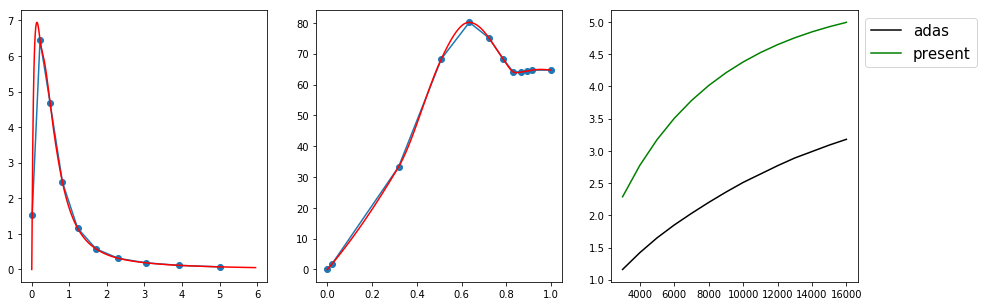

j= 1 type= 1


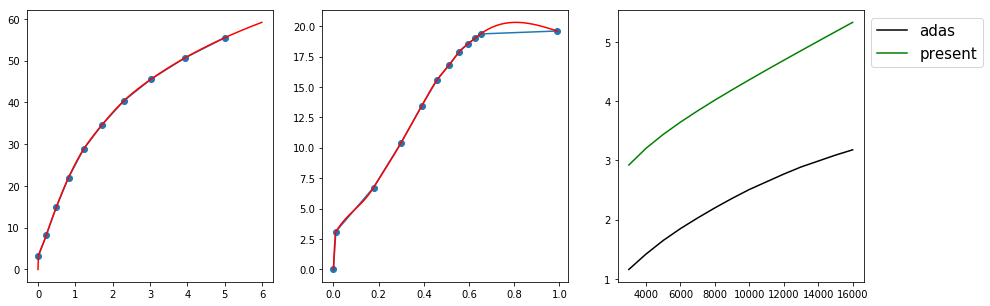

j= 2 type= 3


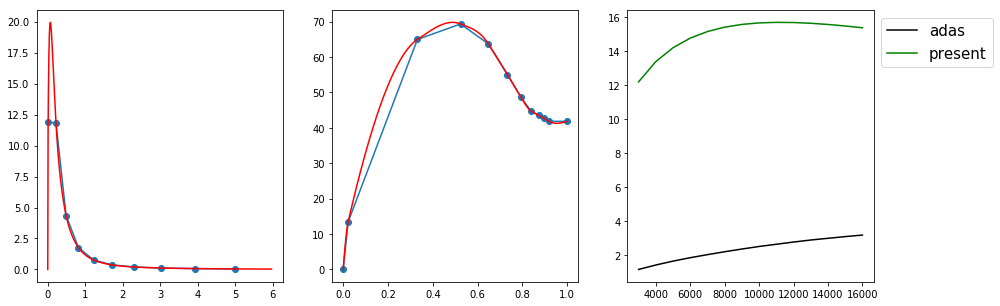

j= 3 type= 3


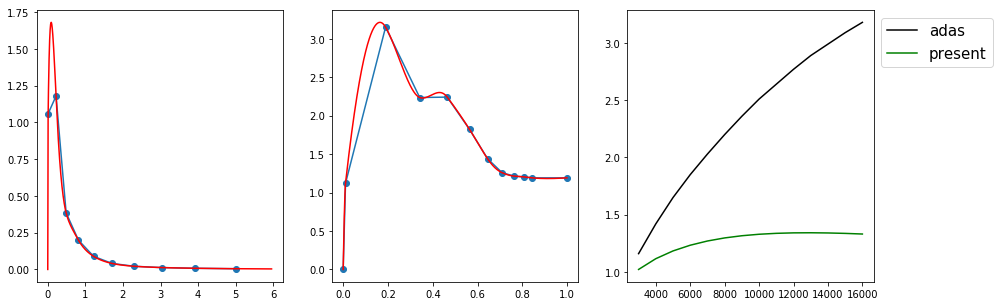

j= 4 type= 1


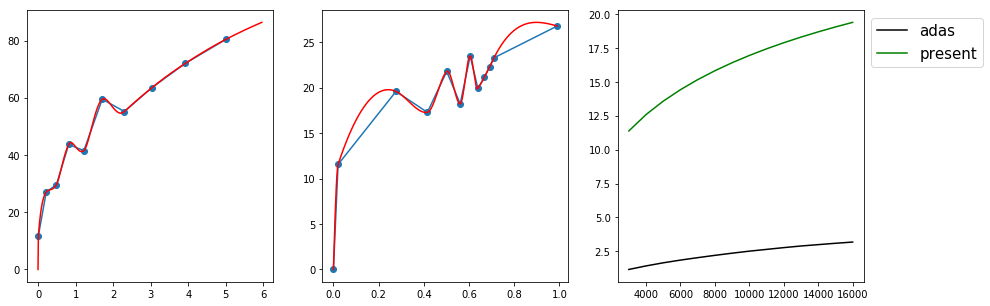

j= 5 type= 4


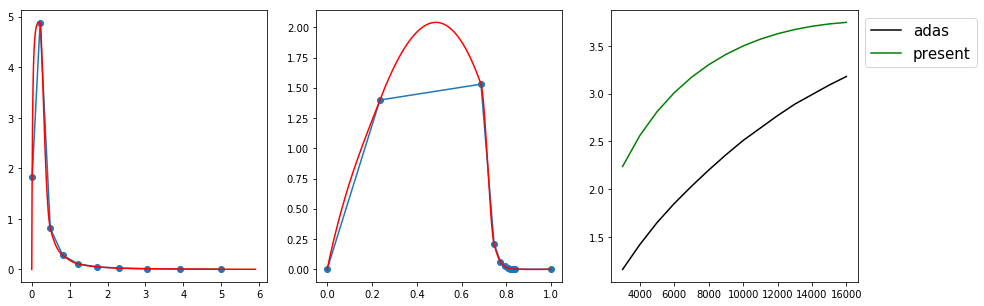

j= 6 type= 2


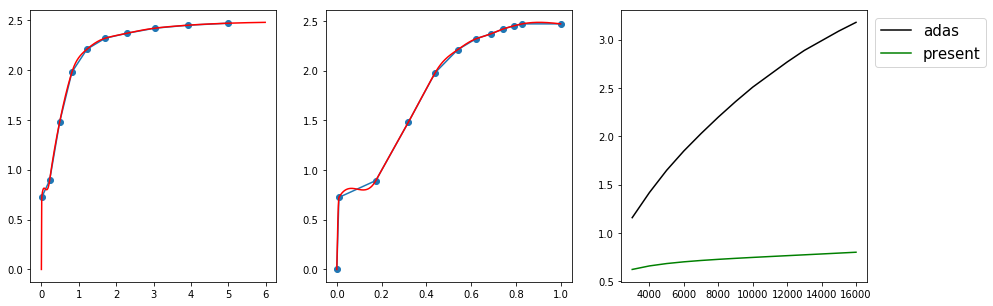

j= 7 type= 3


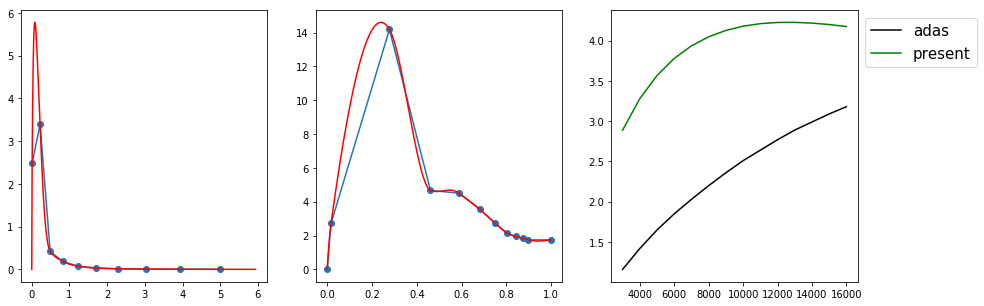

j= 8 type= 1


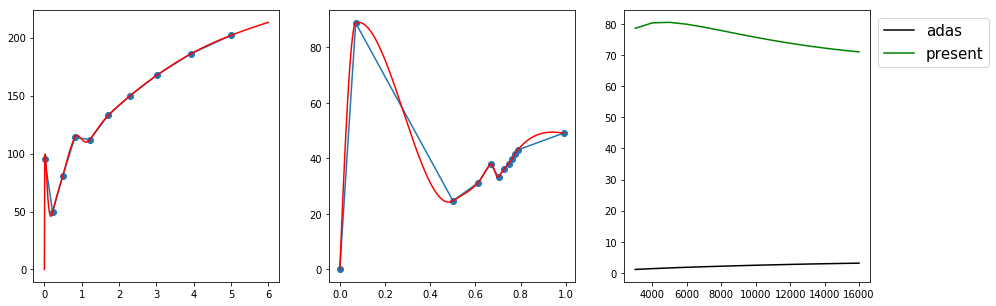

j= 9 type= 4


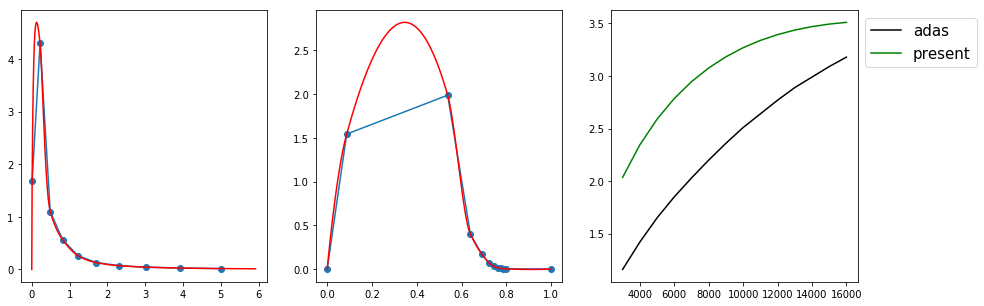

j= 10 type= 2


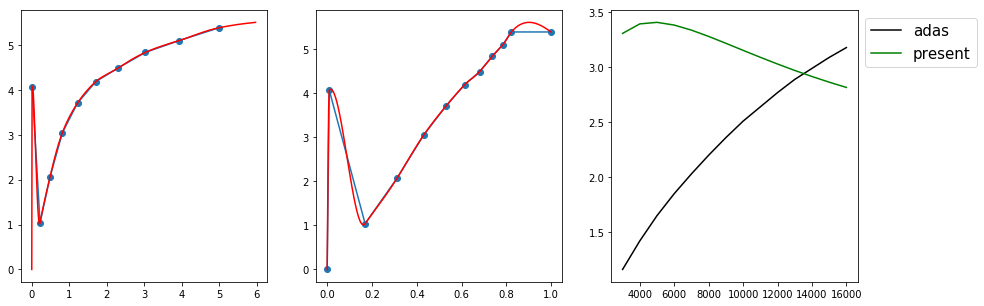

j= 11 type= 3


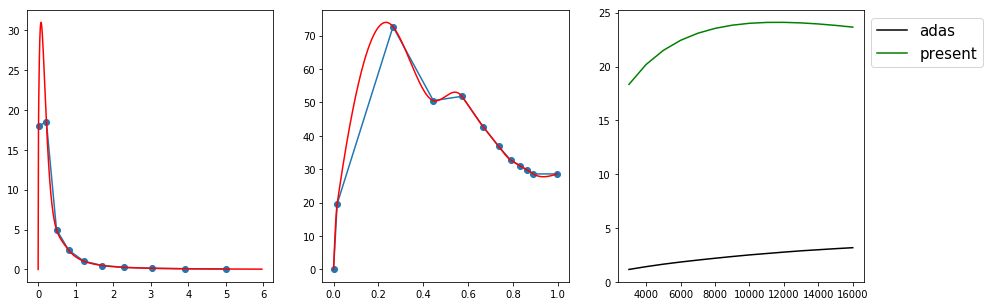

j= 12 type= 1


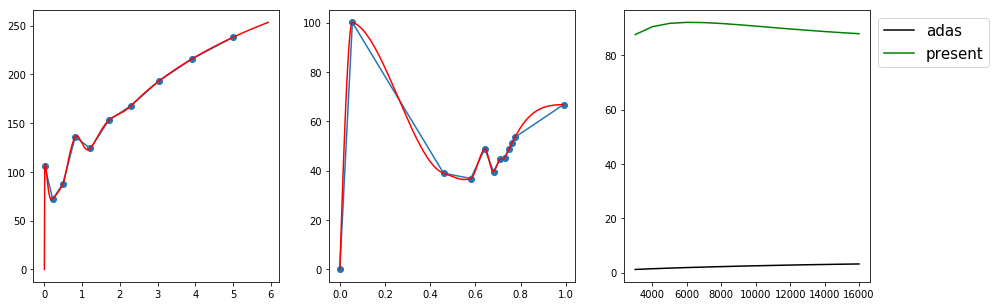

j= 13 type= 3


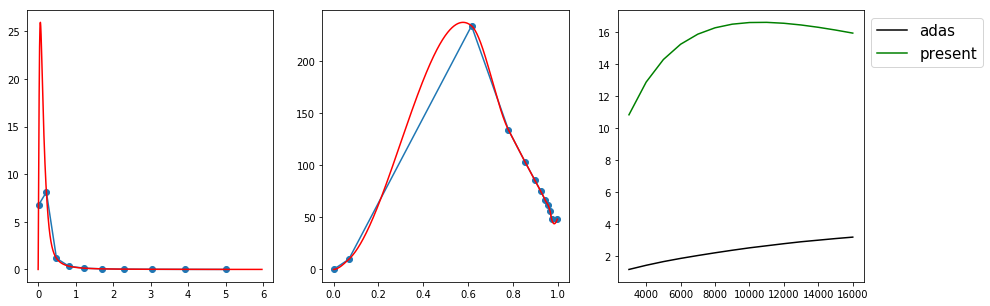

j= 14 type= 2


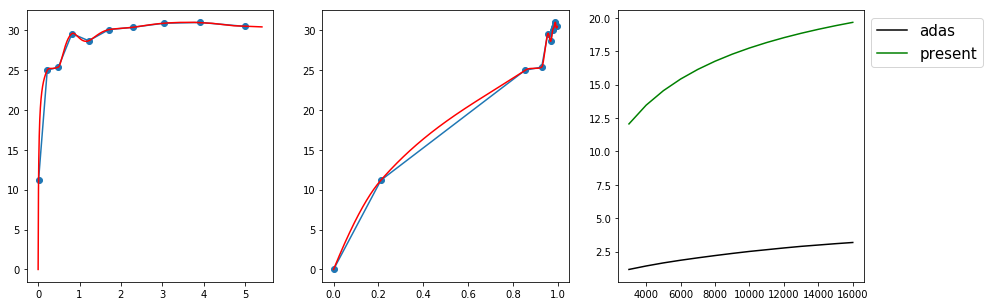

j= 15 type= 3


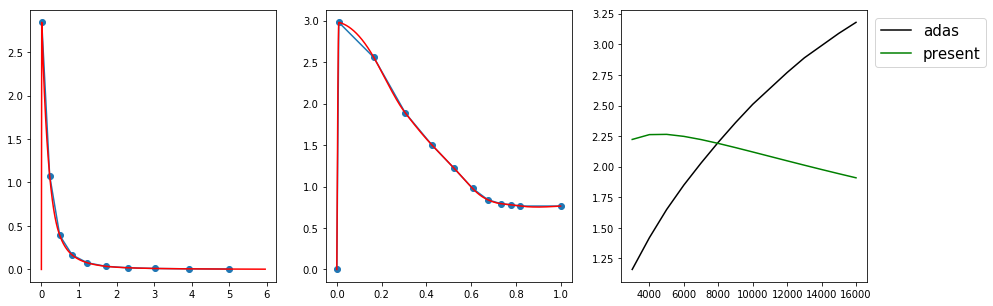

j= 16 type= 2


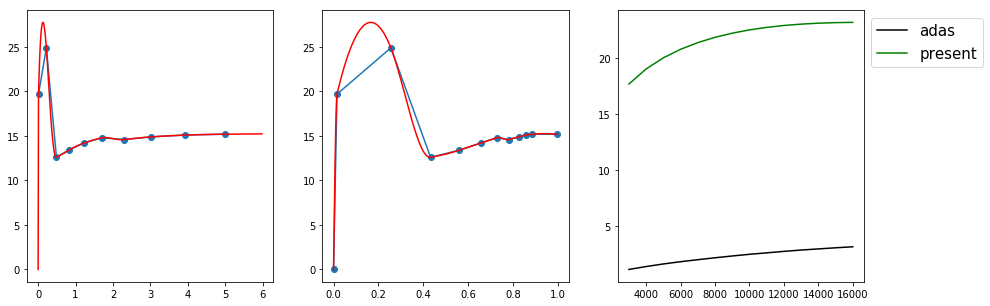

j= 17 type= 3


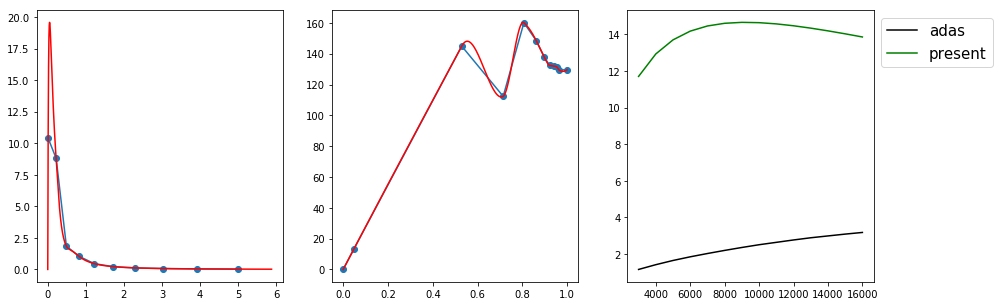

j= 18 type= 1


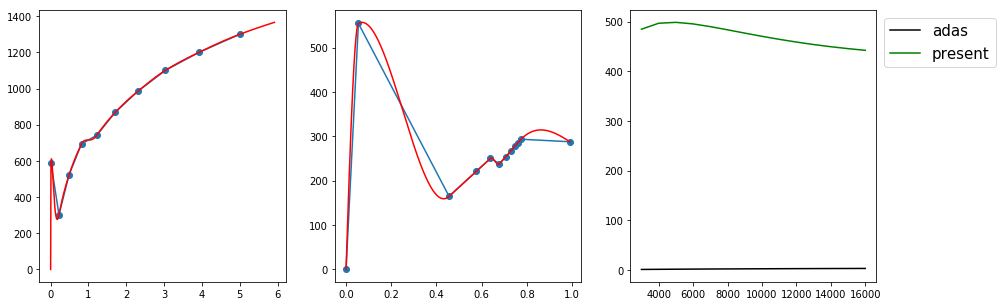

j= 19 type= 4


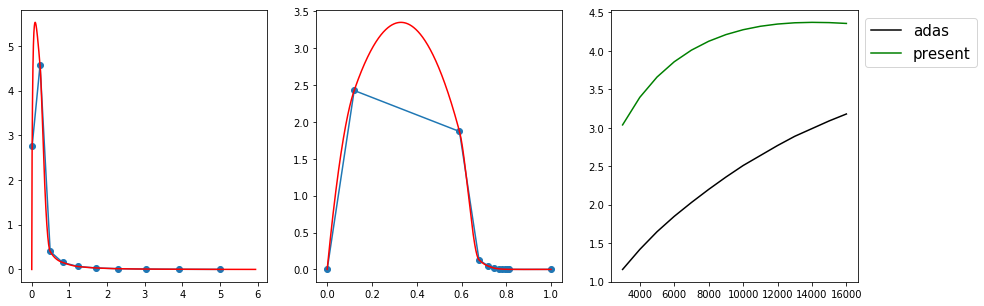

j= 20 type= 4


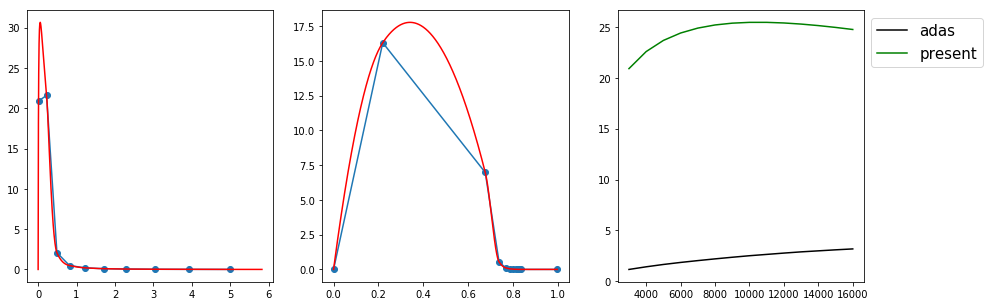

j= 21 type= 3


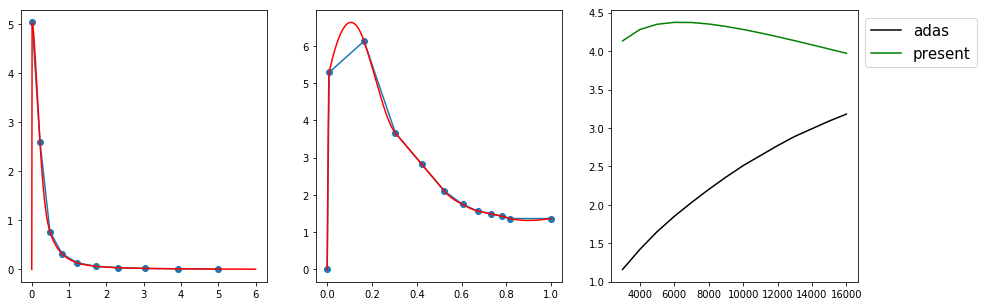

j= 22 type= 1


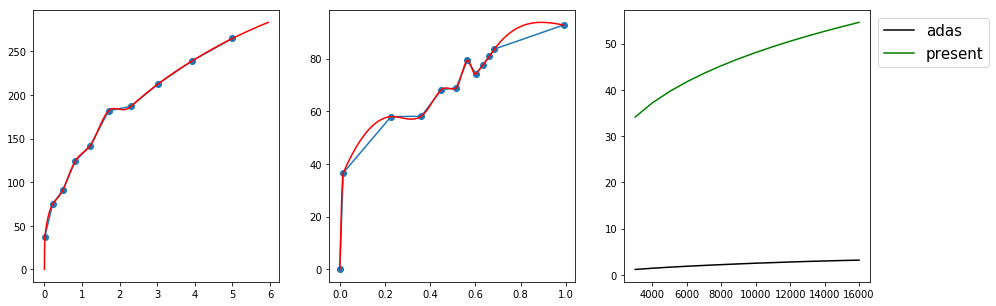

j= 23 type= 3


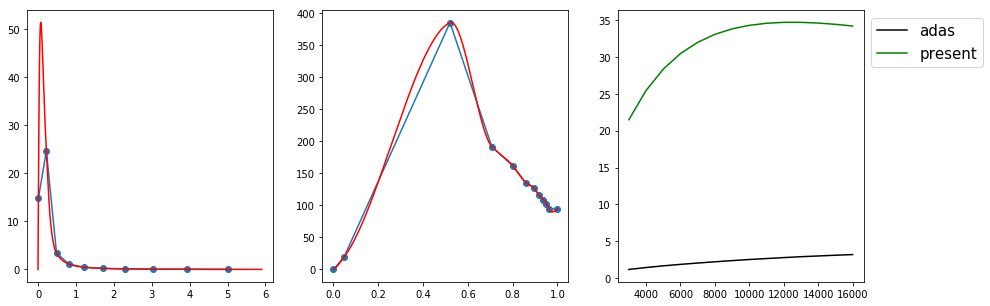

j= 24 type= 2


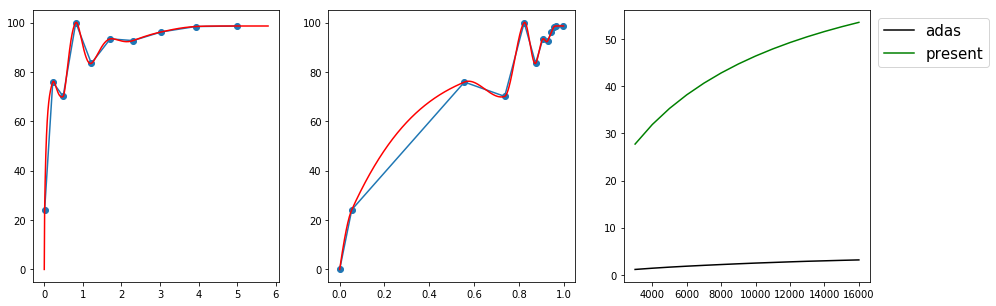

j= 25 type= 4


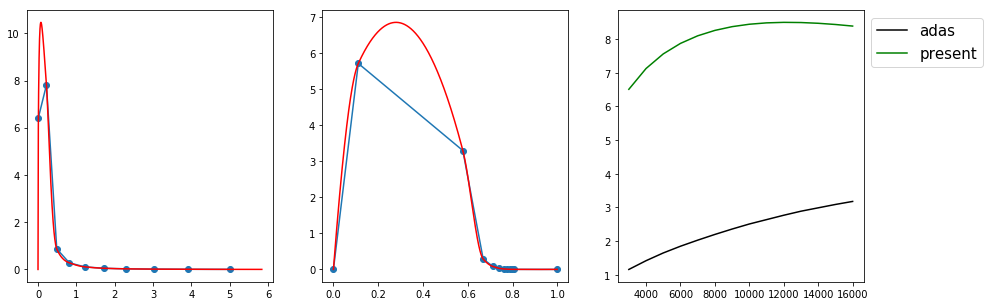

j= 26 type= 4


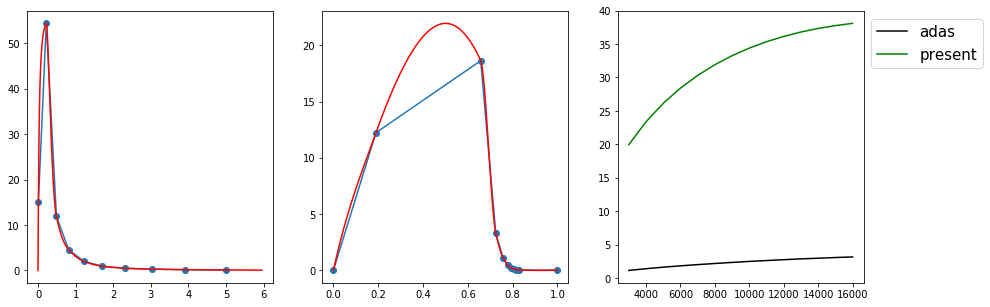

j= 27 type= 4


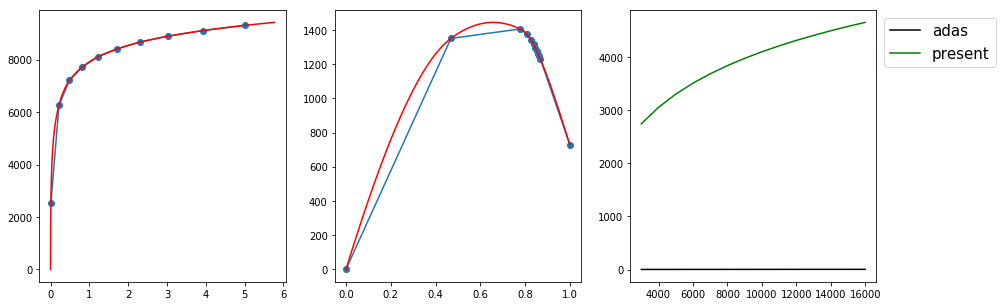

j= 28 type= 1


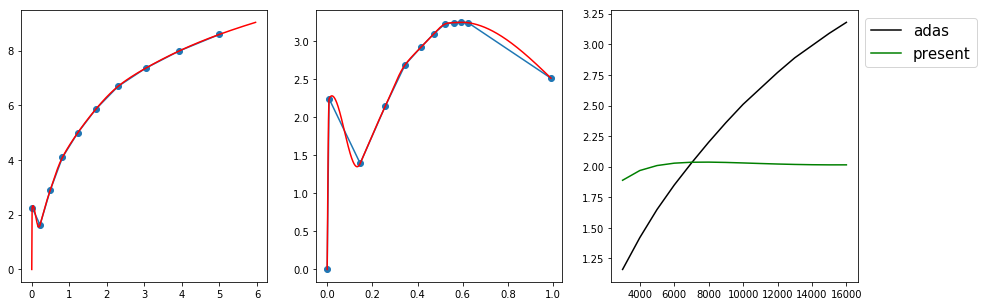

j= 29 type= 3


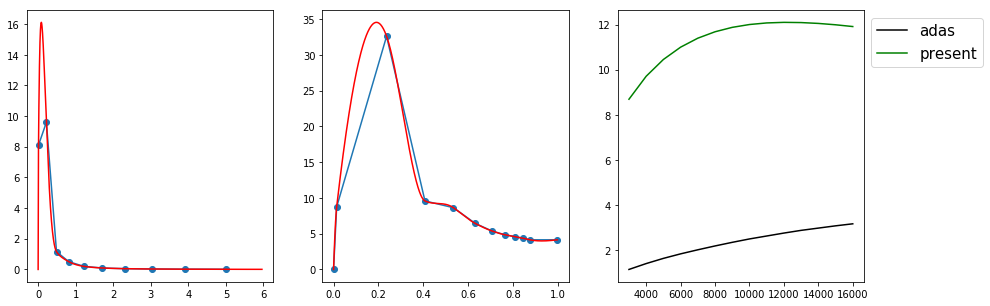

j= 30 type= 2


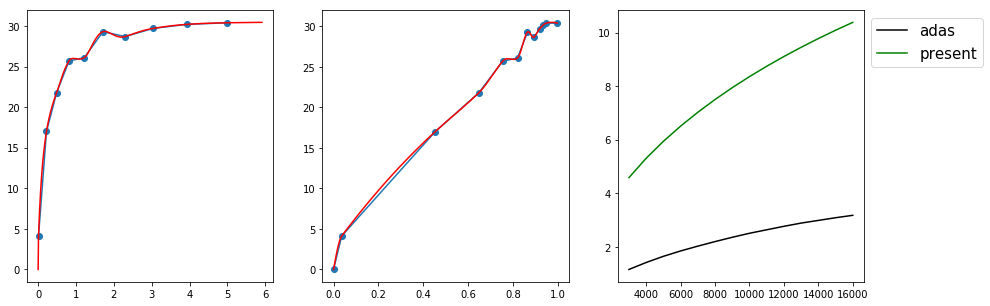

j= 31 type= 3


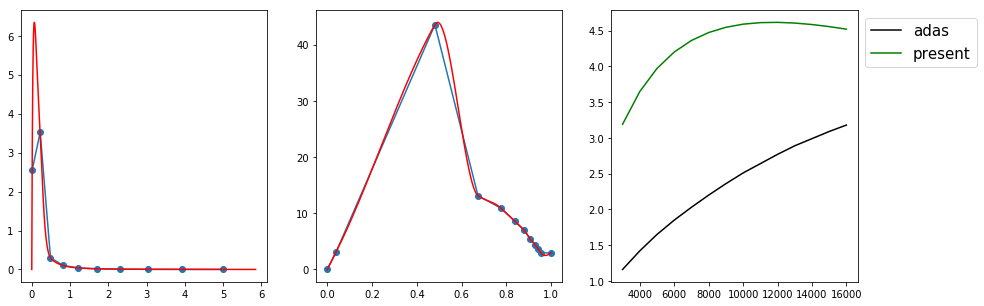

j= 32 type= 1


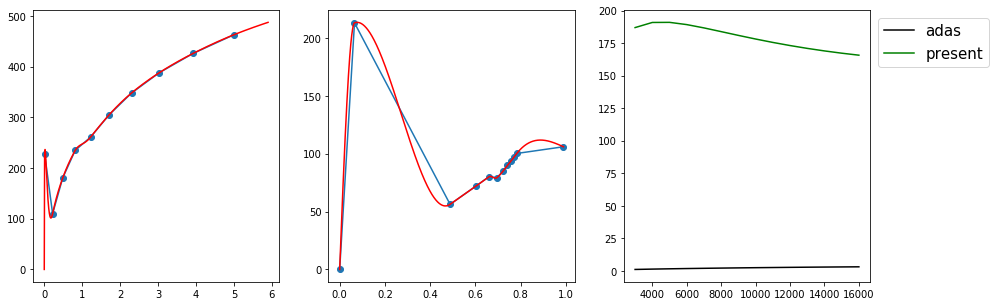

j= 33 type= 1


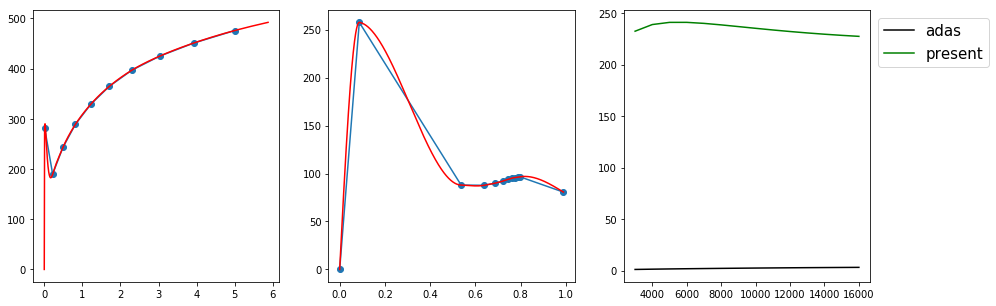

j= 34 type= 2


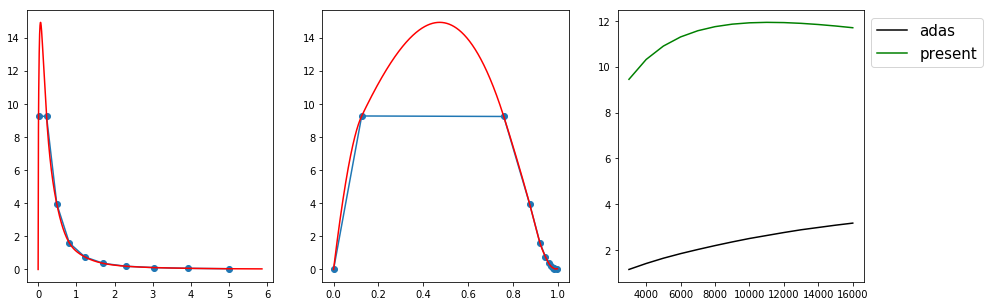

j= 35 type= 4


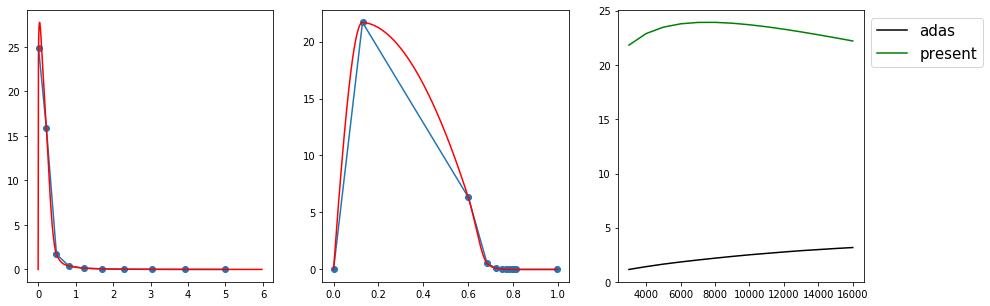

j= 36 type= 3


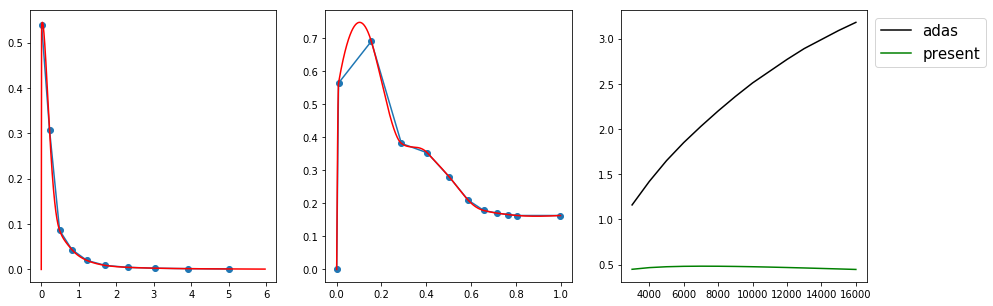

j= 37 type= 1


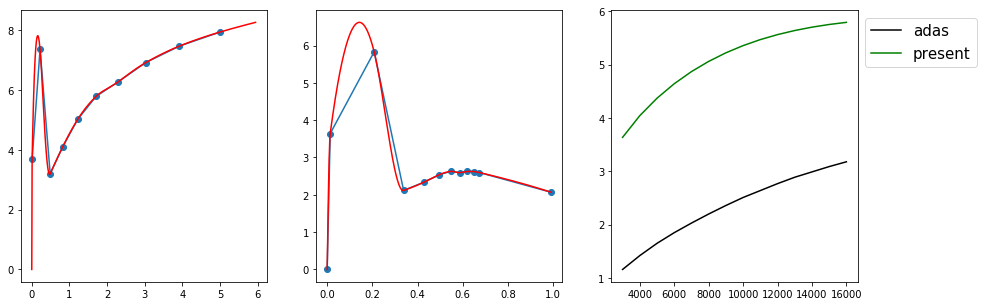

j= 38 type= 3


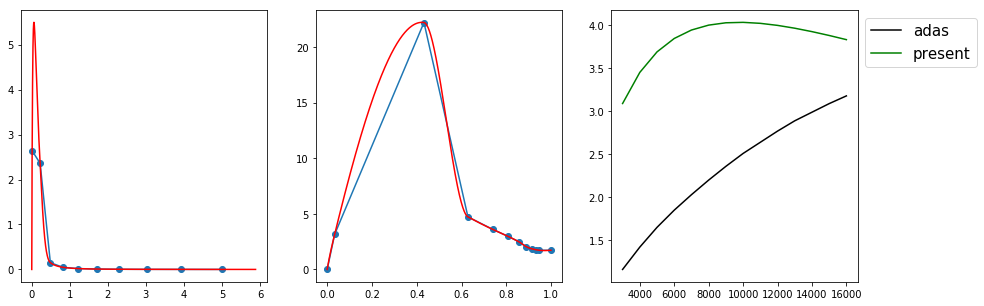

j= 39 type= 2


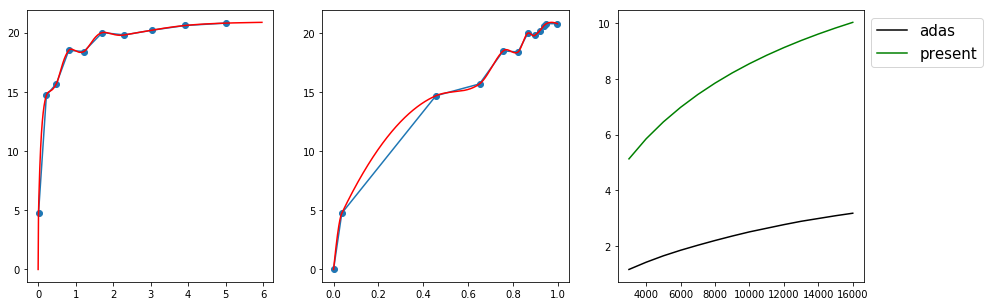

j= 40 type= 3


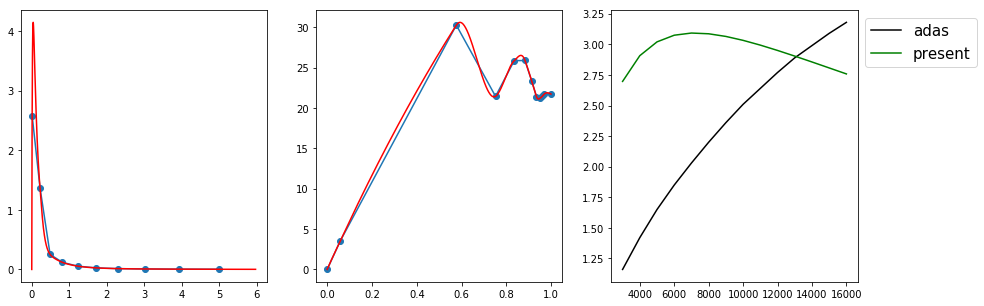

j= 41 type= 3


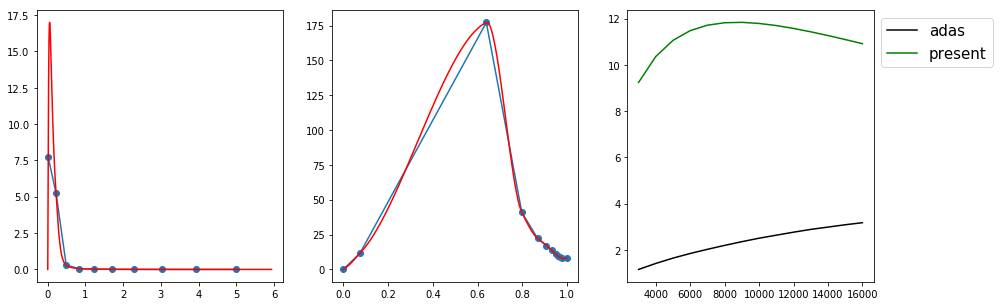

j= 42 type= 1


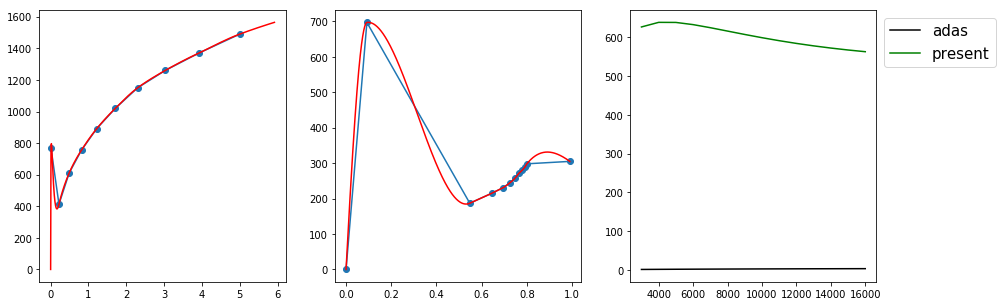

j= 43 type= 2


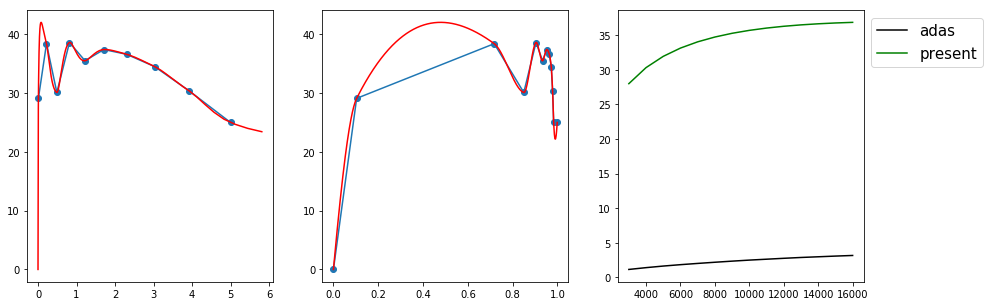

j= 44 type= 4


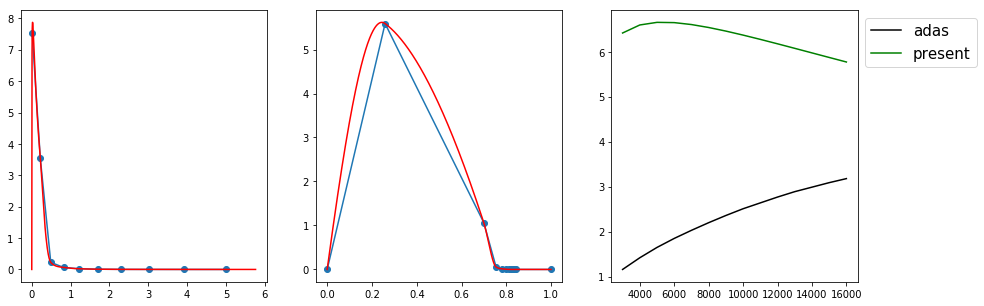

j= 45 type= 4


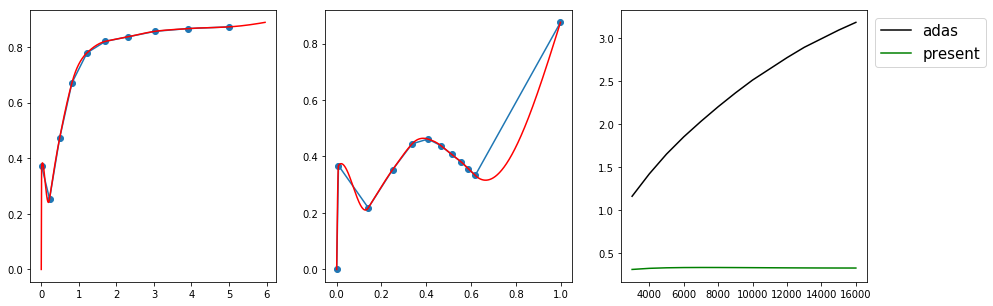

j= 46 type= 3


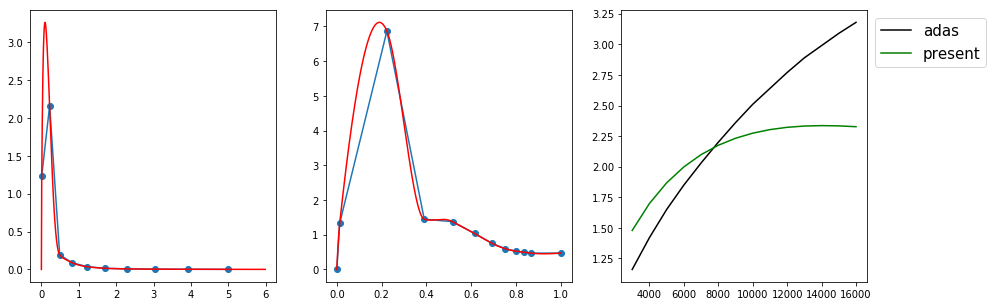

j= 47 type= 1


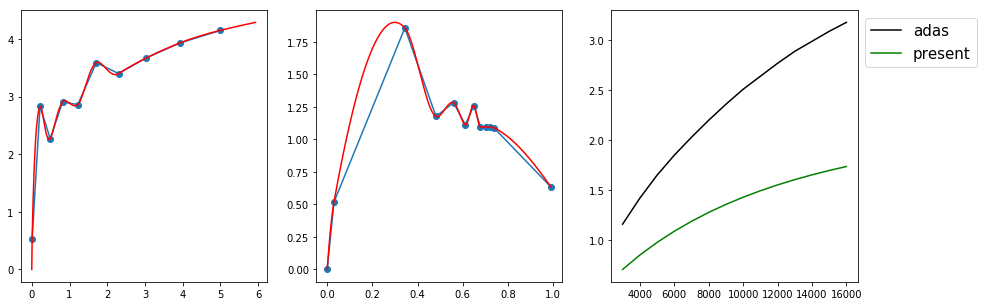

j= 48 type= 3


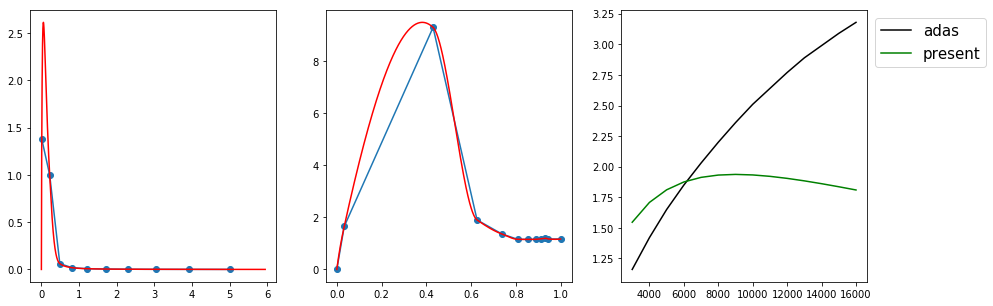

j= 49 type= 2


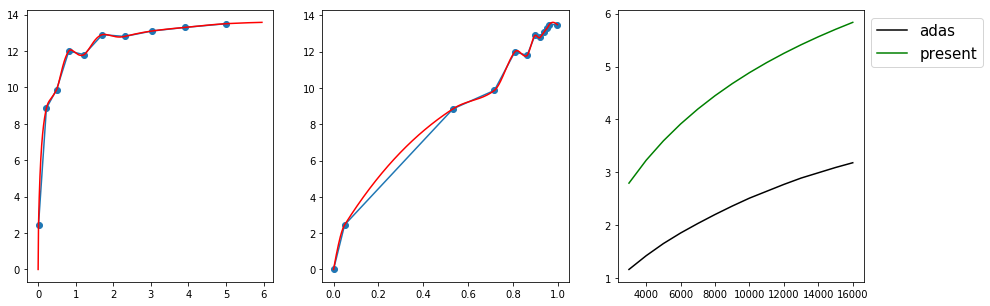

j= 50 type= 2


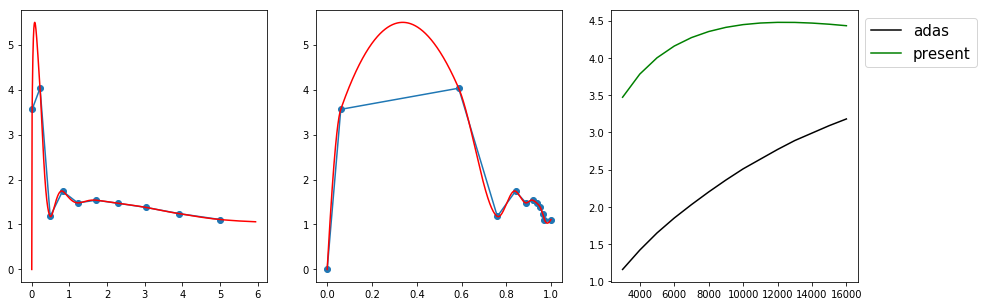

j= 51 type= 3


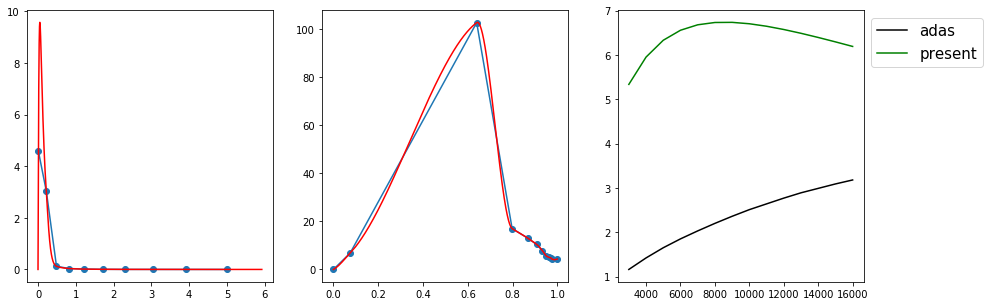

j= 52 type= 3


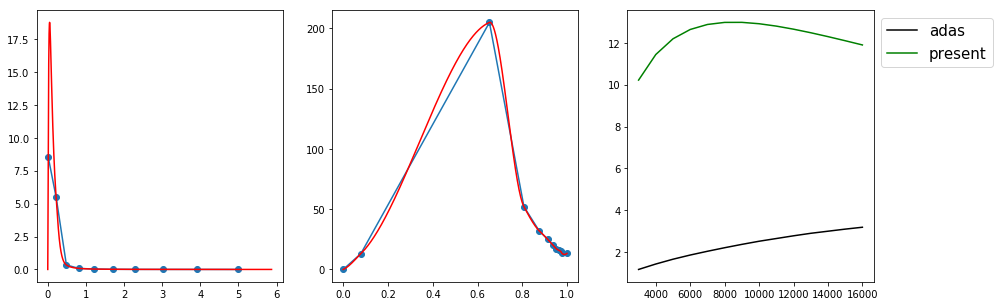

j= 53 type= 1


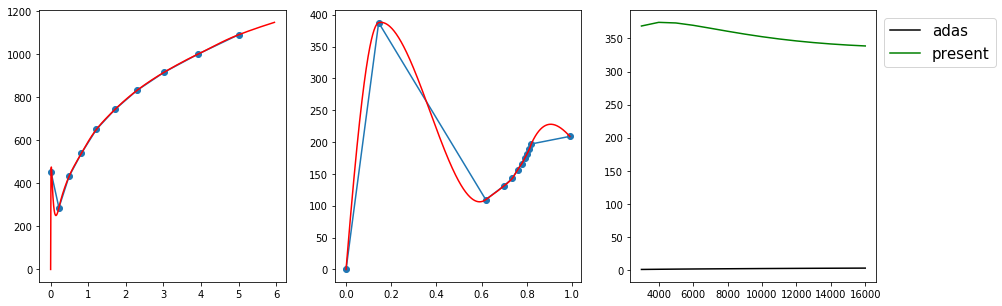

j= 54 type= 4


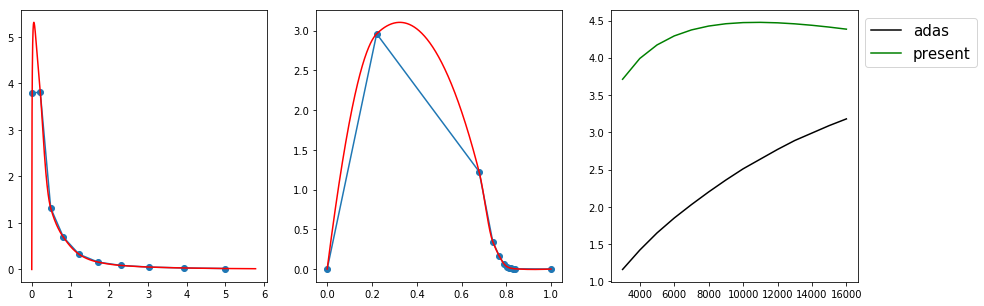

j= 55 type= 2


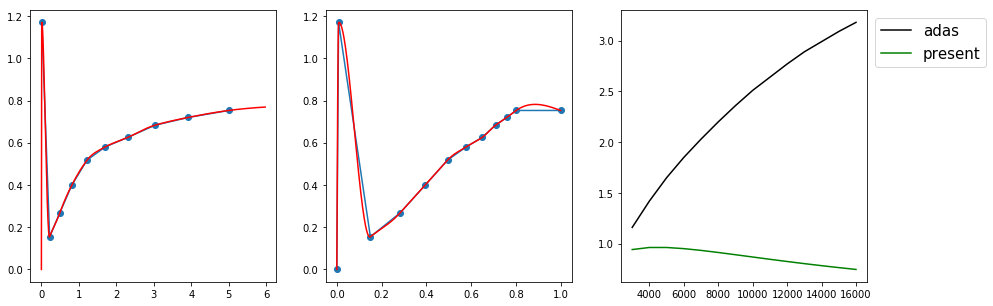

j= 56 type= 3


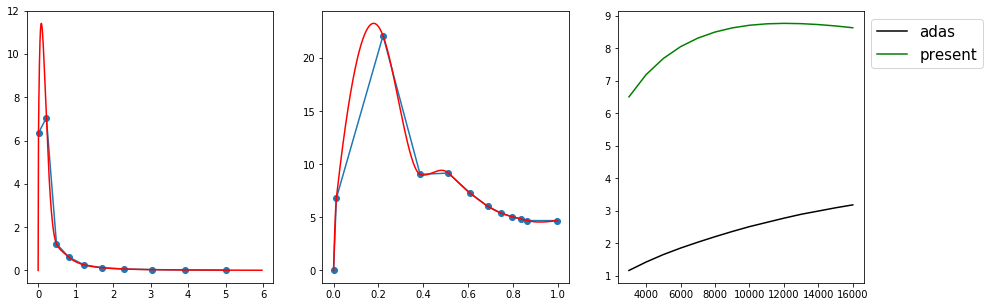

j= 57 type= 1


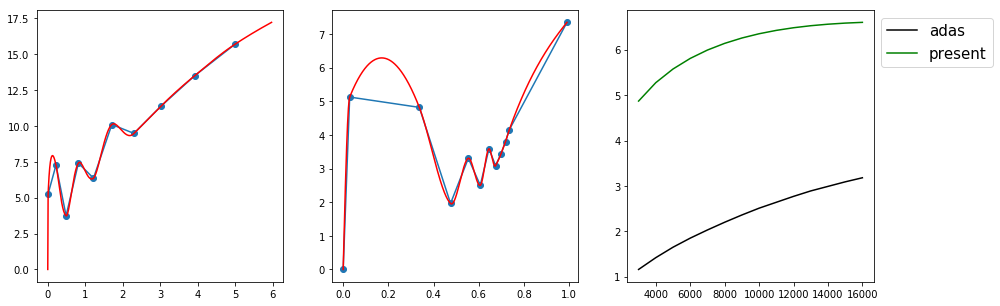

j= 58 type= 3


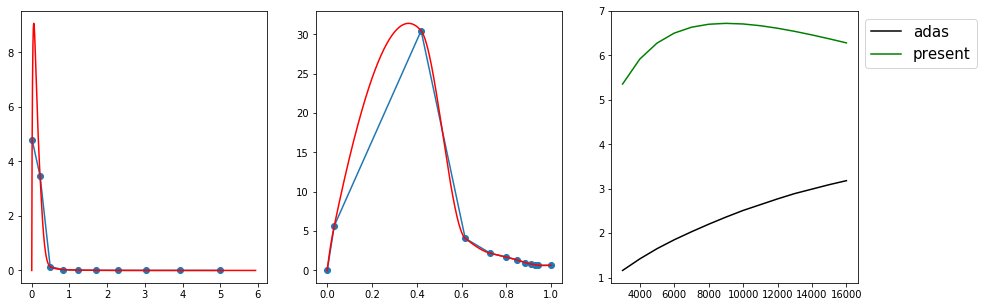

j= 59 type= 2


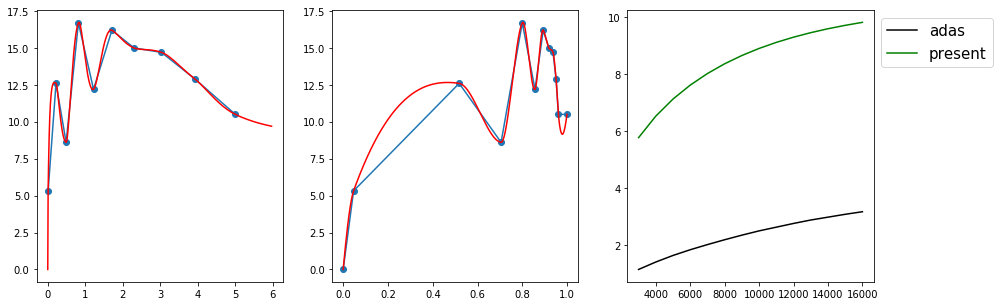

j= 60 type= 2


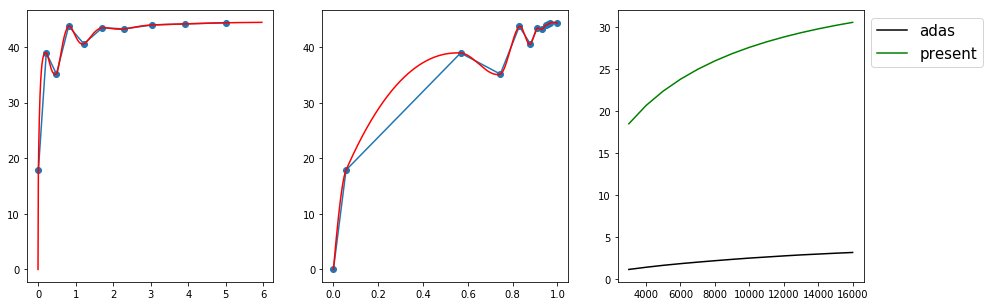

j= 61 type= 3


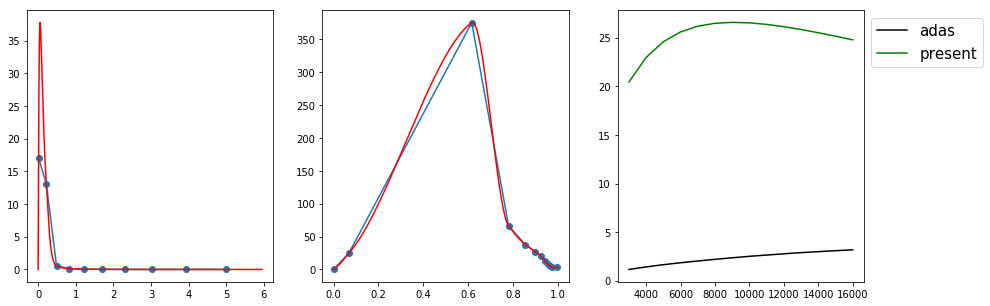

j= 62 type= 3


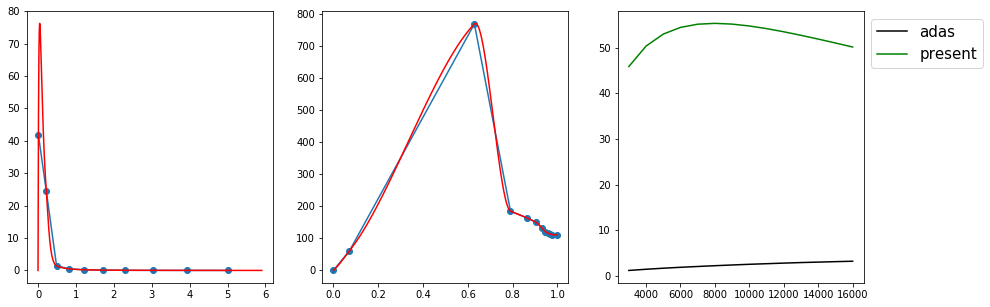

j= 63 type= 1


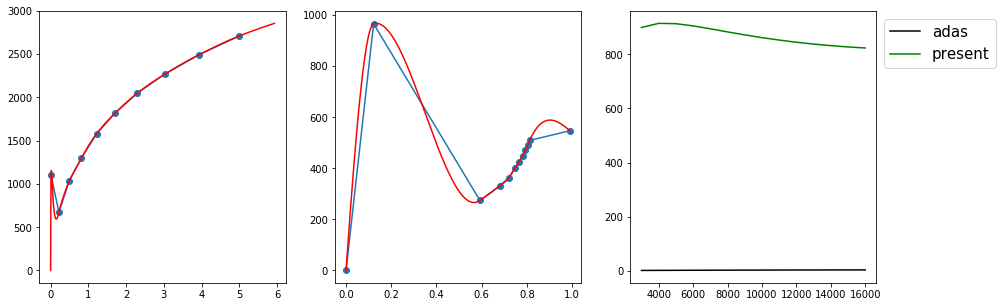

j= 64 type= 4


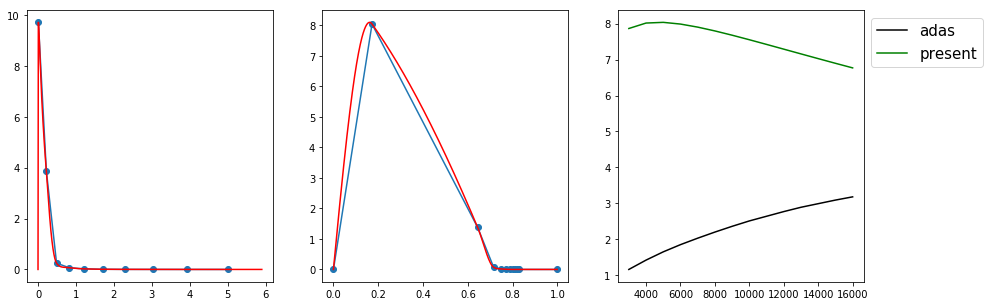

j= 65 type= 2


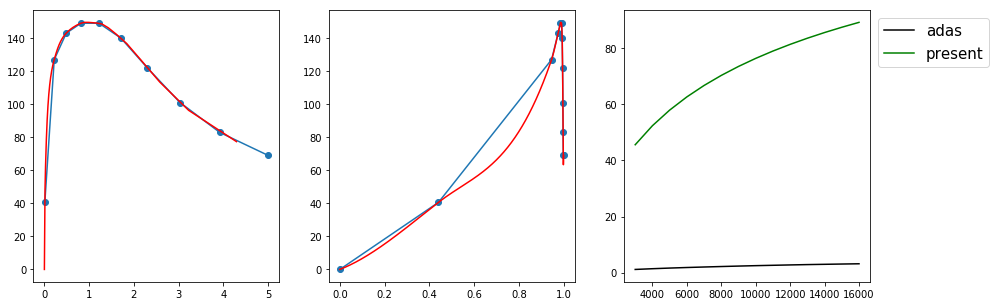

j= 66 type= 3


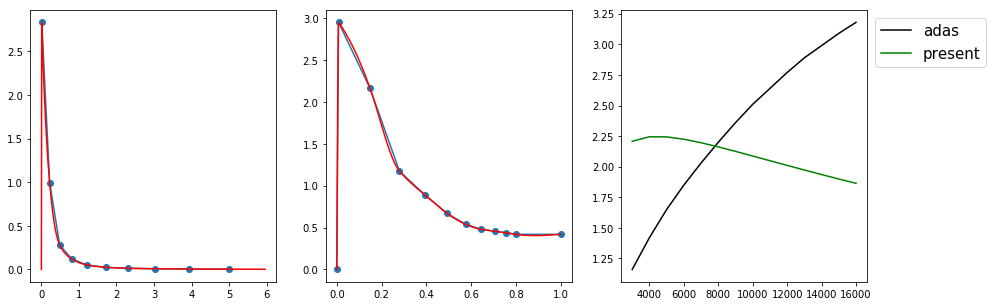

j= 67 type= 1


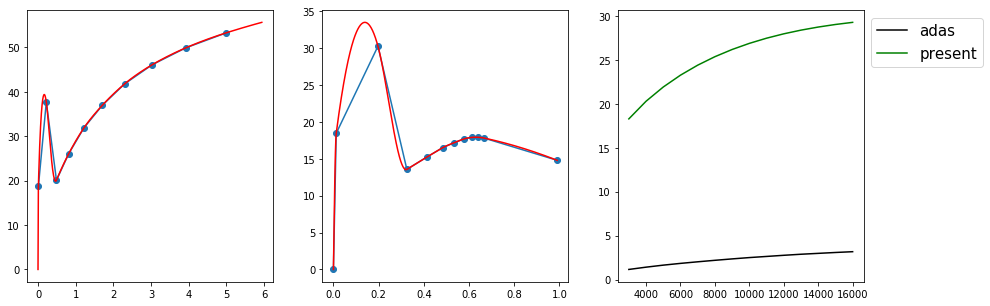

j= 68 type= 3


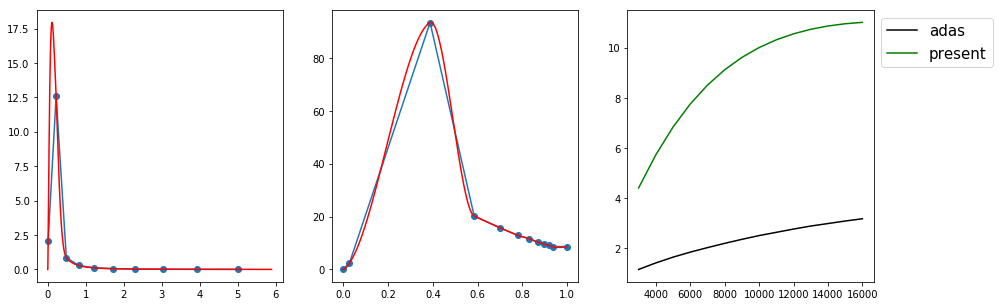

j= 69 type= 2


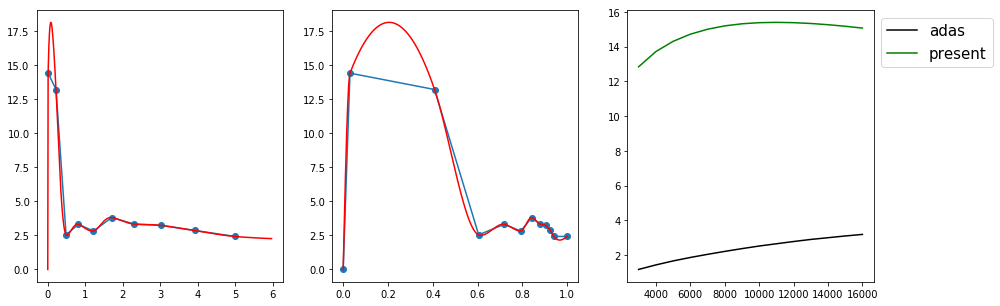

j= 70 type= 3


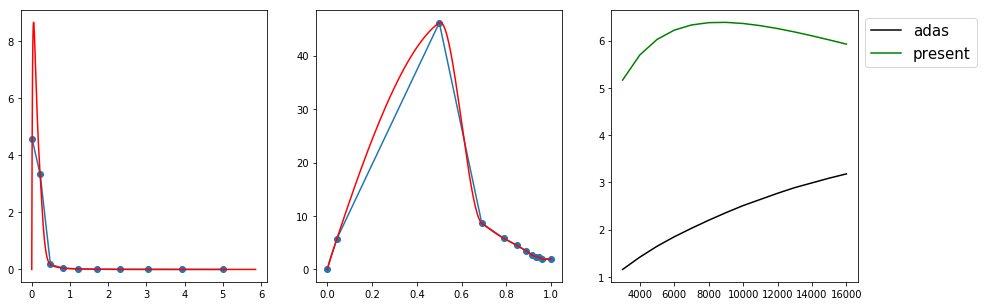

j= 71 type= 3


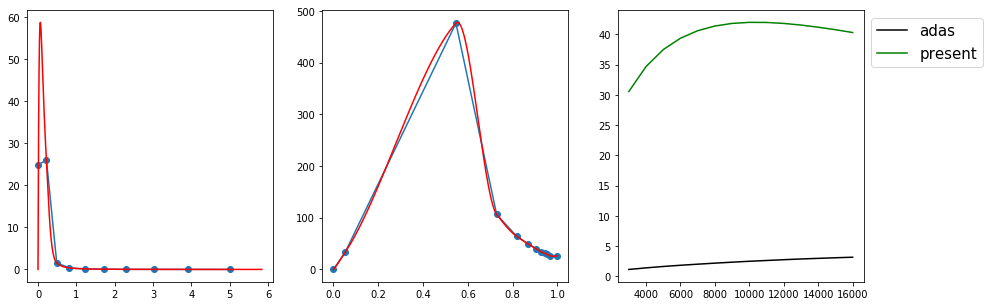

j= 72 type= 1


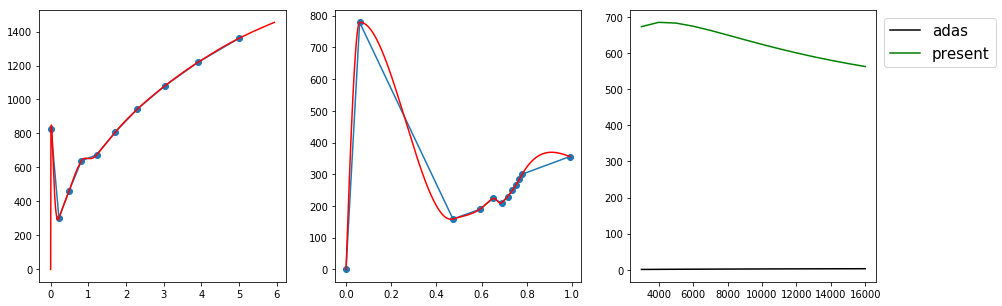

j= 73 type= 2


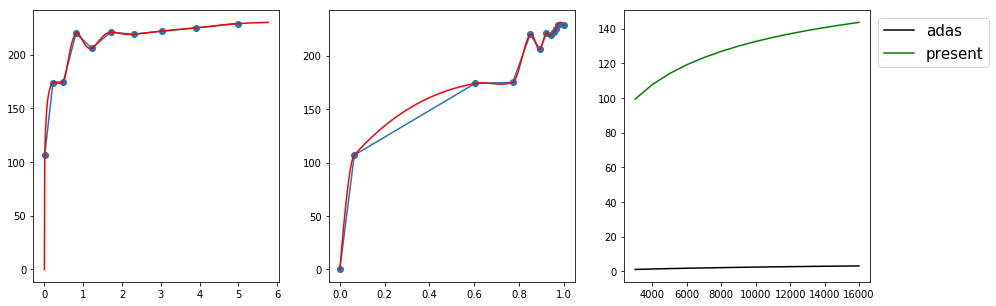

j= 74 type= 3


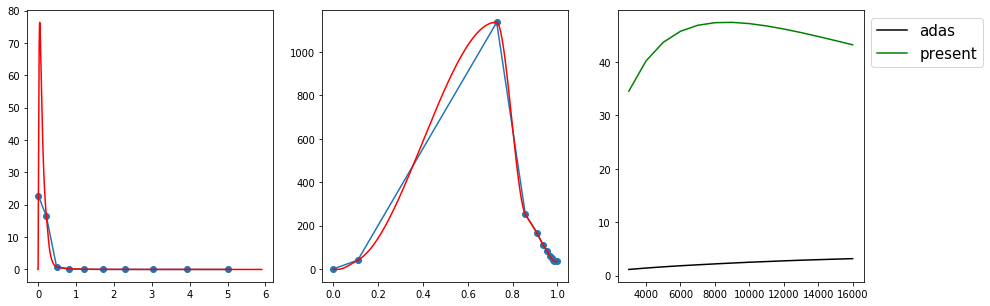

j= 75 type= 2


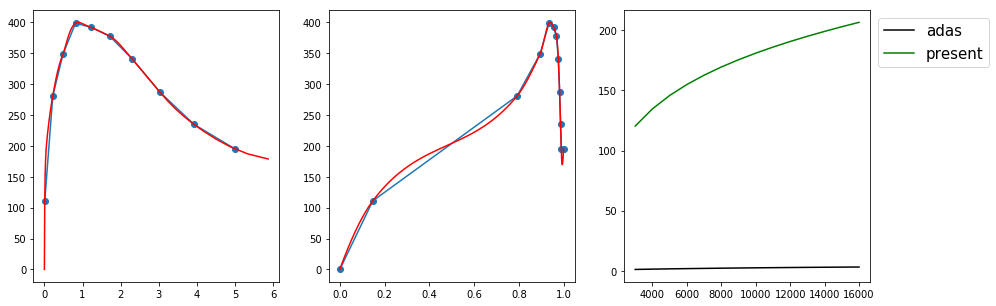

j= 76 type= 4


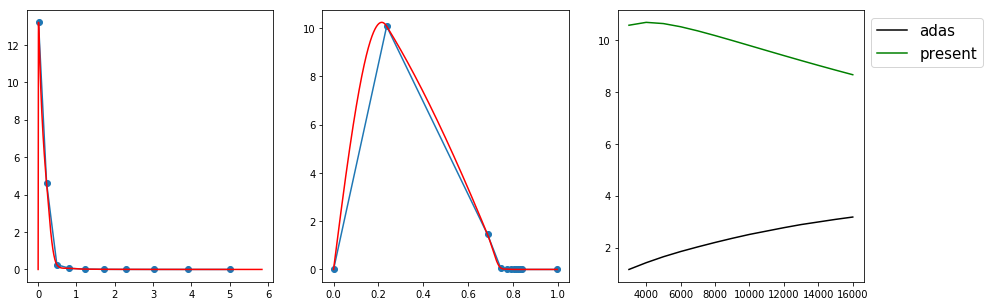

j= 77 type= 2


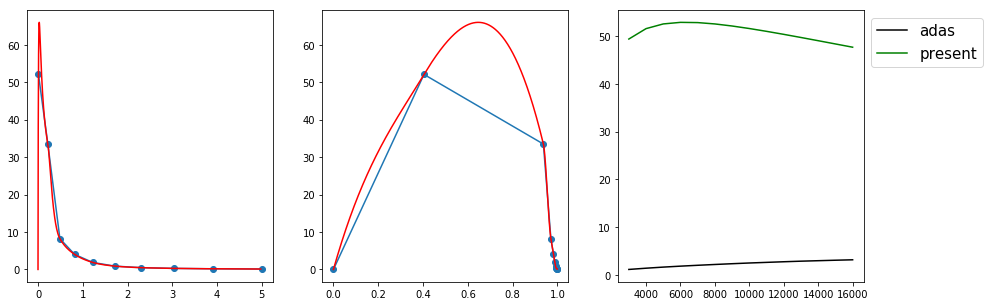

j= 78 type= 3


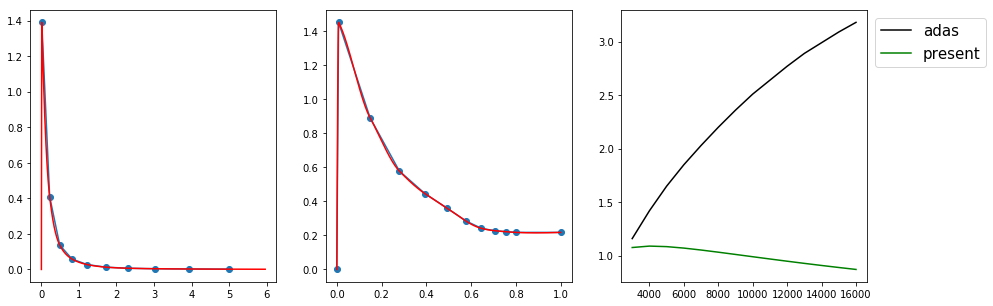

j= 79 type= 2


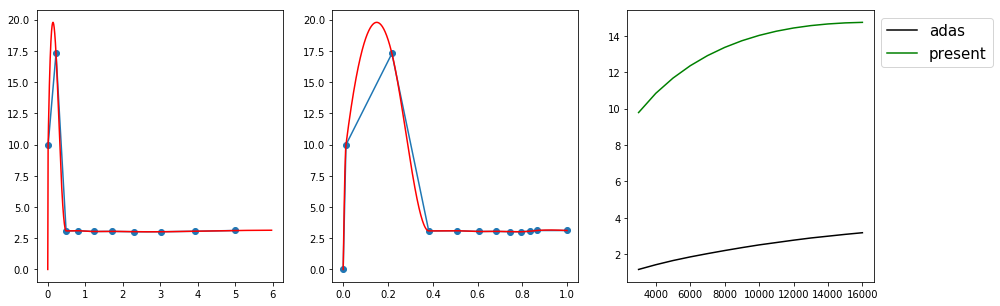

j= 80 type= 3


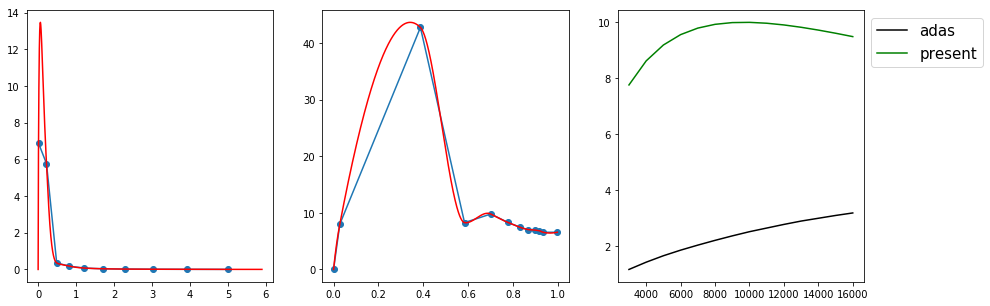

j= 81 type= 1


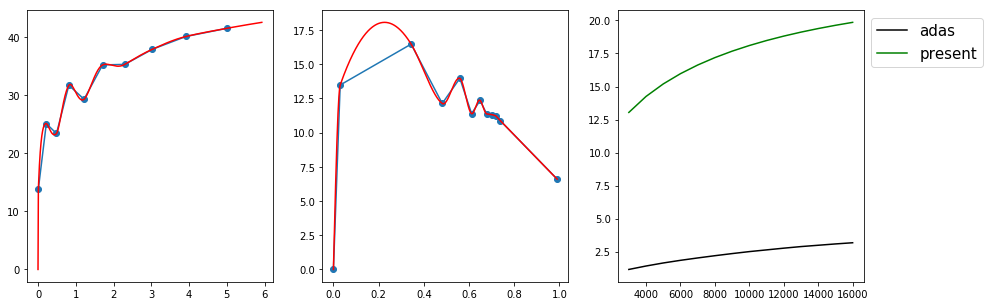

j= 82 type= 3


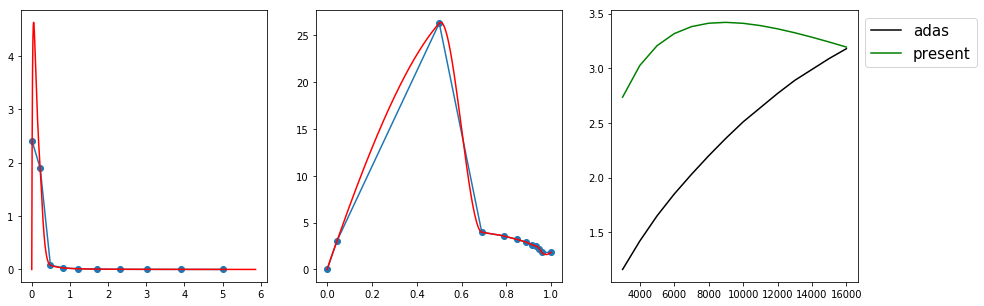

j= 83 type= 3


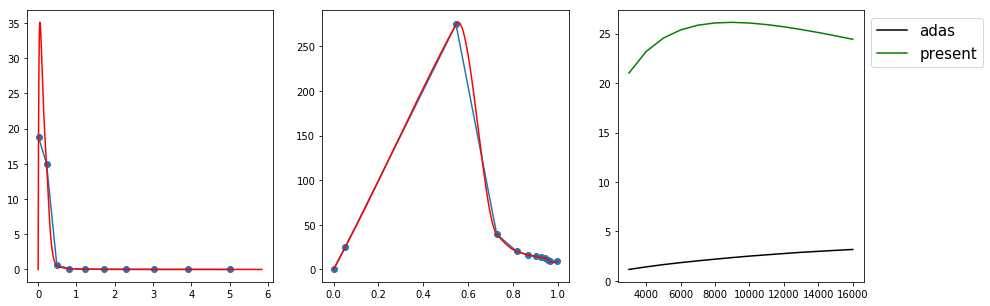

j= 84 type= 2


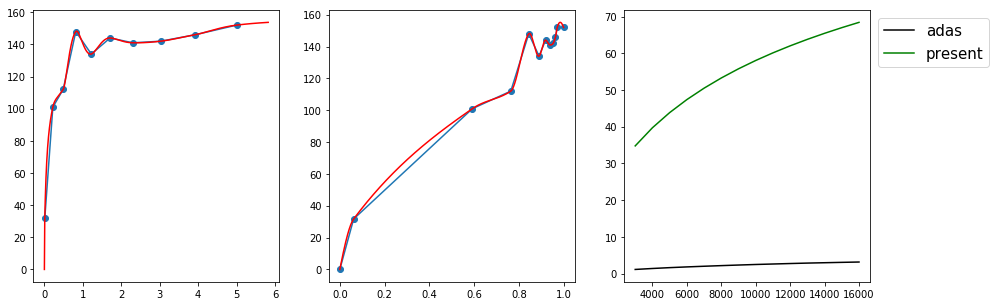

j= 85 type= 4


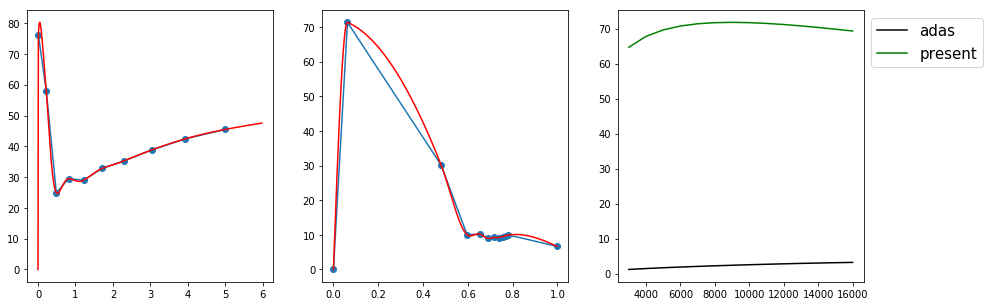

j= 86 type= 3


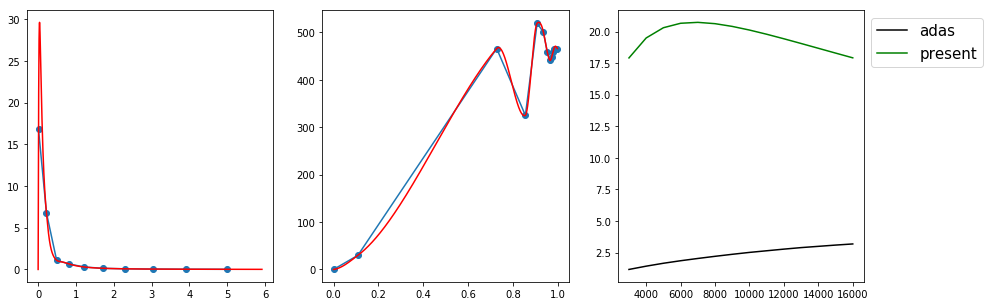

j= 87 type= 1


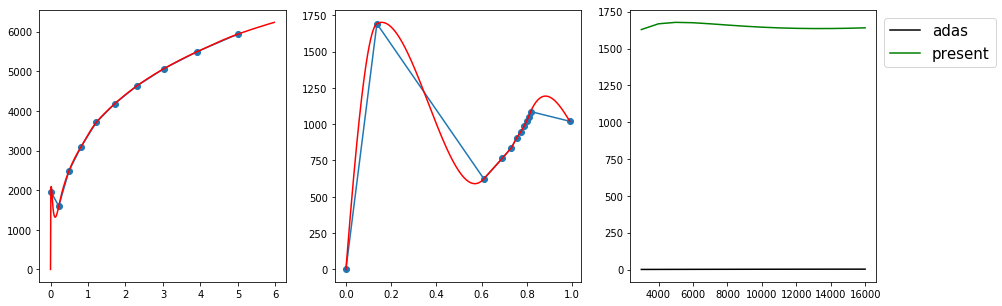

j= 88 type= 4


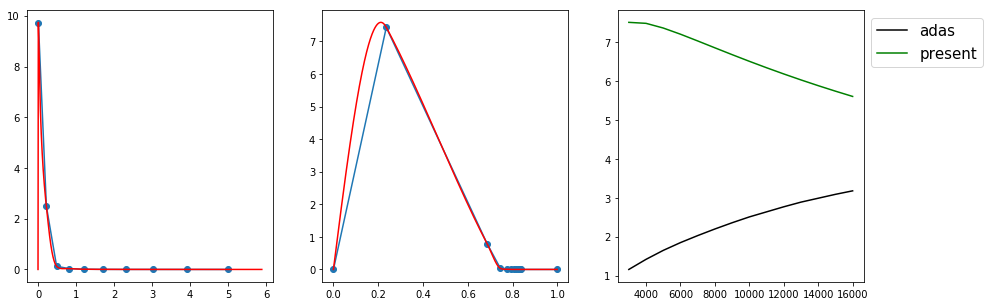

j= 89 type= 4


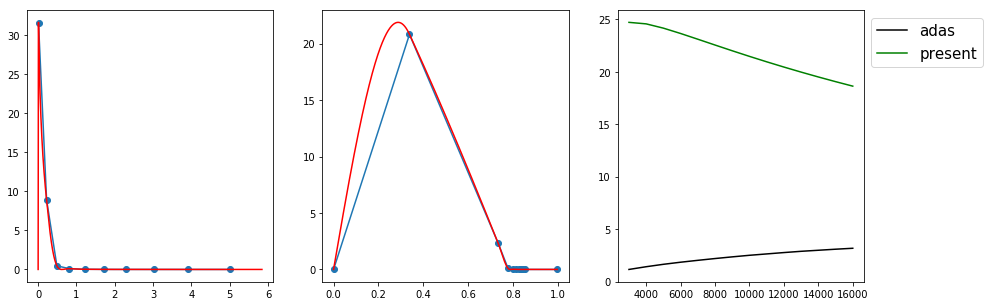

j= 90 type= 4


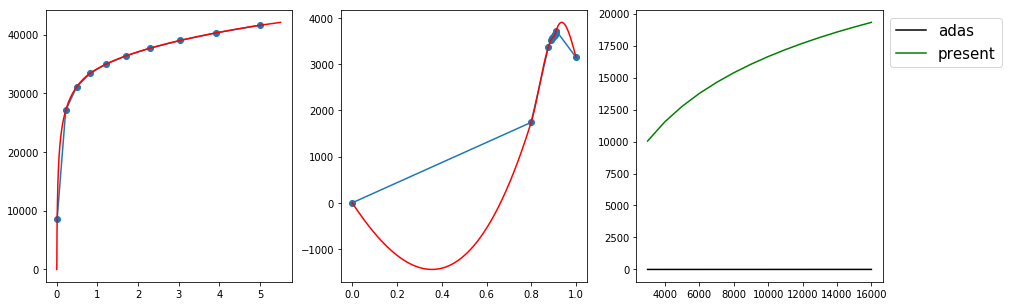

j= 91 type= 3


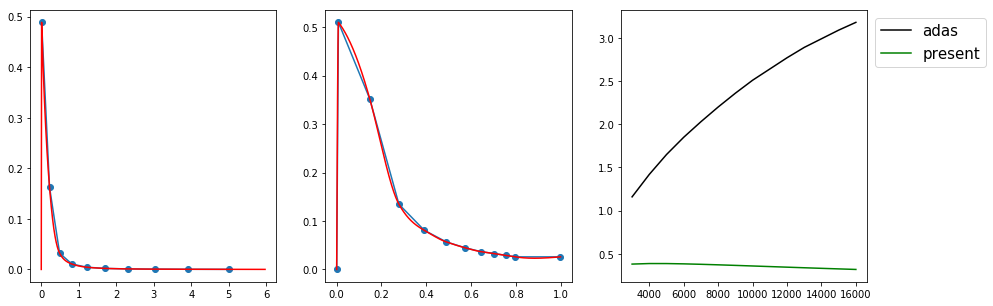

j= 92 type= 2


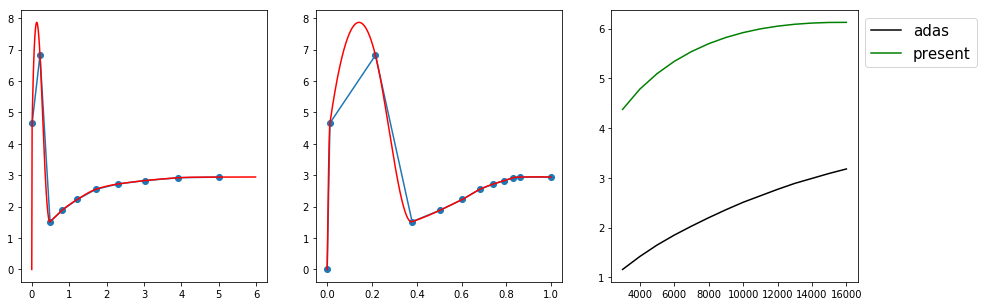

j= 93 type= 3


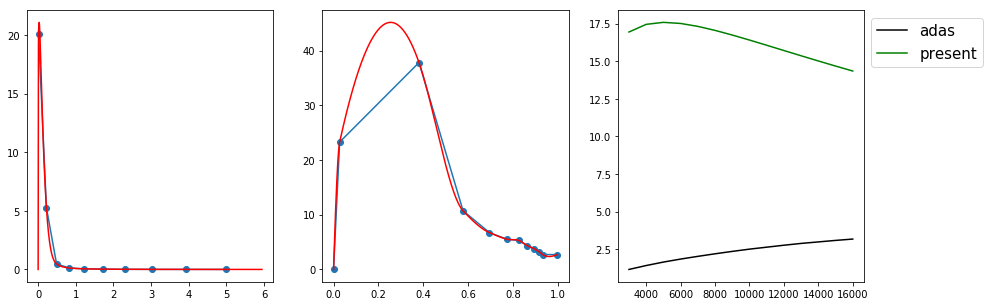

j= 94 type= 2


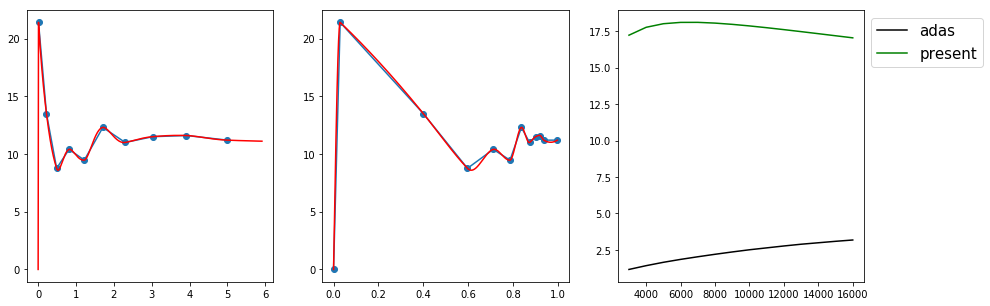

j= 95 type= 3


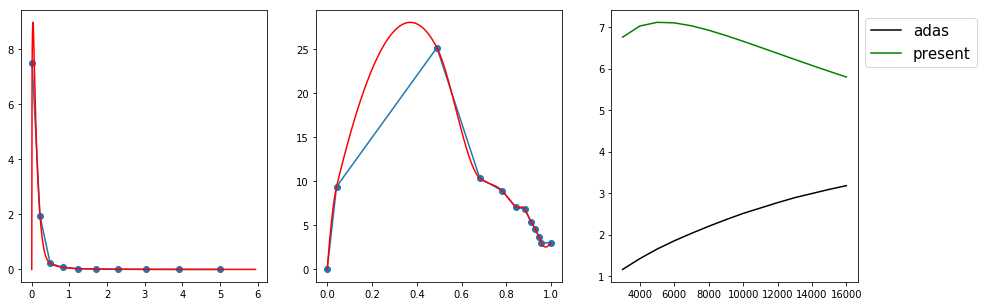

j= 96 type= 3


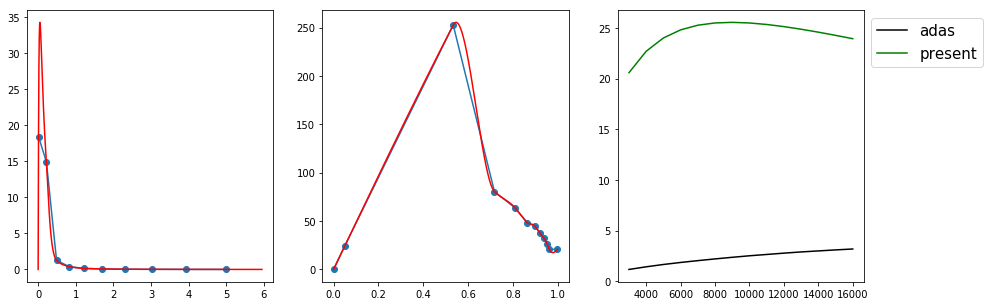

j= 97 type= 2


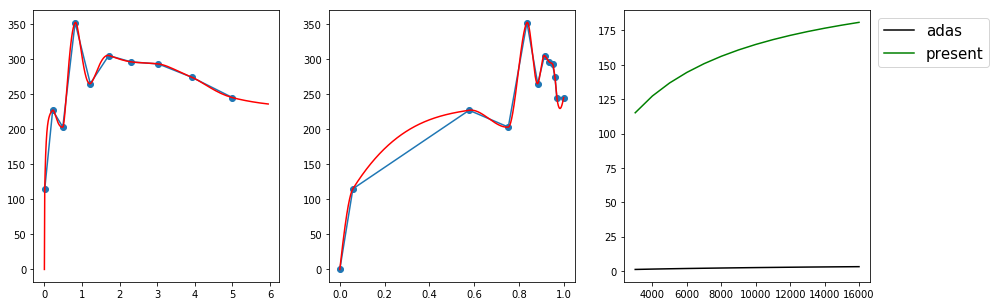

j= 98 type= 1


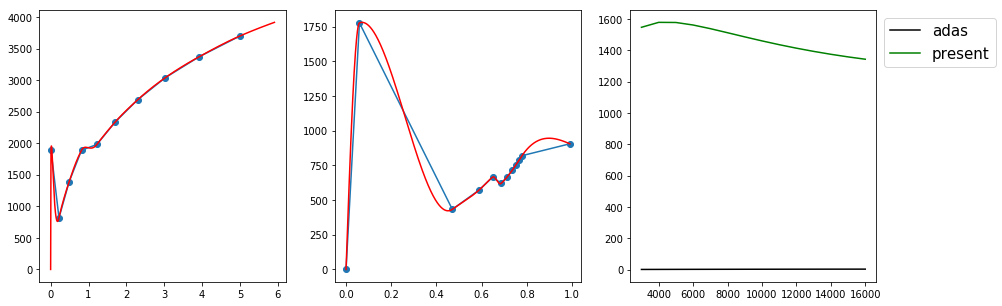

j= 99 type= 3


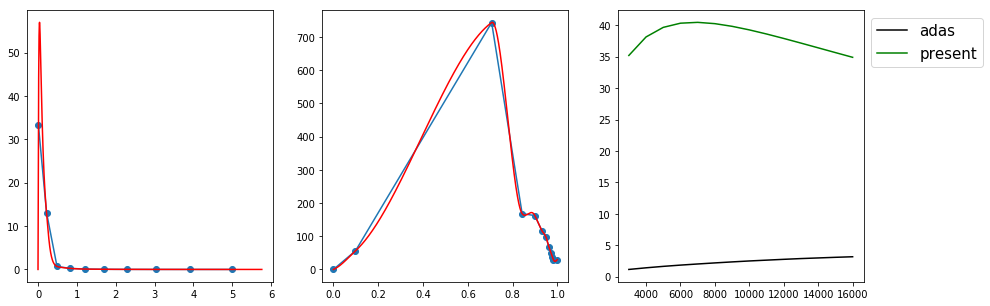

In [59]:
for j in range(100):
    ntype=int(omg.loc[j]['type'])
    print("j=",j,"type=",ntype)
    Aki,gk,gi,eik,fik=data_trans(j,omg,levels)
    # copy data into aux variables
    yomg=omg.loc[j][3:-2].values
    xener=np.array(ener)
    # map into BT-space
    x,y=map_BTspace(xener,eik,yomg,ntype)
    # make spline of x y in BT-space
    nx=len(x)
    x_new=np.linspace(x[0],x[nx-1], npts)
    y_new=interp_omg(nx,x,y,x_new,'akima')
    # mapping back from BT-space
    enerpp,omgpp=mapback_BTspace(ntype,eik,x_new,y_new)
    # compute effective collision strength
    yups=compute_ECS(enerpp,omgpp,ups_new)
    # plot and check data
    fig=plt.figure(figsize=(15,5))
    ax1=plt.subplot(131)
    plt.plot(xener,yomg,'o-')
    plt.plot(enerpp,omgpp,'r-')
    ax2=plt.subplot(132)
    plt.plot(x,y,'o-')
    plt.plot(x_new,y_new,'r-')
    ax3=plt.subplot(133)
    plt.plot(T,ups_prev.loc[0][3:-1],'k',label="adas")
    plt.plot(T,yups,'g-',label="present")
    plt.legend(loc='upper left',bbox_to_anchor=[1,1],fontsize=15,ncol=1)
    plt.show()

j= 100 type= 2


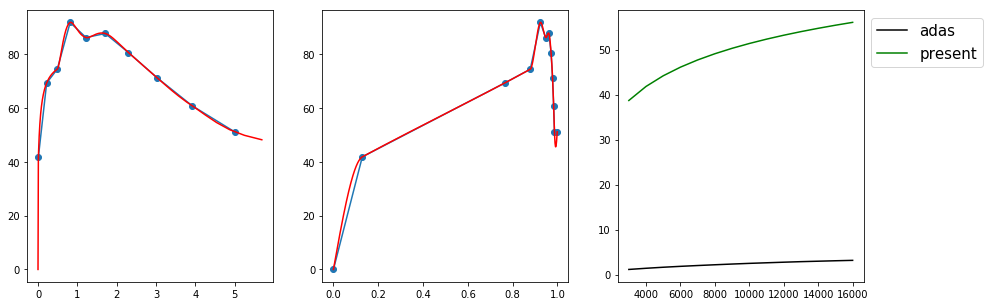

j= 101 type= 4


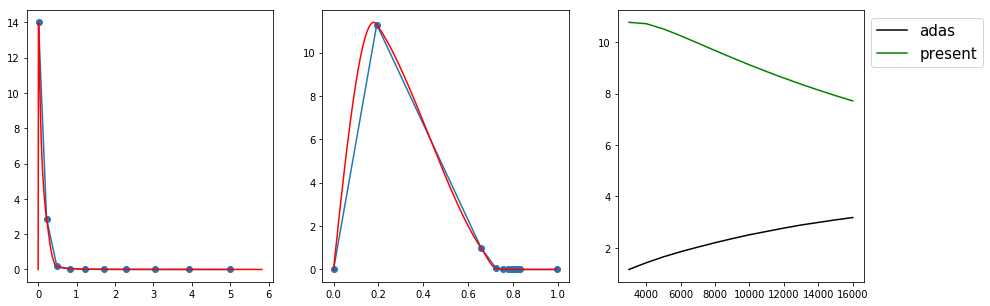

j= 102 type= 4


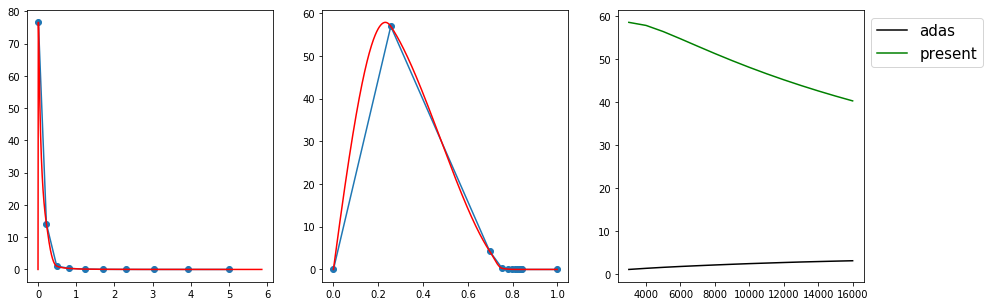

j= 103 type= 1


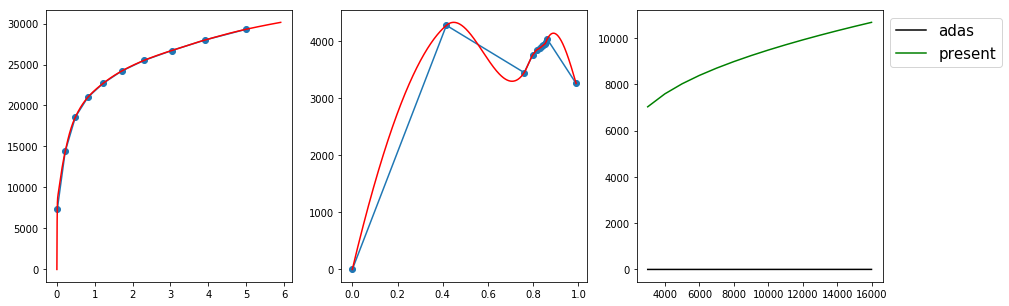

j= 104 type= 2


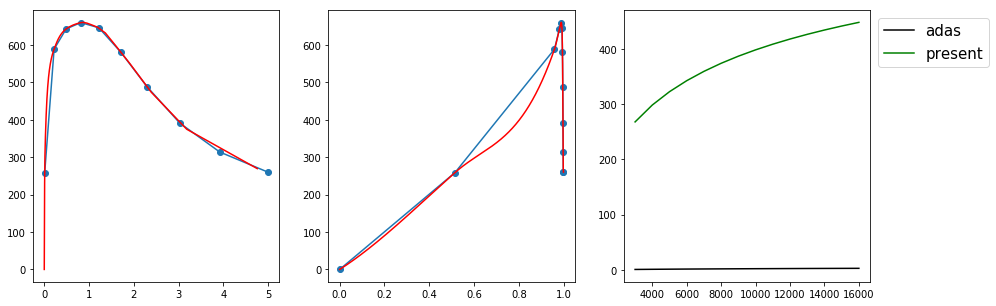

j= 105 type= 2


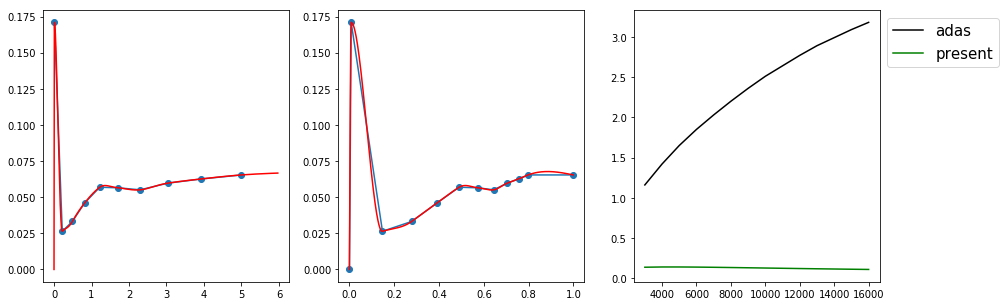

j= 106 type= 3


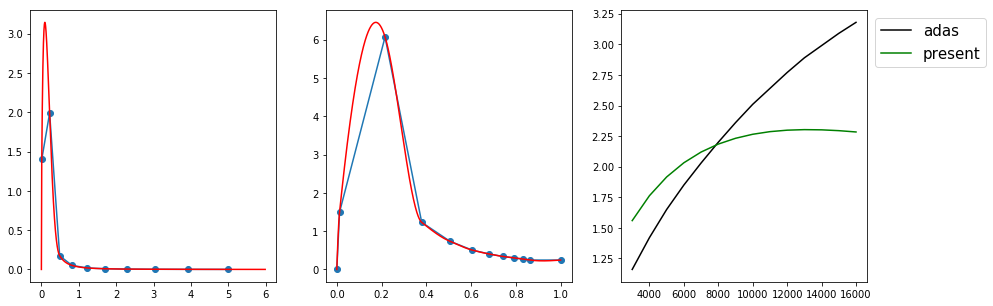

j= 107 type= 2


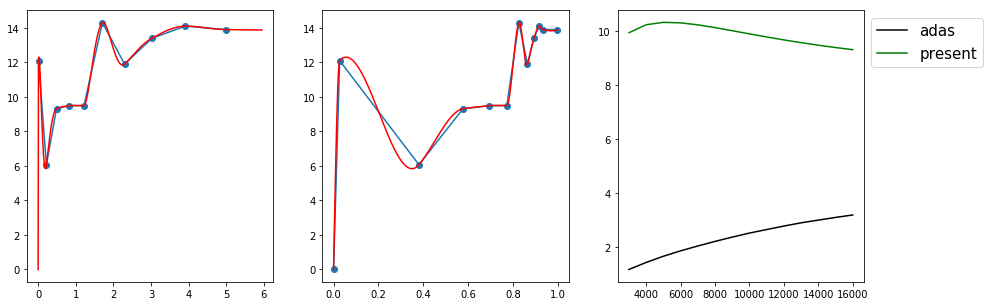

j= 108 type= 3


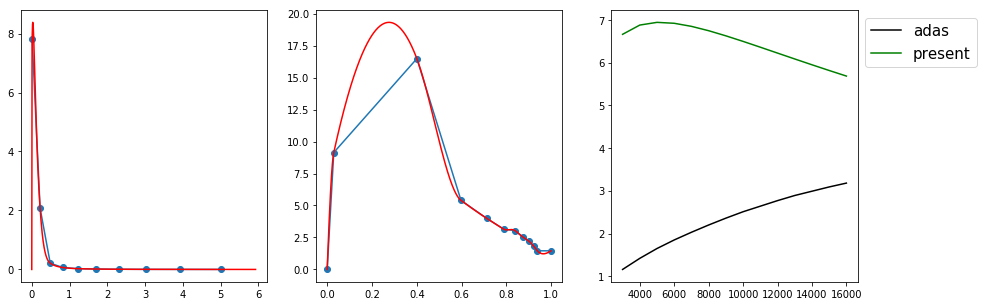

j= 109 type= 2


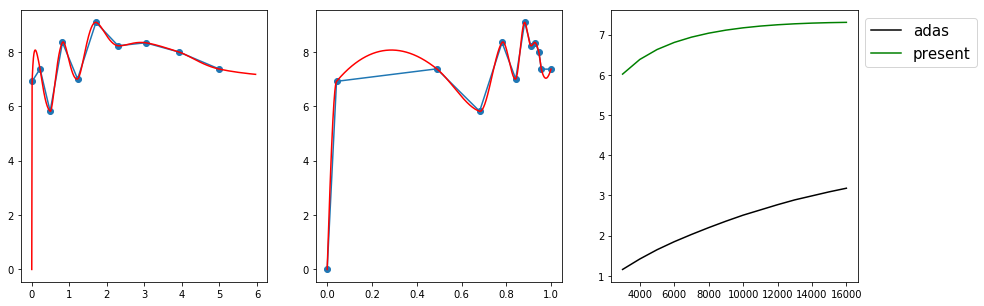

j= 110 type= 1


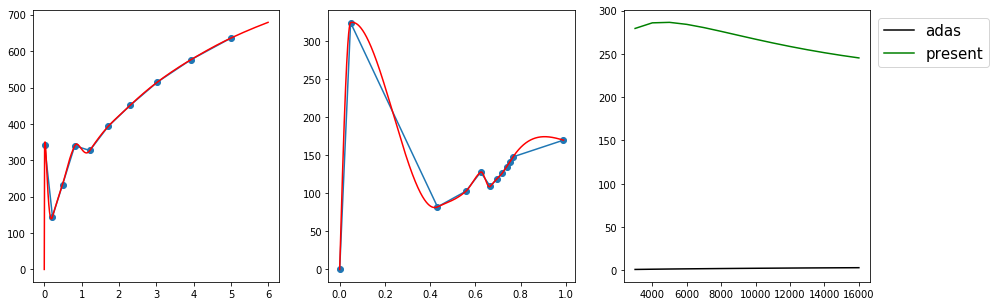

j= 111 type= 3


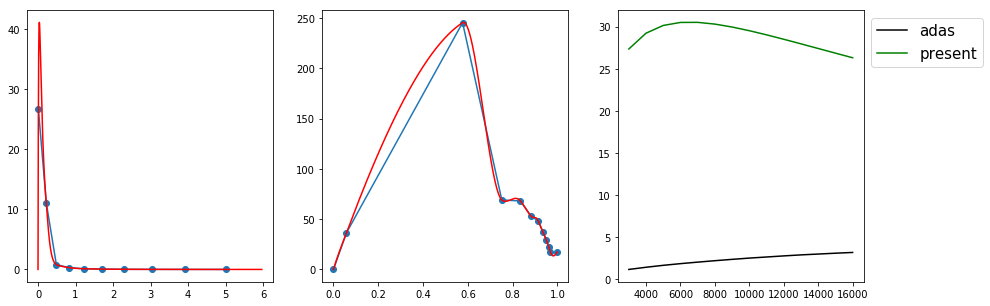

j= 112 type= 3


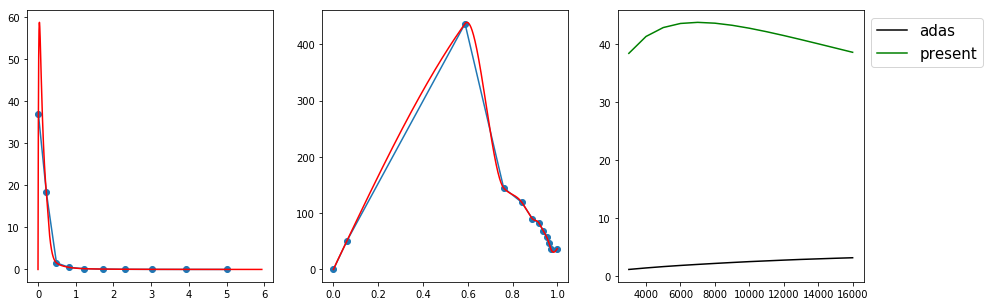

j= 113 type= 2


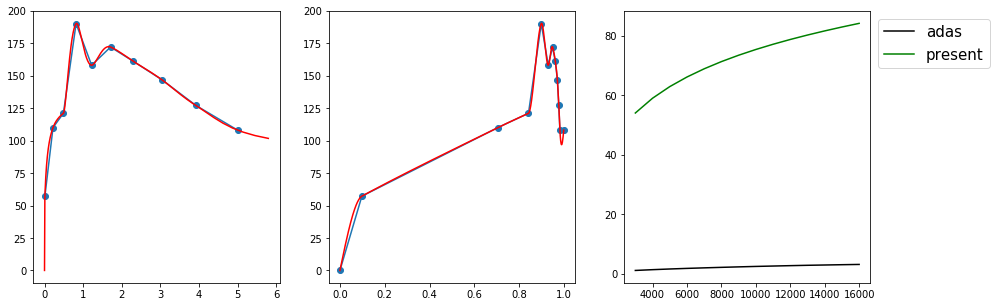

j= 114 type= 3


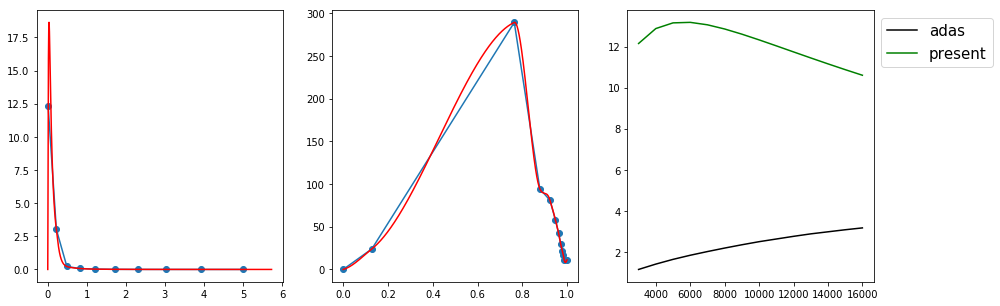

j= 115 type= 2


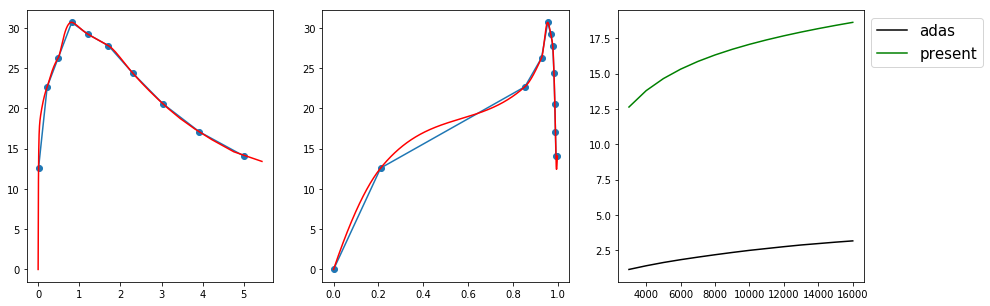

j= 116 type= 1


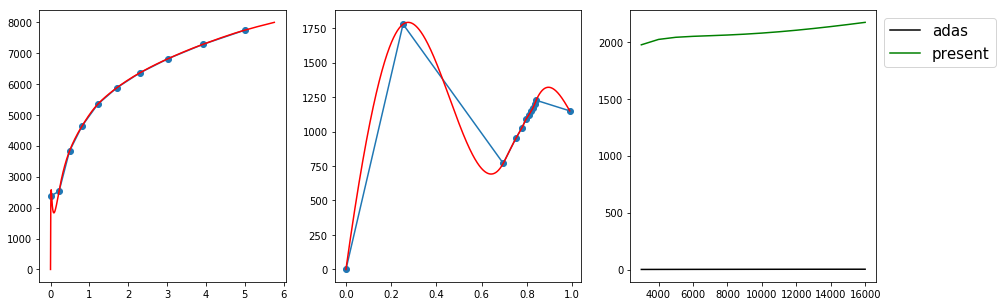

j= 117 type= 4


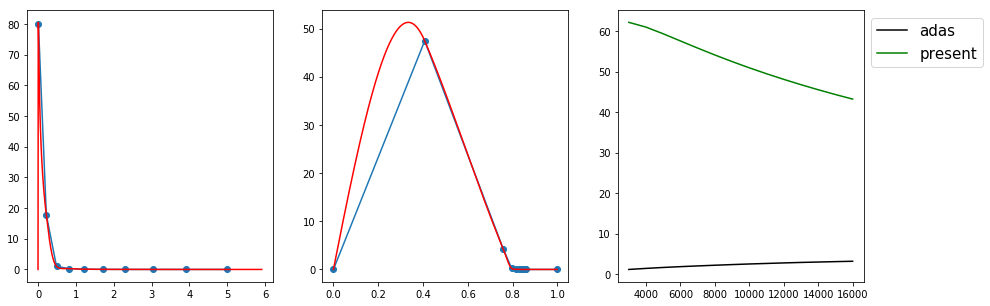

j= 118 type= 4


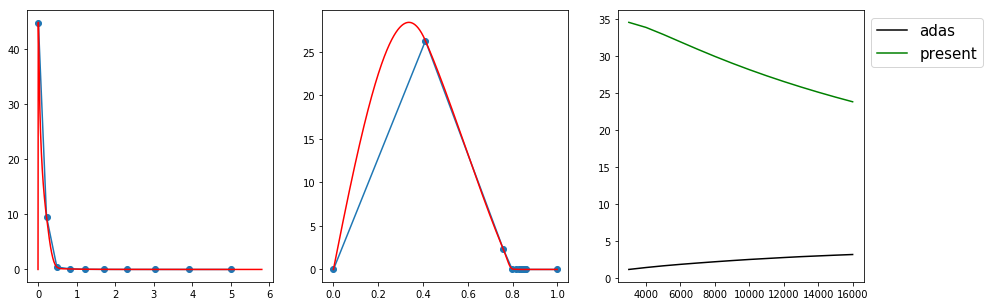

j= 119 type= 4


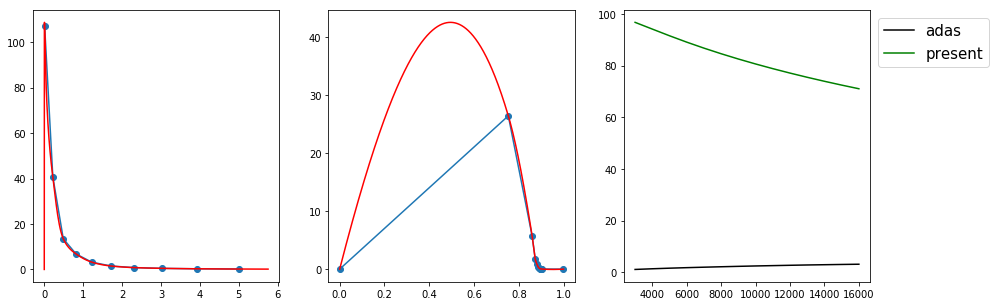

In [108]:
for j in range(100,120):
    ntype=int(omg.loc[j]['type'])
    print("j=",j,"type=",ntype)
    Aki,gk,gi,eik,fik=data_trans(j,omg,levels)
    # copy data into aux variables
    yomg=omg.loc[j][3:-2].values
    xener=np.array(ener)
    # map into BT-space
    x,y=map_BTspace(xener,eik,yomg,ntype)
    # make spline of x y in BT-space
    nx=len(x)
    x_new=np.linspace(x[0],x[nx-1], npts)
    y_new=interp_omg(nx,x,y,x_new,'akima')
    # mapping back from BT-space
    enerpp,omgpp=mapback_BTspace(ntype,eik,x_new,y_new)
    # compute effective collision strength
    yups=compute_ECS(enerpp,omgpp,ups_new)
    # plot and check data
    fig=plt.figure(figsize=(15,5))
    ax1=plt.subplot(131)
    plt.plot(xener,yomg,'o-')
    plt.plot(enerpp,omgpp,'r-')
    ax2=plt.subplot(132)
    plt.plot(x,y,'o-')
    plt.plot(x_new,y_new,'r-')
    ax3=plt.subplot(133)
    plt.plot(T,ups_prev.loc[0][3:-1],'k',label="adas")
    plt.plot(T,yups,'g-',label="present")
    plt.legend(loc='upper left',bbox_to_anchor=[1,1],fontsize=15,ncol=1)
    plt.show()

j= 120 type= 1


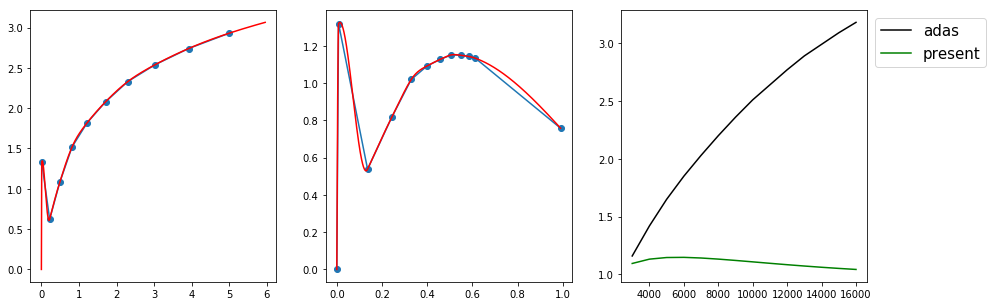

j= 121 type= 3


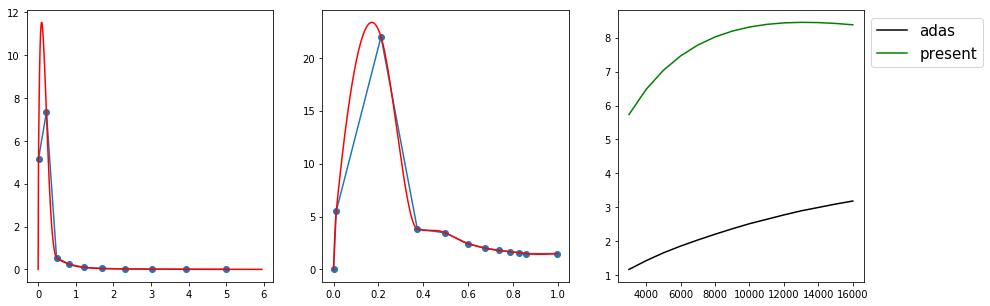

j= 122 type= 2


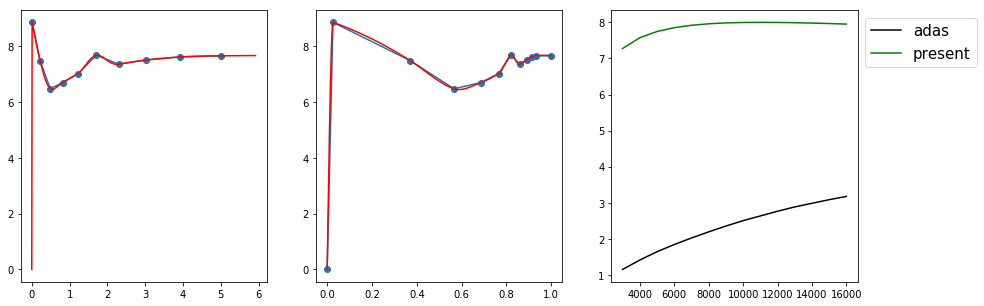

j= 123 type= 3


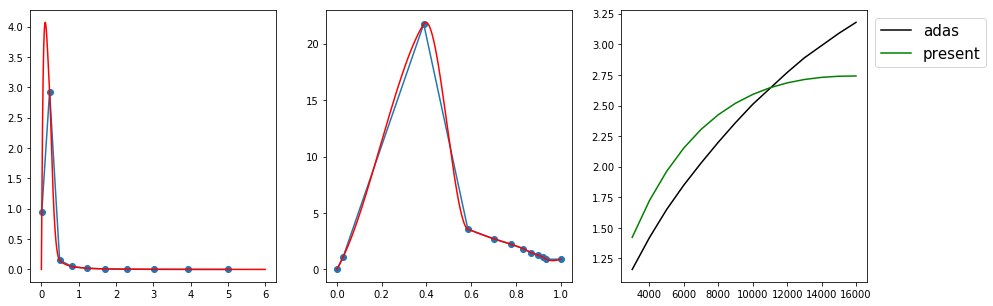

j= 124 type= 1


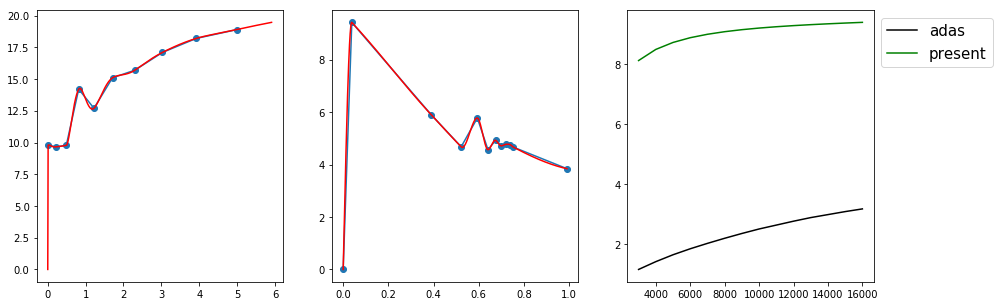

j= 125 type= 1


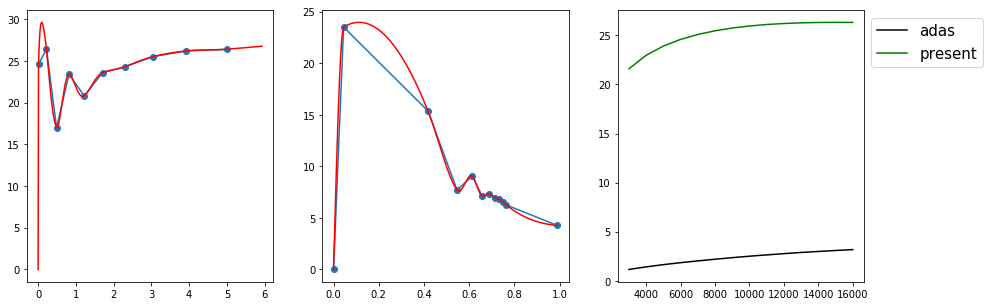

j= 126 type= 3


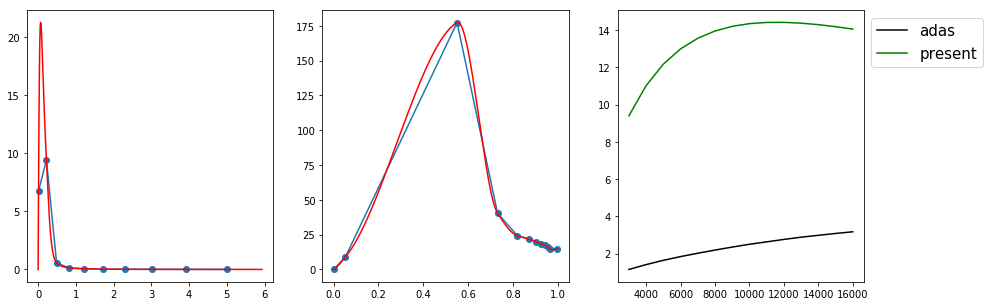

j= 127 type= 3


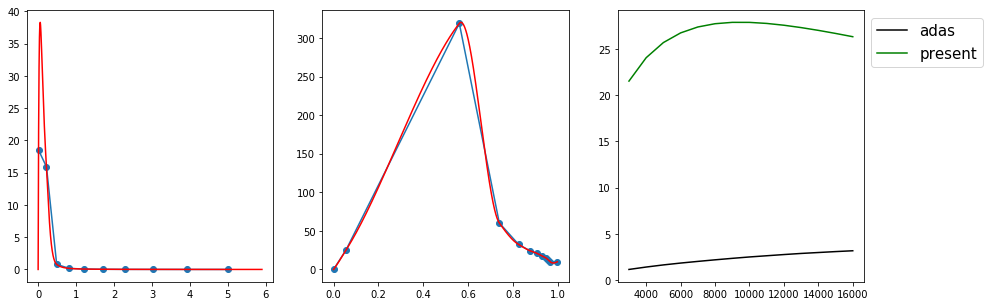

j= 128 type= 2


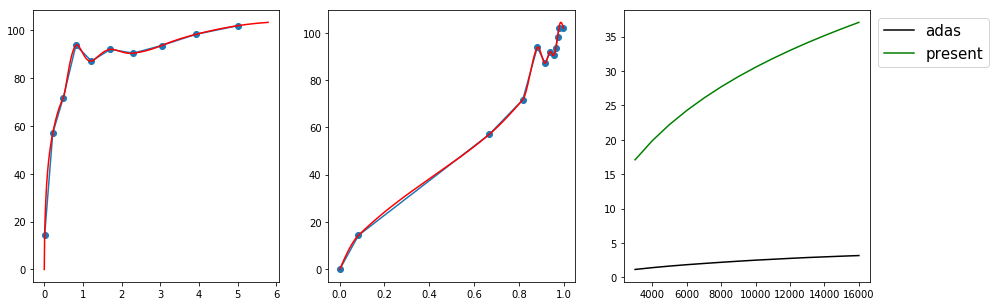

j= 129 type= 3


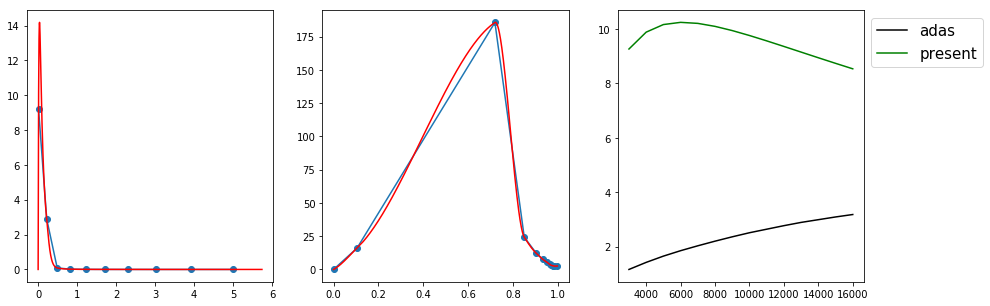

j= 130 type= 1


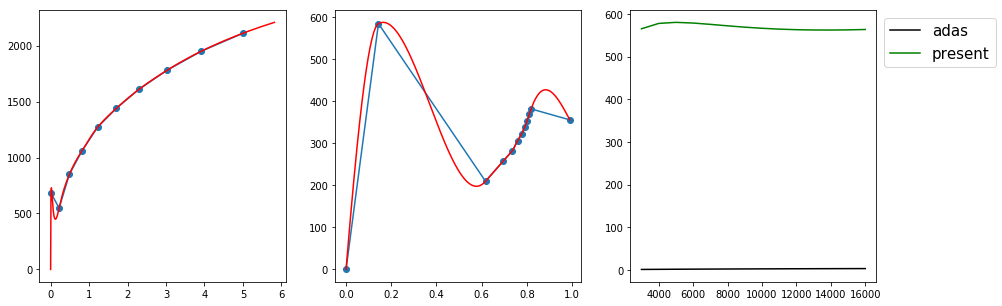

j= 131 type= 1


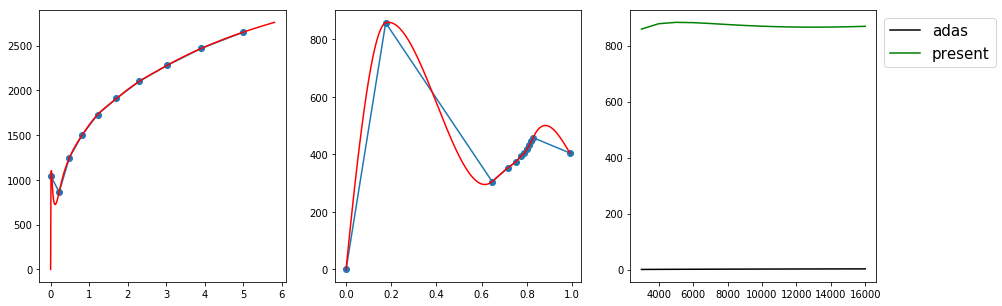

j= 132 type= 2


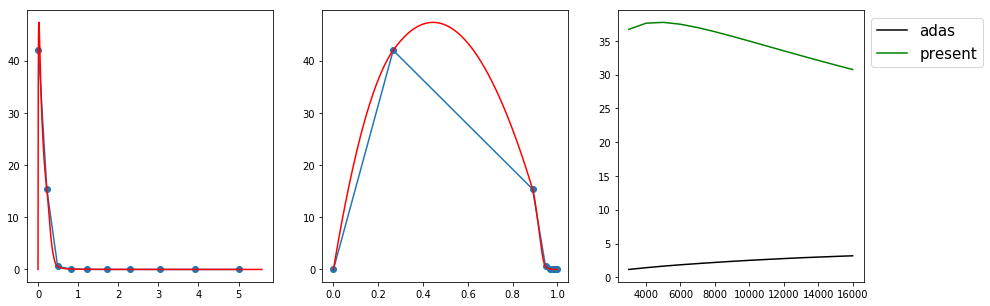

j= 133 type= 4


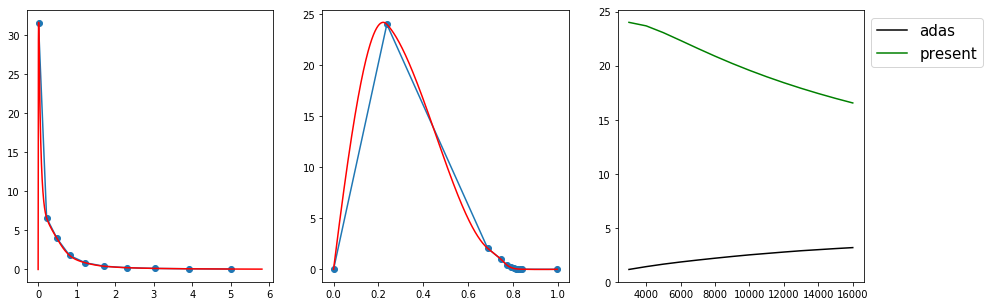

j= 134 type= 4


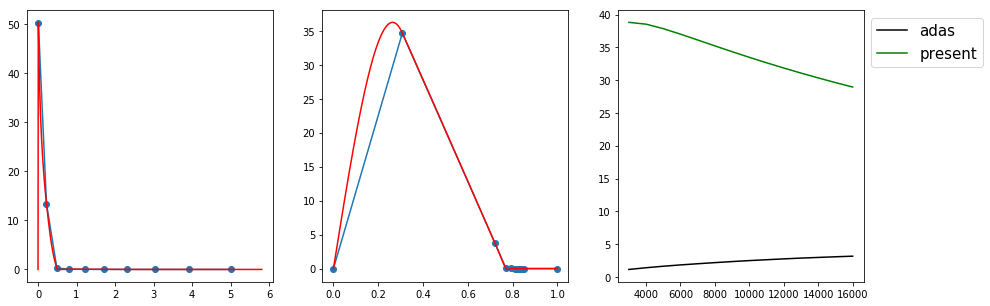

j= 135 type= 2


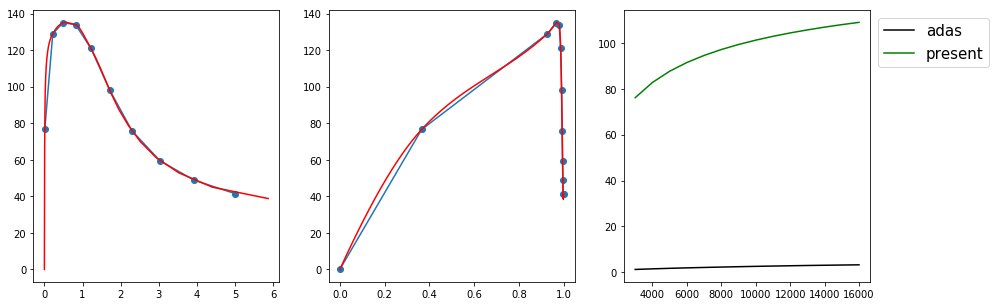

j= 136 type= 3


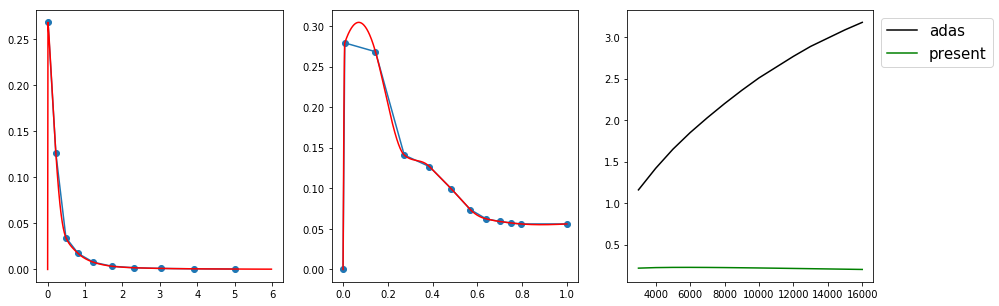

j= 137 type= 4


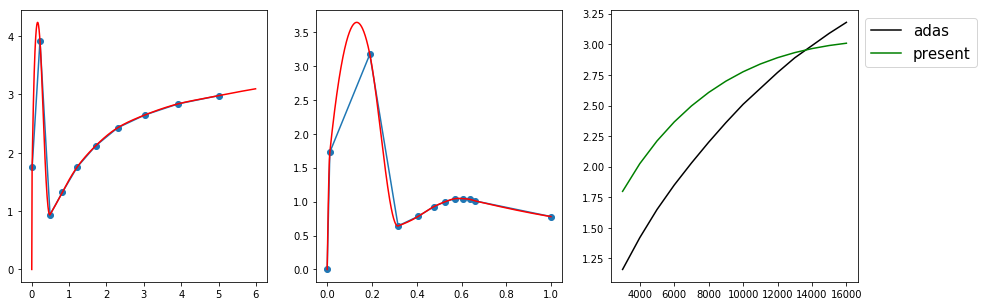

j= 138 type= 3


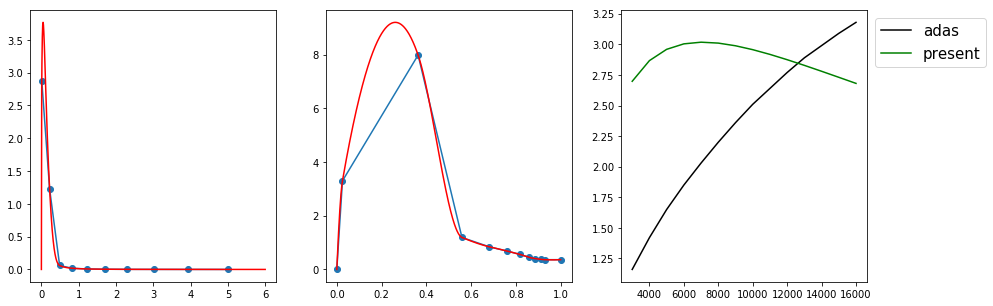

j= 139 type= 2


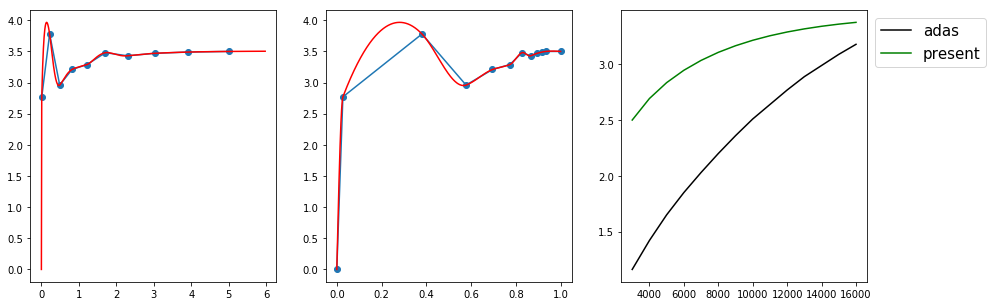

In [113]:
for j in range(120,140):
    ntype=int(omg.loc[j]['type'])
    print("j=",j,"type=",ntype)
    Aki,gk,gi,eik,fik=data_trans(j,omg,levels)
    # copy data into aux variables
    yomg=omg.loc[j][3:-2].values
    xener=np.array(ener)
    # map into BT-space
    x,y=map_BTspace(xener,eik,yomg,ntype)
    # make spline of x y in BT-space
    nx=len(x)
    x_new=np.linspace(x[0],x[nx-1], npts)
    y_new=interp_omg(nx,x,y,x_new,'akima')
    # mapping back from BT-space
    enerpp,omgpp=mapback_BTspace(ntype,eik,x_new,y_new)
    # compute effective collision strength
    yups=compute_ECS(enerpp,omgpp,ups_new)
    # plot and check data
    fig=plt.figure(figsize=(15,5))
    ax1=plt.subplot(131)
    plt.plot(xener,yomg,'o-')
    plt.plot(enerpp,omgpp,'r-')
    ax2=plt.subplot(132)
    plt.plot(x,y,'o-')
    plt.plot(x_new,y_new,'r-')
    ax3=plt.subplot(133)
    plt.plot(T,ups_prev.loc[0][3:-1],'k',label="adas")
    plt.plot(T,yups,'g-',label="present")
    plt.legend(loc='upper left',bbox_to_anchor=[1,1],fontsize=15,ncol=1)
    plt.show()

j= 140 type= 3


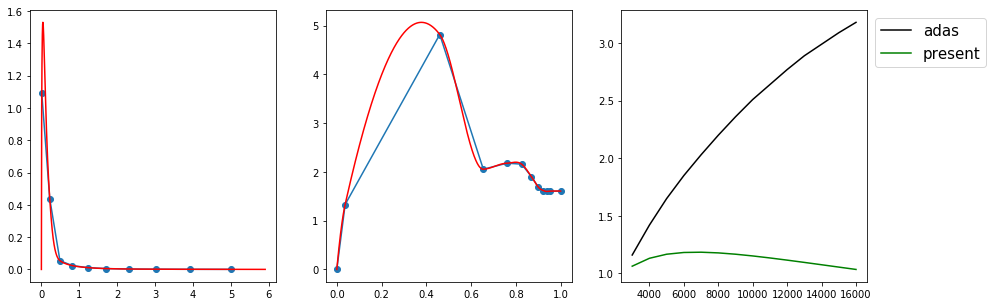

j= 141 type= 3


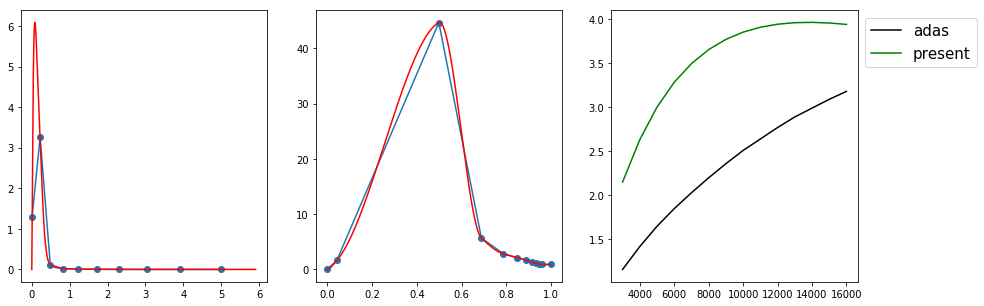

j= 142 type= 1


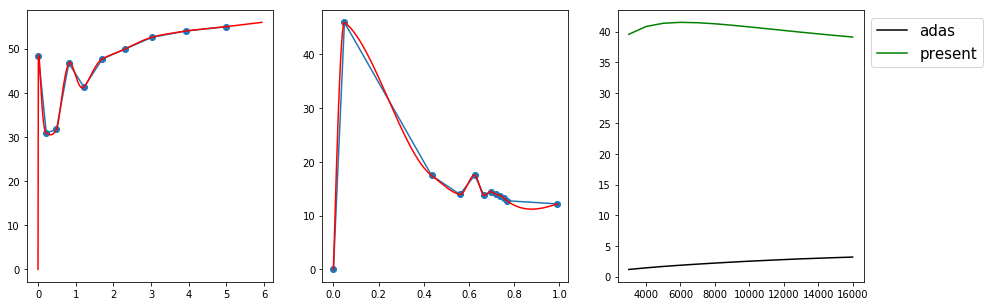

j= 143 type= 2


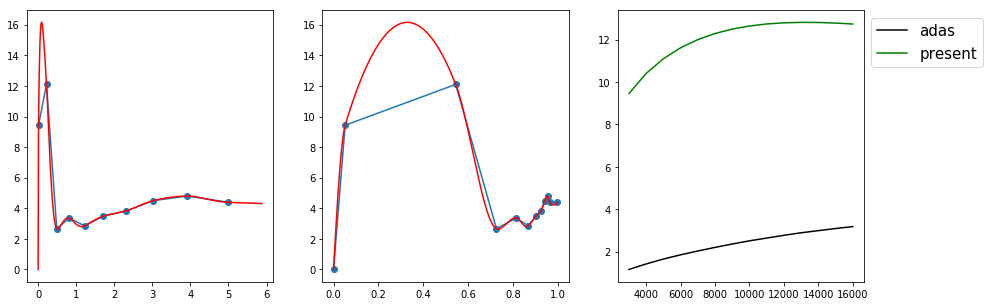

j= 144 type= 3


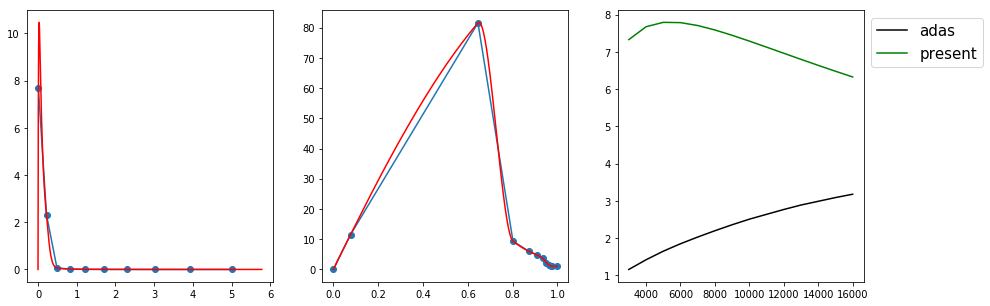

j= 145 type= 2


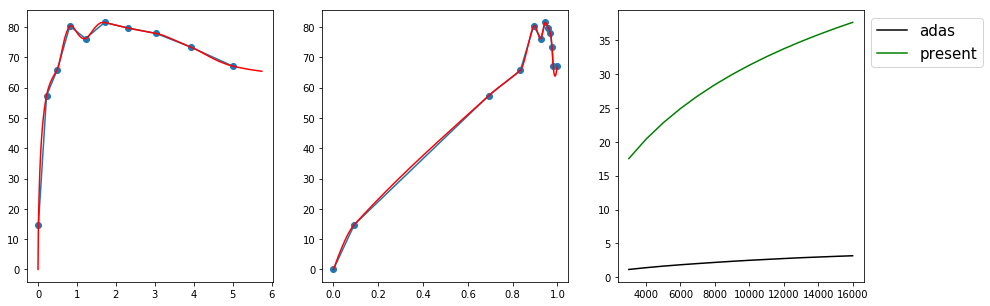

j= 146 type= 3


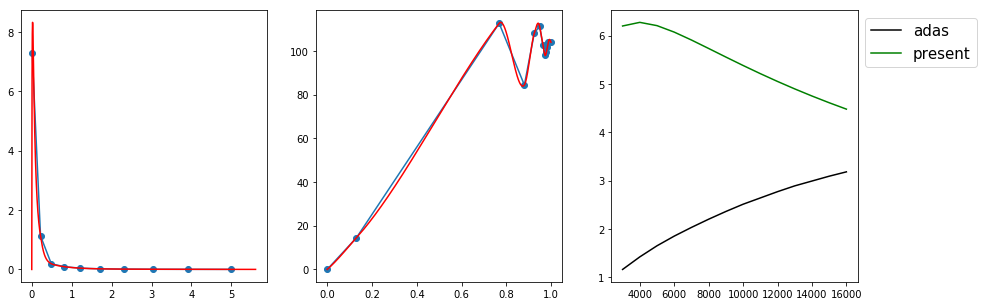

j= 147 type= 3


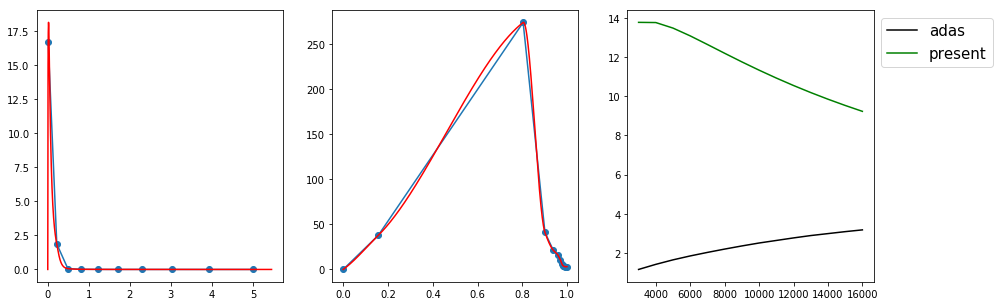

j= 148 type= 2


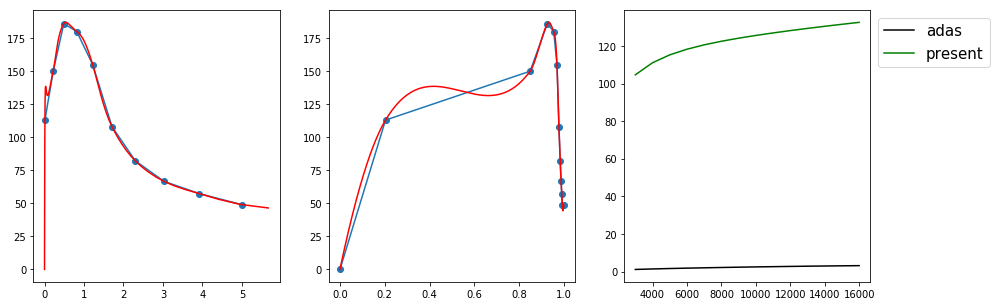

j= 149 type= 1


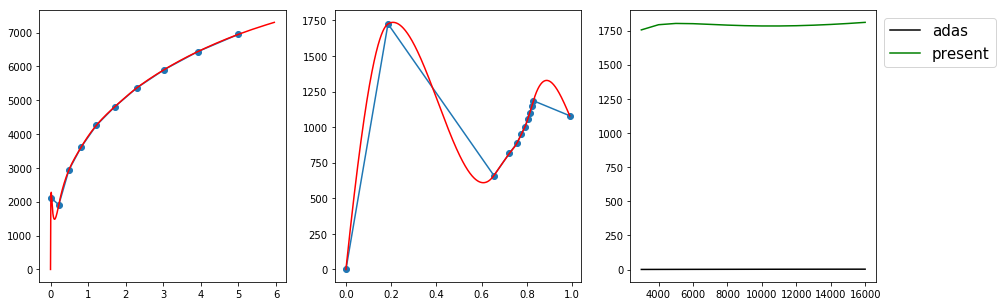

j= 150 type= 2


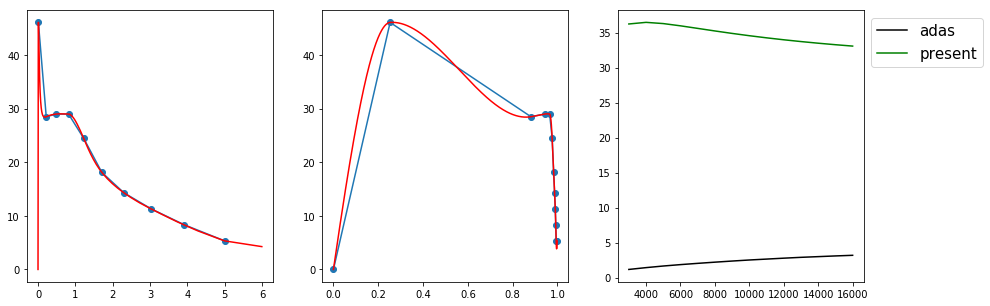

j= 151 type= 4


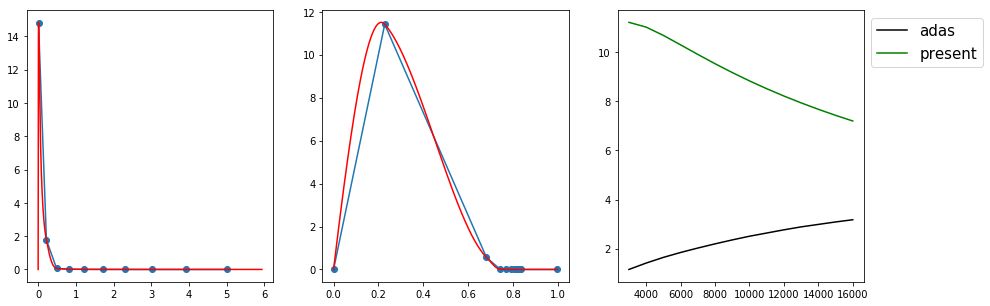

j= 152 type= 4


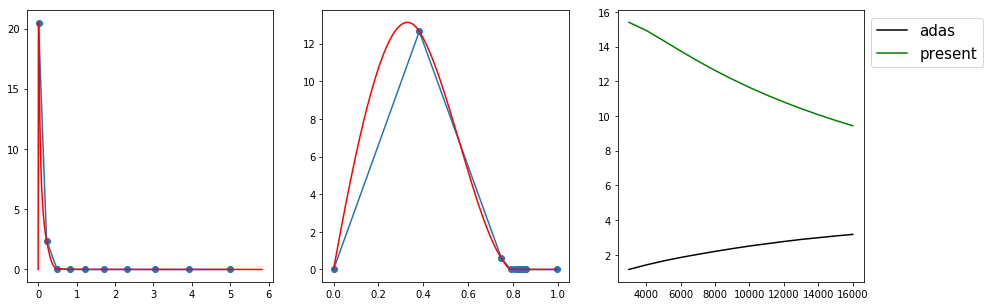

j= 153 type= 2


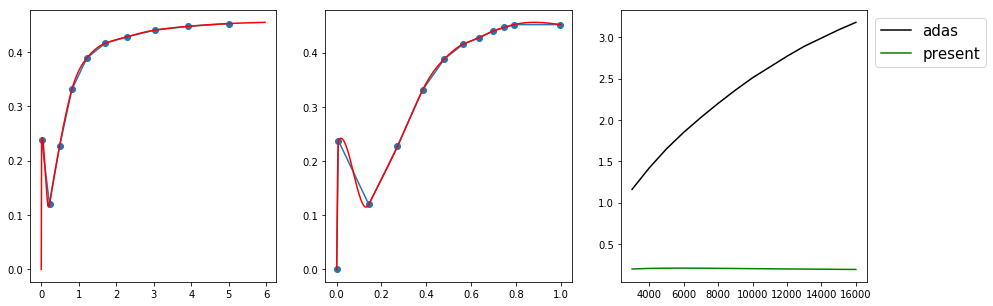

j= 154 type= 3


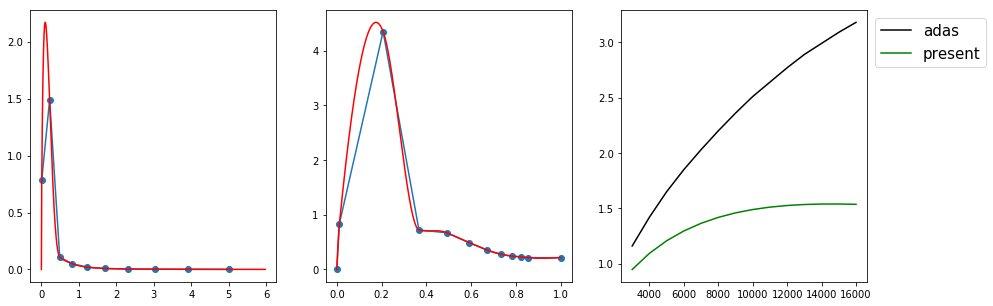

j= 155 type= 4


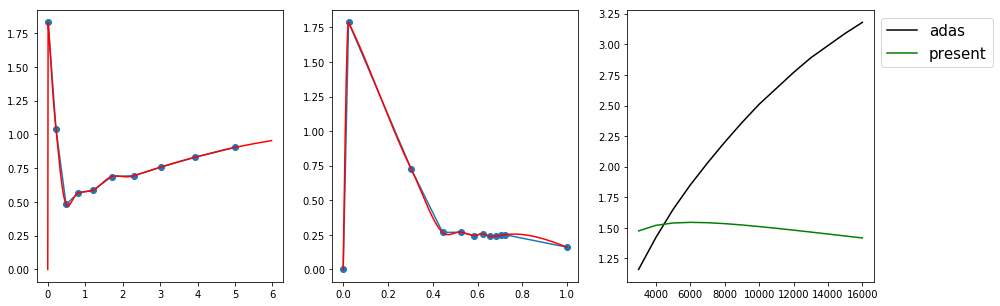

j= 156 type= 3


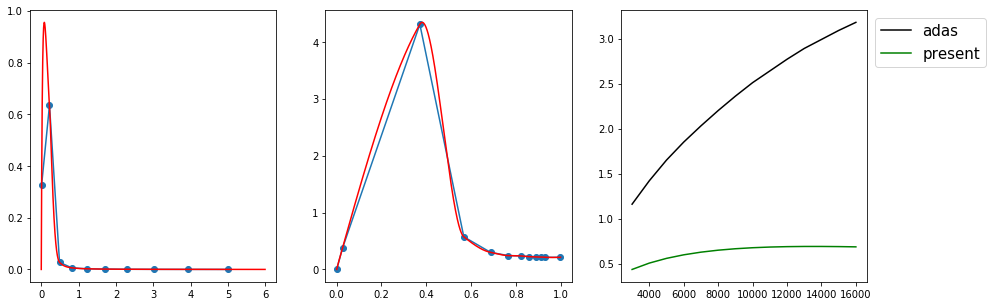

j= 157 type= 2


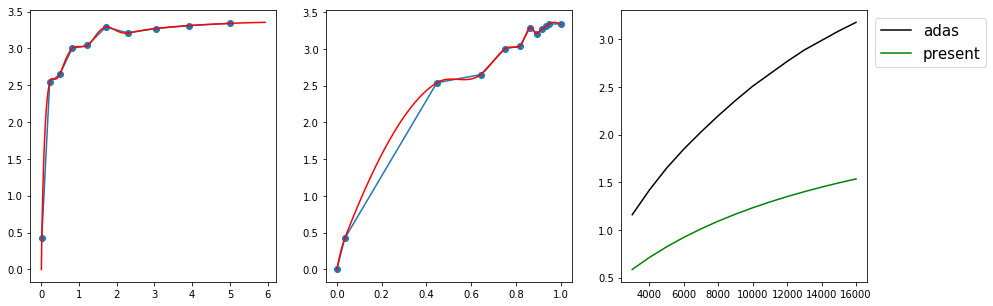

j= 158 type= 2


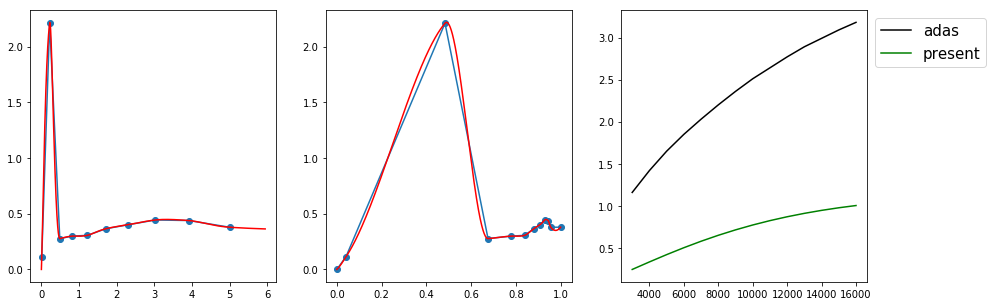

j= 159 type= 3


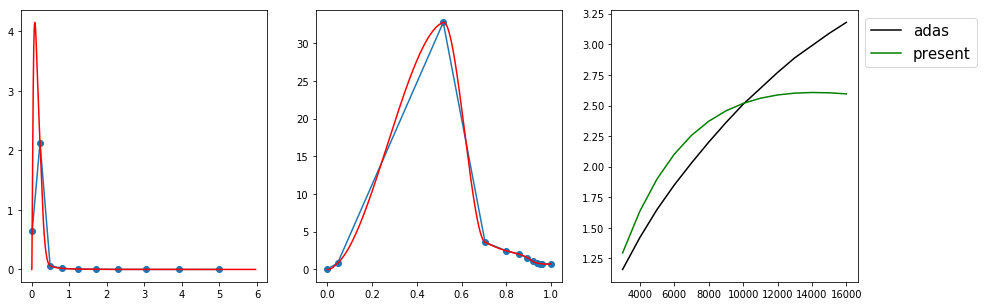

In [116]:
for j in range(140,160):
    ntype=int(omg.loc[j]['type'])
    print("j=",j,"type=",ntype)
    Aki,gk,gi,eik,fik=data_trans(j,omg,levels)
    # copy data into aux variables
    yomg=omg.loc[j][3:-2].values
    xener=np.array(ener)
    # map into BT-space
    x,y=map_BTspace(xener,eik,yomg,ntype)
    # make spline of x y in BT-space
    nx=len(x)
    x_new=np.linspace(x[0],x[nx-1], npts)
    y_new=interp_omg(nx,x,y,x_new,'akima')
    # mapping back from BT-space
    enerpp,omgpp=mapback_BTspace(ntype,eik,x_new,y_new)
    # compute effective collision strength
    yups=compute_ECS(enerpp,omgpp,ups_new)
    # plot and check data
    fig=plt.figure(figsize=(15,5))
    ax1=plt.subplot(131)
    plt.plot(xener,yomg,'o-')
    plt.plot(enerpp,omgpp,'r-')
    ax2=plt.subplot(132)
    plt.plot(x,y,'o-')
    plt.plot(x_new,y_new,'r-')
    ax3=plt.subplot(133)
    plt.plot(T,ups_prev.loc[0][3:-1],'k',label="adas")
    plt.plot(T,yups,'g-',label="present")
    plt.legend(loc='upper left',bbox_to_anchor=[1,1],fontsize=15,ncol=1)
    plt.show()

j= 160 type= 3


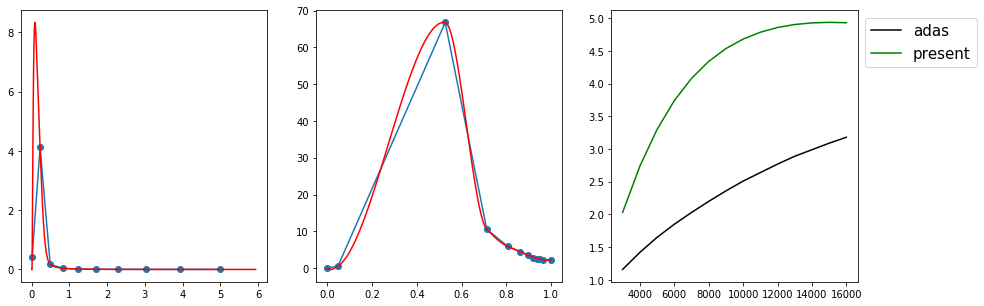

j= 161 type= 1


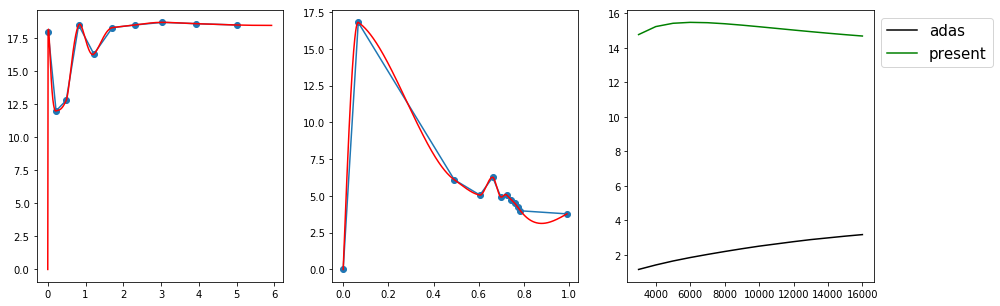

j= 162 type= 3


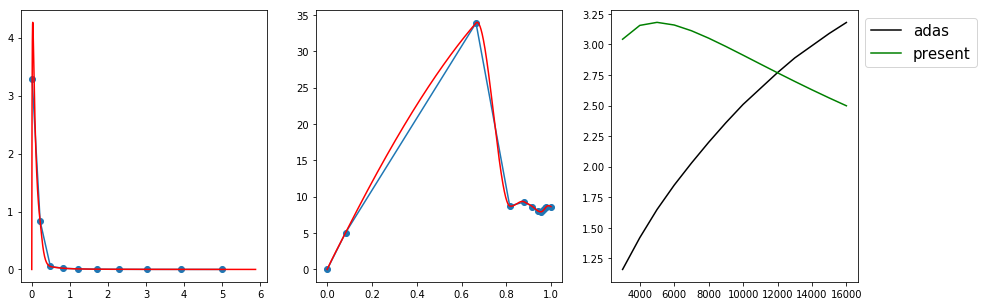

j= 163 type= 2


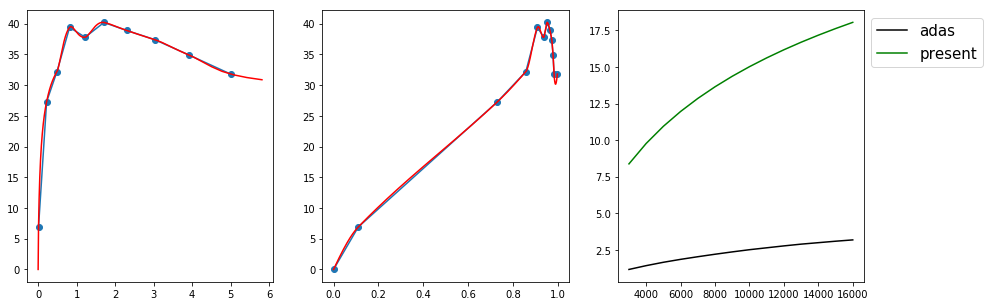

j= 164 type= 2


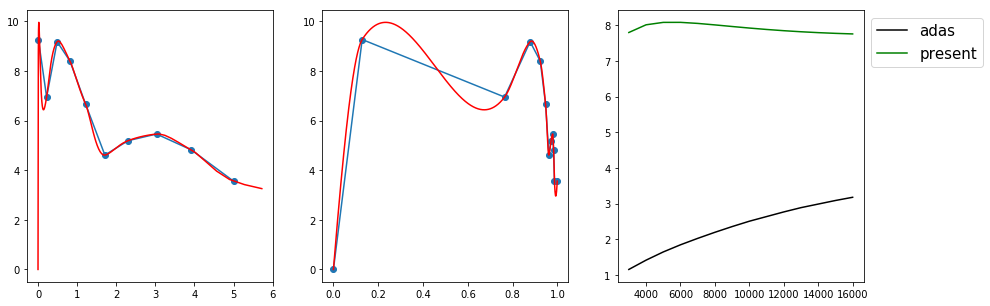

j= 165 type= 3


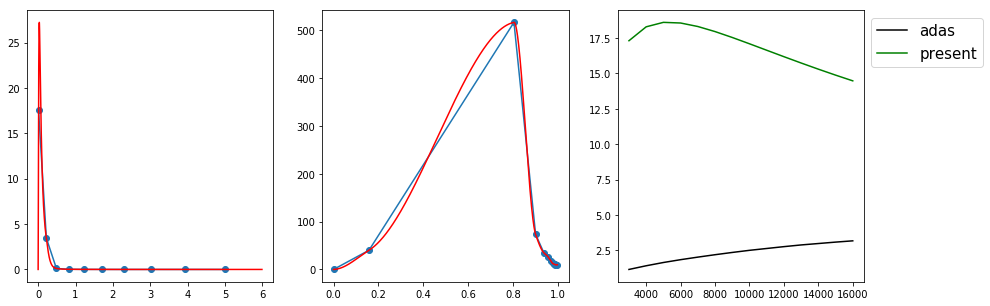

j= 166 type= 3


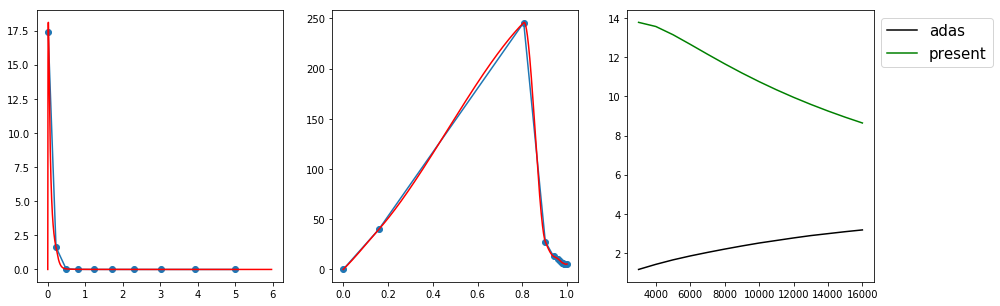

j= 167 type= 3


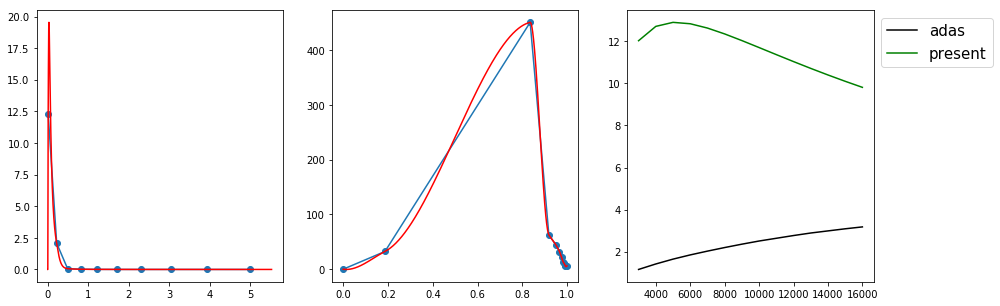

j= 168 type= 2


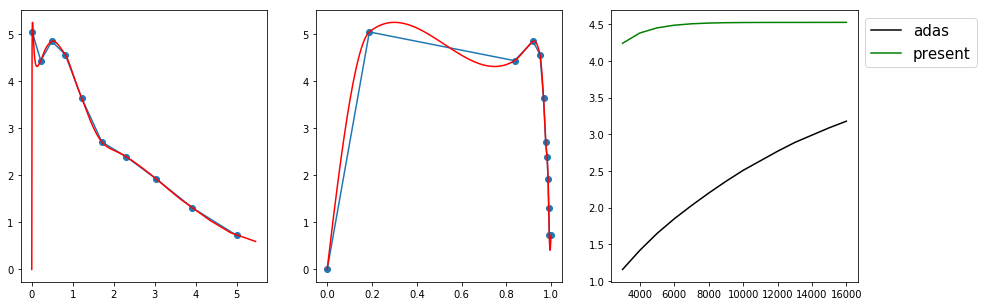

j= 169 type= 1


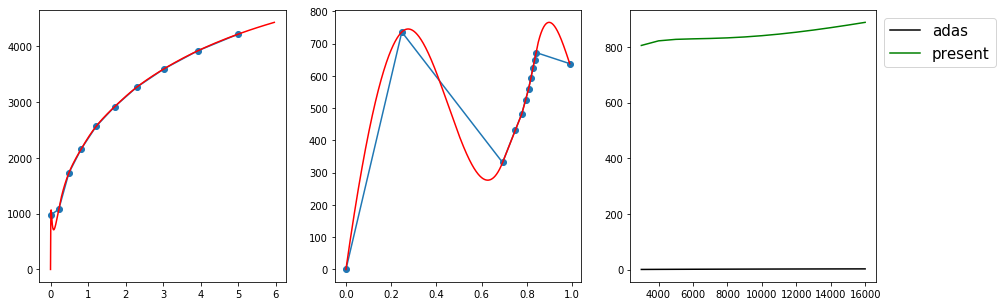

j= 170 type= 4


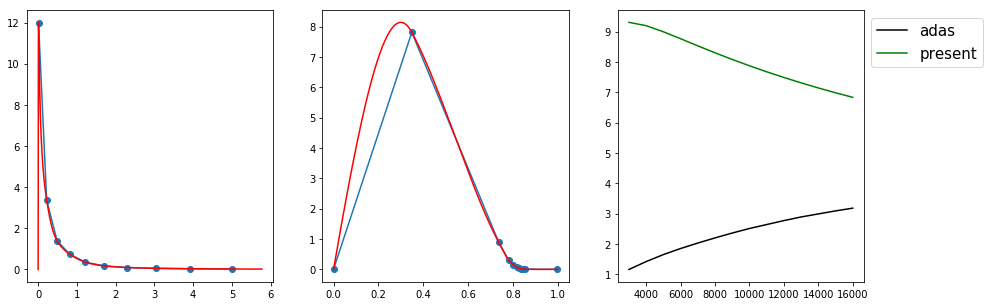

j= 171 type= 2


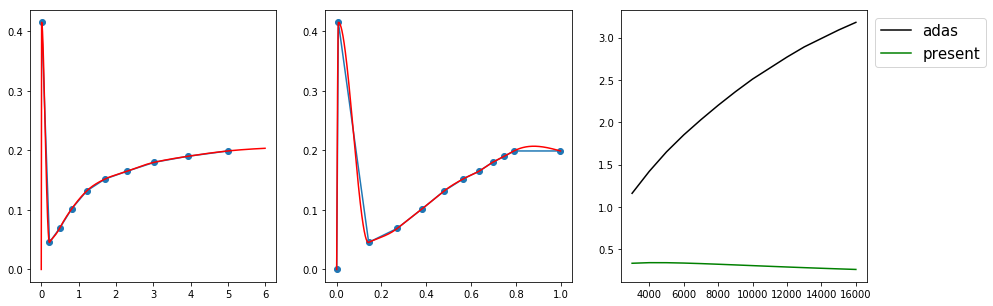

j= 172 type= 3


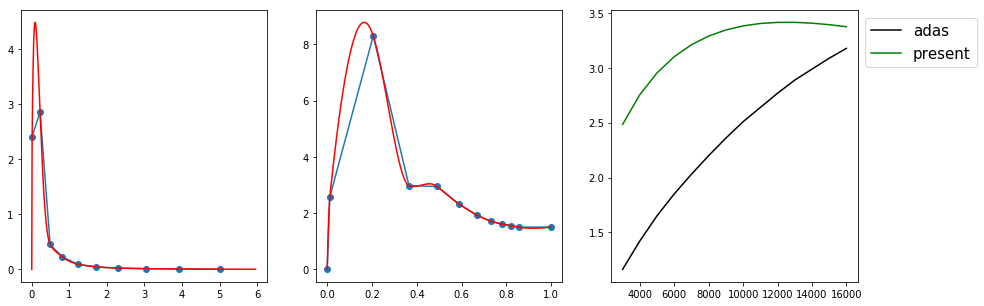

j= 173 type= 1


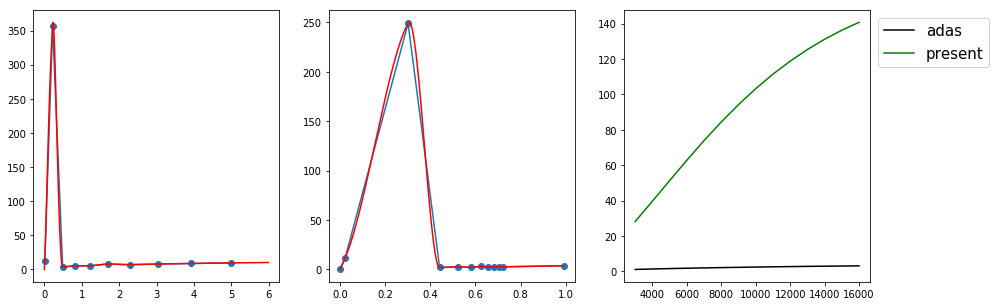

j= 174 type= 3


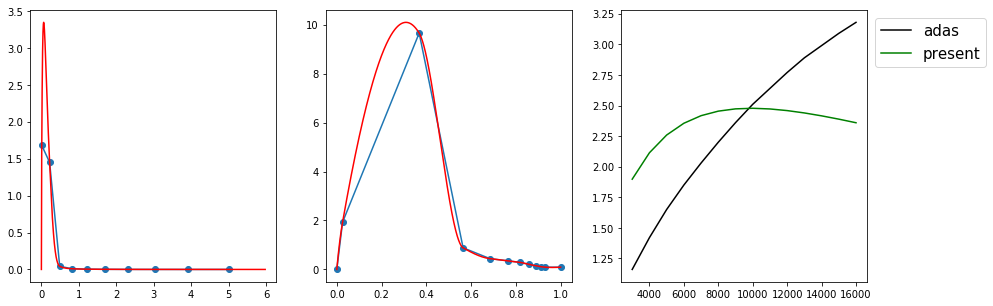

j= 175 type= 2


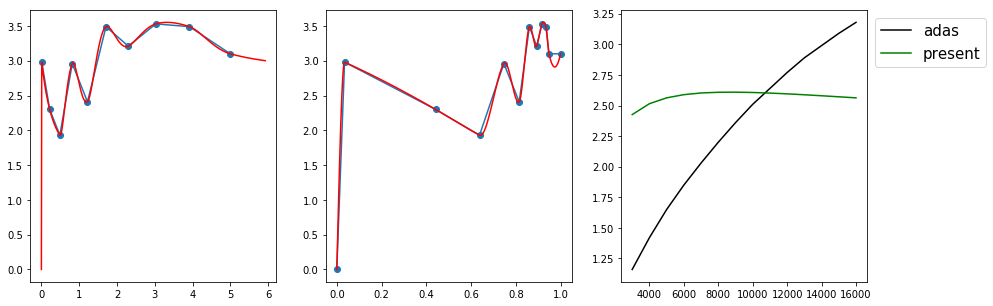

j= 176 type= 2


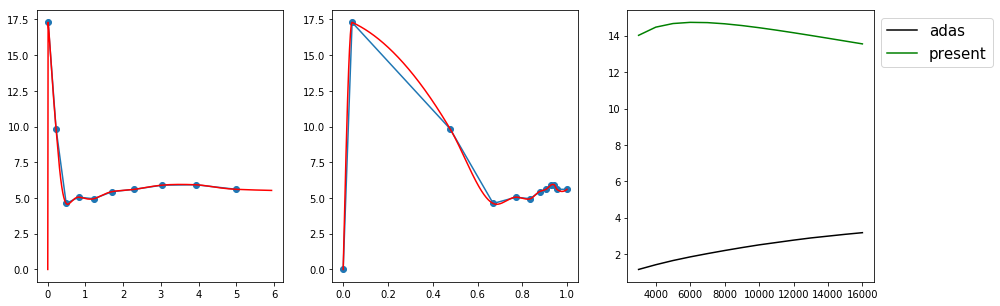

j= 177 type= 3


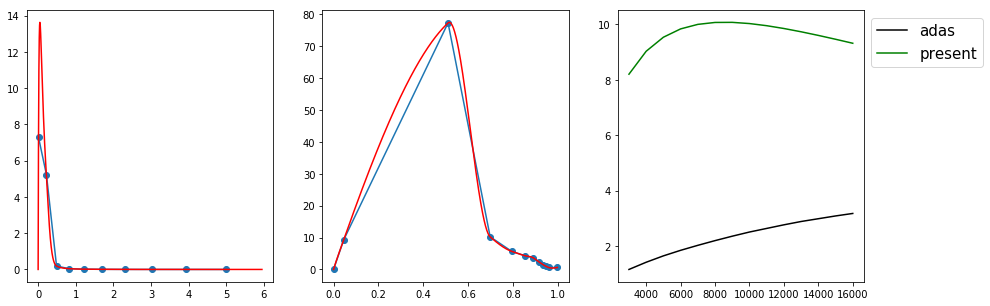

j= 178 type= 3


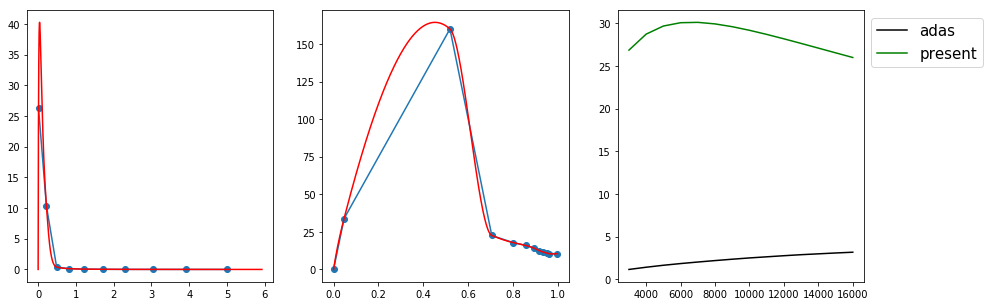

j= 179 type= 1


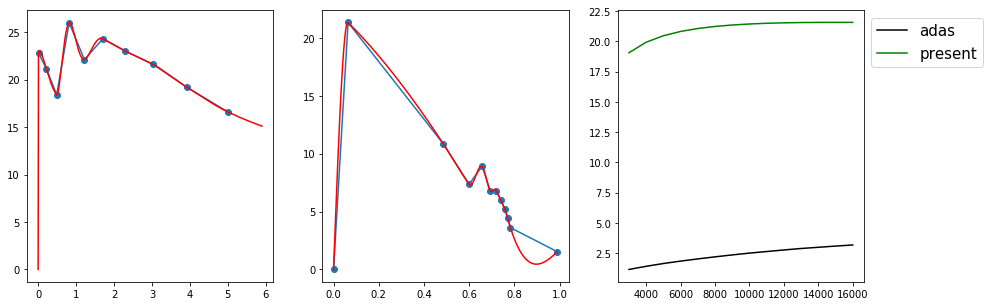

In [119]:
for j in range(160,180):
    ntype=int(omg.loc[j]['type'])
    print("j=",j,"type=",ntype)
    Aki,gk,gi,eik,fik=data_trans(j,omg,levels)
    # copy data into aux variables
    yomg=omg.loc[j][3:-2].values
    xener=np.array(ener)
    # map into BT-space
    x,y=map_BTspace(xener,eik,yomg,ntype)
    # make spline of x y in BT-space
    nx=len(x)
    x_new=np.linspace(x[0],x[nx-1], npts)
    y_new=interp_omg(nx,x,y,x_new,'akima')
    # mapping back from BT-space
    enerpp,omgpp=mapback_BTspace(ntype,eik,x_new,y_new)
    # compute effective collision strength
    yups=compute_ECS(enerpp,omgpp,ups_new)
    # plot and check data
    fig=plt.figure(figsize=(15,5))
    ax1=plt.subplot(131)
    plt.plot(xener,yomg,'o-')
    plt.plot(enerpp,omgpp,'r-')
    ax2=plt.subplot(132)
    plt.plot(x,y,'o-')
    plt.plot(x_new,y_new,'r-')
    ax3=plt.subplot(133)
    plt.plot(T,ups_prev.loc[0][3:-1],'k',label="adas")
    plt.plot(T,yups,'g-',label="present")
    plt.legend(loc='upper left',bbox_to_anchor=[1,1],fontsize=15,ncol=1)
    plt.show()

j= 180 type= 3


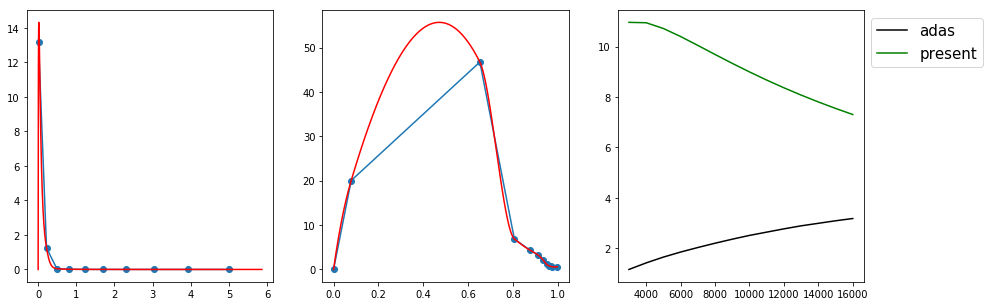

j= 181 type= 2


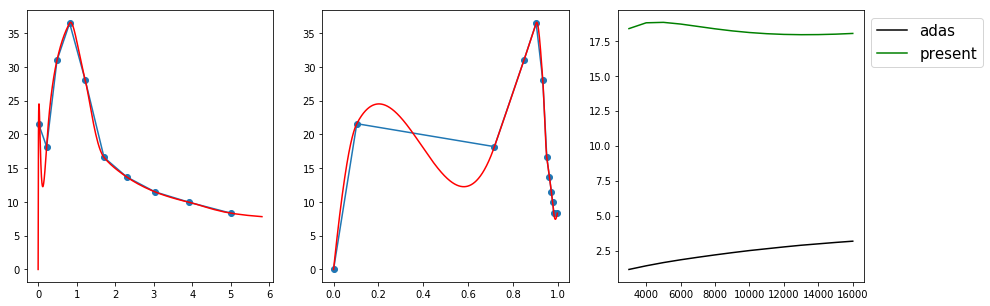

j= 182 type= 2


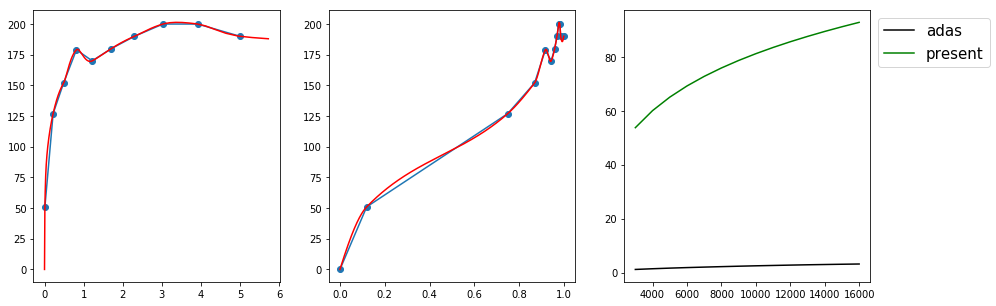

j= 183 type= 3


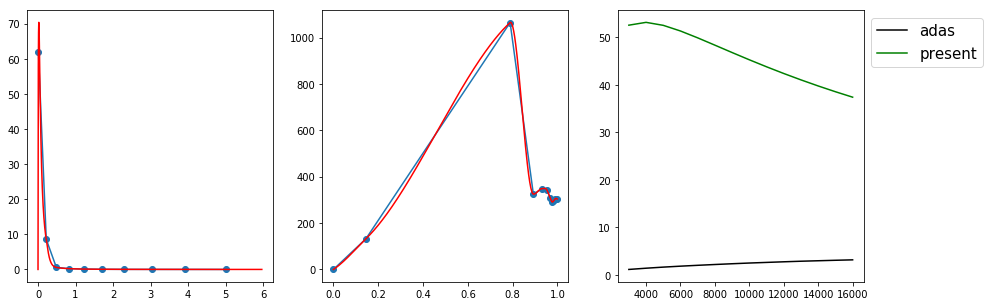

j= 184 type= 3


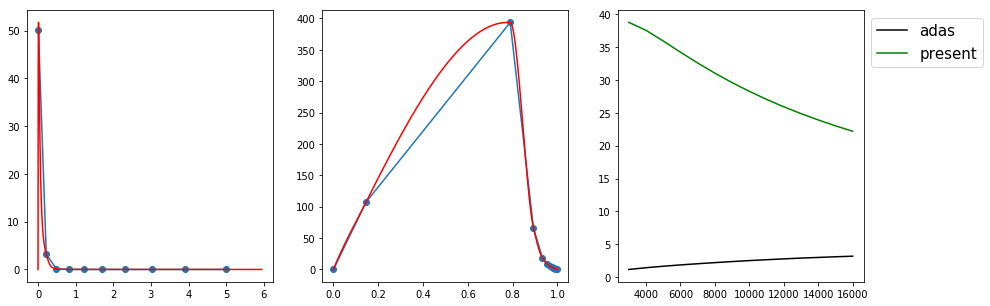

j= 185 type= 3


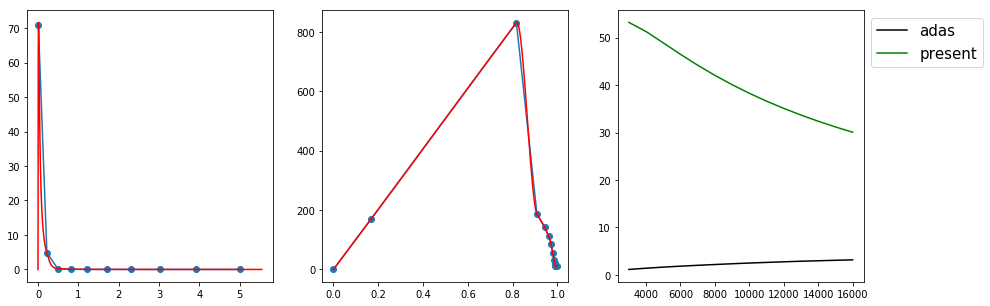

j= 186 type= 1


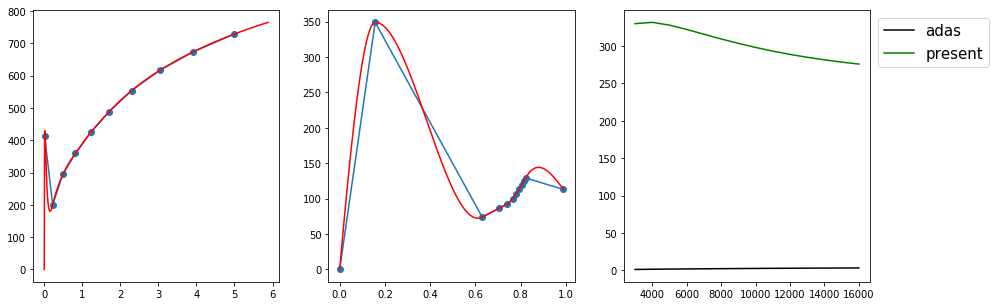

j= 187 type= 1


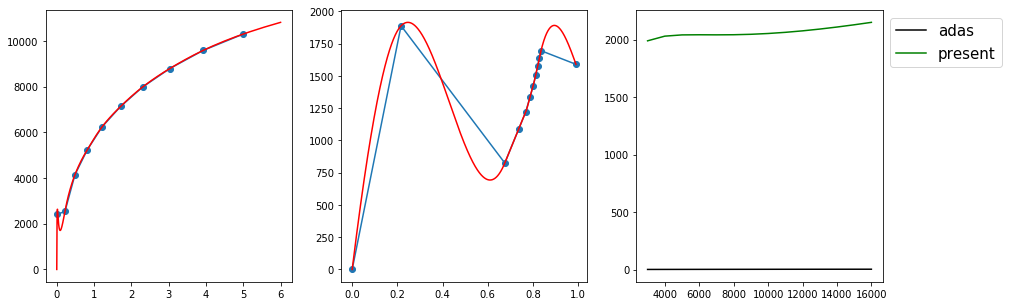

j= 188 type= 3


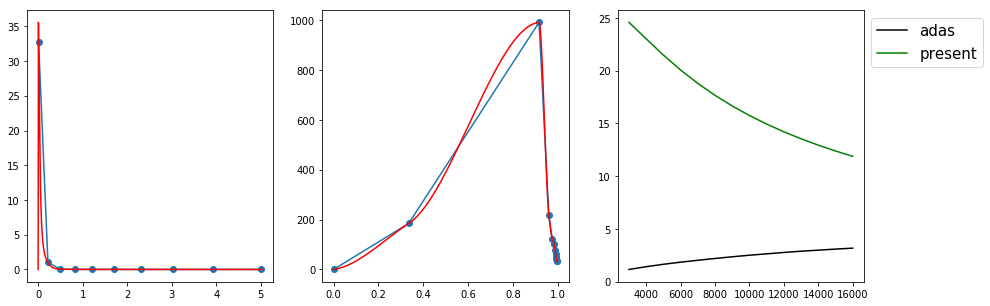

j= 189 type= 2


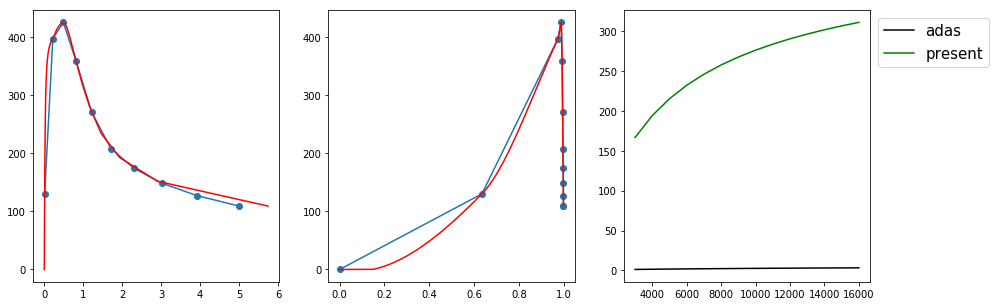

j= 190 type= 3


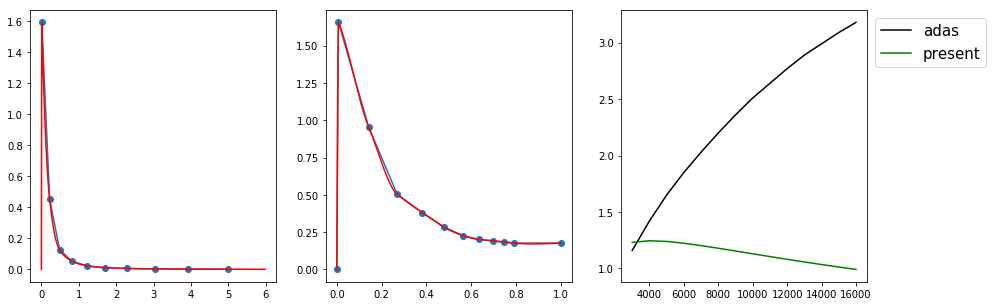

j= 191 type= 1


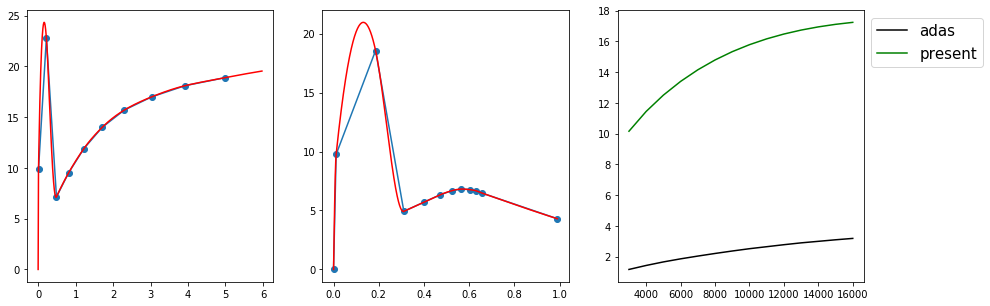

j= 192 type= 3


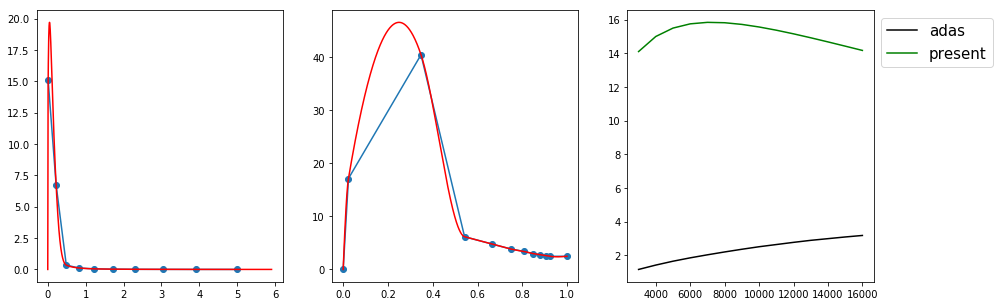

j= 193 type= 2


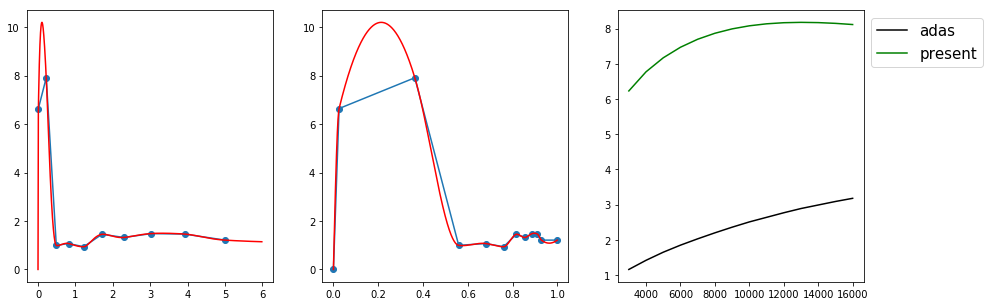

j= 194 type= 3


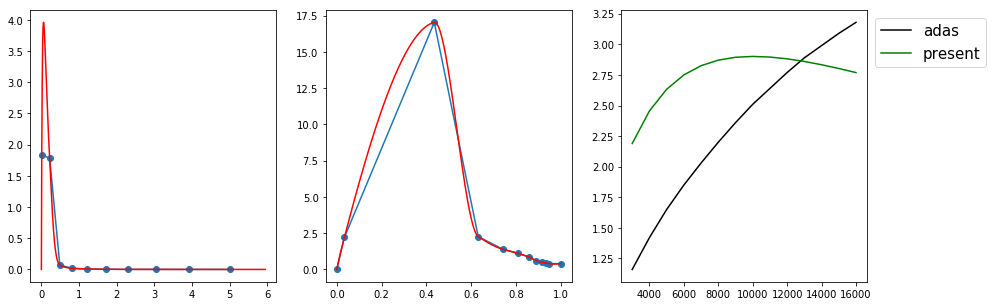

j= 195 type= 3


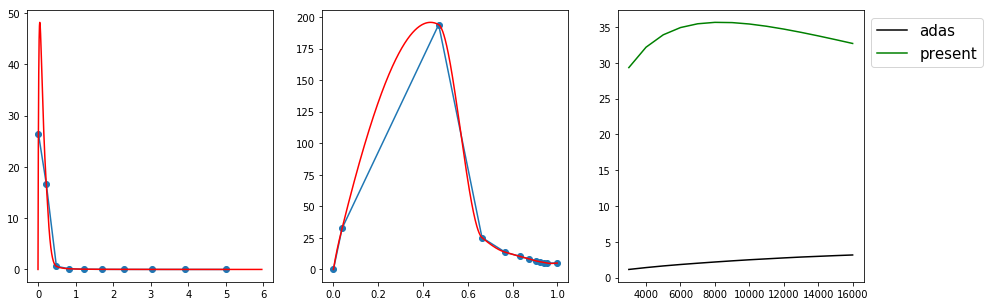

j= 196 type= 1


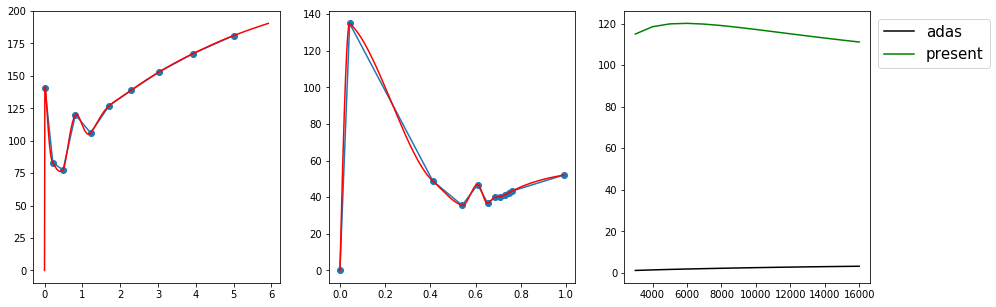

j= 197 type= 2


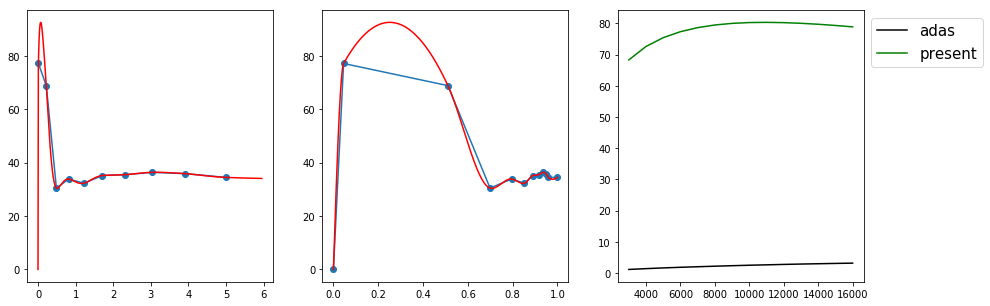

j= 198 type= 3


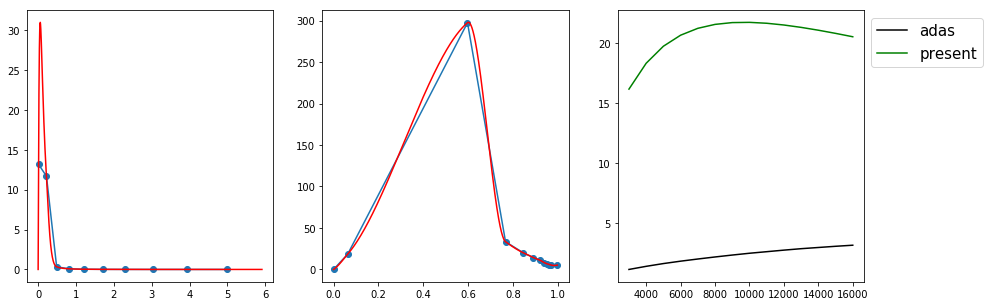

j= 199 type= 2


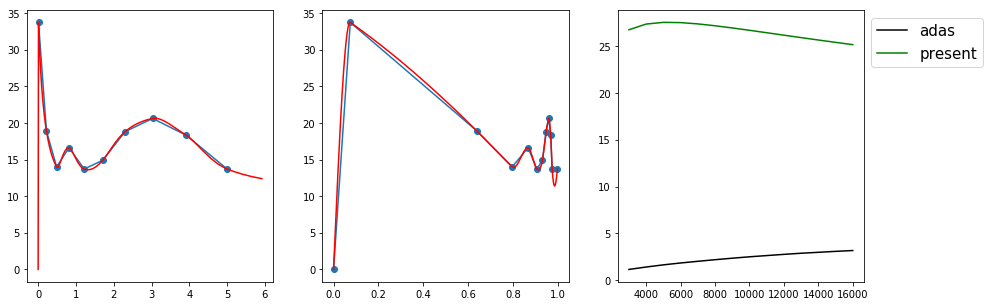

In [120]:
for j in range(180,200):
    ntype=int(omg.loc[j]['type'])
    print("j=",j,"type=",ntype)
    Aki,gk,gi,eik,fik=data_trans(j,omg,levels)
    # copy data into aux variables
    yomg=omg.loc[j][3:-2].values
    xener=np.array(ener)
    # map into BT-space
    x,y=map_BTspace(xener,eik,yomg,ntype)
    # make spline of x y in BT-space
    nx=len(x)
    x_new=np.linspace(x[0],x[nx-1], npts)
    y_new=interp_omg(nx,x,y,x_new,'akima')
    # mapping back from BT-space
    enerpp,omgpp=mapback_BTspace(ntype,eik,x_new,y_new)
    # compute effective collision strength
    yups=compute_ECS(enerpp,omgpp,ups_new)
    # plot and check data
    fig=plt.figure(figsize=(15,5))
    ax1=plt.subplot(131)
    plt.plot(xener,yomg,'o-')
    plt.plot(enerpp,omgpp,'r-')
    ax2=plt.subplot(132)
    plt.plot(x,y,'o-')
    plt.plot(x_new,y_new,'r-')
    ax3=plt.subplot(133)
    plt.plot(T,ups_prev.loc[0][3:-1],'k',label="adas")
    plt.plot(T,yups,'g-',label="present")
    plt.legend(loc='upper left',bbox_to_anchor=[1,1],fontsize=15,ncol=1)
    plt.show()

In [121]:
def printout(dblevels,ups_prev):
    fp=open("Mg0+EffCollStr.dat","w+")
    zn=12
    ionch=0
    modidx=1
    source=999
    header=["AtomicNumber","IonCharge","ModelIndex","LowerLevel","UpperLevel",
             "Temperature","CollisionStrength","Source"]
    print(*header,sep="\t",file=fp)
    for j in range(200):
        k=int(ups_prev.loc[j]["k"])-1
        i=int(ups_prev.loc[j]["i"])-1
        nk=dblevels[k]
        ni=dblevels[i]
        if ni>nk: break
        for jj in range(ntemp):
            upsjj=ups_prev.loc[j][jj+3]
            tjj=T[jj]
            print(zn,ionch,modidx,ni,nk,tjj,upsjj,source,sep="\t",file=fp)
        if j==99: print("all print ok")
    return

printout(dblevels,ups_prev)

all print ok
